Ejercicio Microsoft Malware Prediction - Machine Learning



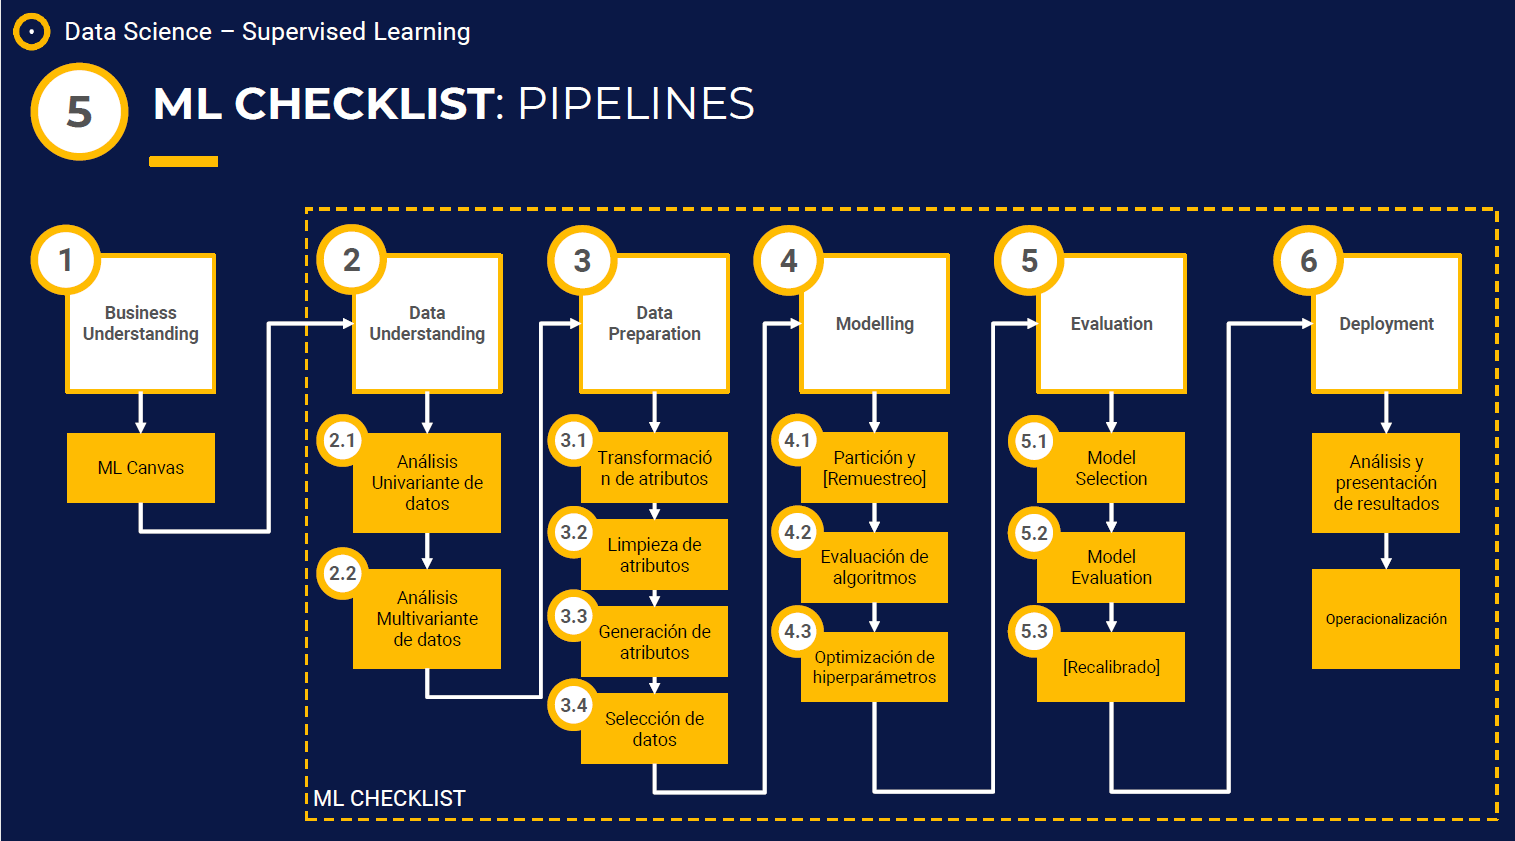

Enlaces de interés:

- Link de Kaggle: https://www.kaggle.com/competitions/microsoft-malware-prediction/data

## ML CANVAS



Se entiende como ML CANVAS a la forma de estructurar las decisiones más importantes a tomar en la definición del problema y el diseño de una solución a ese problema, usando datos y aplicando el machine learning.

A continuación, dejo el estudio realizado para afrontar este problema.


[Estudio ML Canvas](https://drive.google.com/file/d/1IzZ6DsWS6y2LyObKty3T3bG3_BShSMc4/view?usp=sharing)

# Importar

## Importar ibrerías

In [ ]:
#Las Bases de datos están alojadas en Google Drive, por lo que las cargaremos desde ahí.

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn import set_config

from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, RepeatedKFold, KFold

from sklearn.metrics import accuracy_score
import folium
import plotly.express as px

from scipy import stats

## Importar datos

In [ ]:
#BASE DATOS 
#MMP = pd.read_csv ("/content/drive/MyDrive/CAPSTONE/sample_mmp.csv", sep = ",")

In [ ]:
#TRABAJAR SOLO CON EL 5% de la muestra. Al tener una base de datos, se decidió hacer las pruebas con el 5% de la muestra. 

#num_filas = int(len(MMP) * 0.05)
#MMP10 = MMP.sample(n=num_filas, random_state=42)

MMP10 = MMP.copy()

# Funciones

In [ ]:
# Explorar variables categóricas

def cat_exploratory(df, column1):

  value_count = df[column1].value_counts()
  nulos = print('Valores nulos: ', df[column1].isnull().sum())

  plt.xticks(rotation=90)
  sns.countplot(data=df, x=column1)


  return value_count,  nulos

In [ ]:
def explore_cat_values(dataframe, column, target_column):
  _results_df = dataframe[dataframe[target_column] > 0.5].pivot_table(index = column, values = TARGET, aggfunc = [len, np.mean])
  _results_df.columns = ['infections', 'mean_target']
  _results_df['n_rows'] = dataframe[column].value_counts(dropna = False)
  _results_df['pct_rows_'] = (dataframe[column].value_counts(normalize = True, dropna = False)).round(3)
  _results_df['pct_infections'] = (_results_df['infections'] / _results_df['n_rows']).round(3)
  _results_df = _results_df[['n_rows', 'pct_rows_', 'infections', 'pct_infections', 'mean_target']]
  return _results_df

In [ ]:
def setOthers(dataframe, column, num_values = 5):
  top_categories = dataframe[column].value_counts().head(num_values)
  top_categories_list = top_categories.index.to_list()
  top_categories_list.append('others')
  dataframe[column] = pd.Categorical(dataframe[column], categories = top_categories_list)
  dataframe[column].fillna('others')
  return dataframe[column].fillna('others')

In [ ]:
#columnas_eliminar = {"MachineIdentifier"}
#columnas_antiguas
#columnas_OHE = {'EngineVersionTRANSFORM'}
# columnas_OrdEnc

# Limpieza de Datos

---




## Análisis general: nulos, duplicados y target

In [ ]:
MMP10.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 84 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   Unnamed: 0                                         500000 non-null  int64  
 1   MachineIdentifier                                  500000 non-null  object 
 2   ProductName                                        500000 non-null  object 
 3   EngineVersion                                      500000 non-null  object 
 4   AppVersion                                         500000 non-null  object 
 5   AvSigVersion                                       500000 non-null  object 
 6   IsBeta                                             500000 non-null  int64  
 7   RtpStateBitfield                                   498168 non-null  float64
 8   IsSxsPassiveMode                                   500000 non-null  int64 

In [ ]:
# se observa que hay atributos con un dtype inadecuado.

In [ ]:
# Miramos si hay duplicados
MMP10.duplicated().sum()

0

In [ ]:
# Hace una tabla que muestra el total de nulos y el porcentaje que representan

def missing_percent(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    missing_data  = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data.head(50)

In [ ]:
missing_percent(MMP10)

Total  Percent
PuaMode                                            499874  99.9748
Census_ProcessorClass                              497918  99.5836
DefaultBrowsersIdentifier                          475939  95.1878
Census_IsFlightingInternal                         415225  83.0450
Census_InternalBatteryType                         355603  71.1206
Census_ThresholdOptIn                              318104  63.6208
Census_IsWIMBootEnabled                            317666  63.5332
SmartScreen                                        178596  35.7192
OrganizationIdentifier                             154563  30.9126
SMode                                               29848   5.9696
CityIdentifier                                      18240   3.6480
Wdft_IsGamer                                        16950   3.3900
Wdft_RegionIdentifier                               16950   3.3900
Census_InternalBatteryNumberOfCharges               15038   3.0076
Census_FirmwareManufacturerIdentifier               10349   2.0698
Census_FirmwareVersionIdentifier                     9061   1.8122
Census_IsFlightsDisabled                             8933   1.7866
Census_OEMModelIdentifier                            5764   1.1528
Census_OEMNameIdentifier                             5381   1.0762
Firewall                                             5162   1.0324
Census_TotalPhysicalRAM                              4556   0.9112
Census_IsAlwaysOnAlwaysConnectedCapable              4040   0.8080
Census_OSInstallLanguageIdentifier                   3332   0.6664
IeVerIdentifier                                      3209   0.6418
Census_PrimaryDiskTotalCapacity                      2976   0.5952
Census_SystemVolumeTotalCapacity                     2976   0.5952
Census_InternalPrimaryDiagonalDisplaySizeInInches    2654   0.5308
Census_InternalPrimaryDisplayResolutionHorizontal    2650   0.5300
Census_InternalPrimaryDisplayResolutionVertical      2650   0.5300
Census_ProcessorModelIdentifier                      2349   0.4698
Census_ProcessorCoreCount                            2347   0.4694
Census_ProcessorManufacturerIdentifier               2347   0.4694
AVProductsEnabled                                    1938   0.3876
AVProductStatesIdentifier                            1938   0.3876
AVProductsInstalled                                  1938   0.3876
IsProtected                                          1926   0.3852
RtpStateBitfield                                     1832   0.3664
Census_IsVirtualDevice                                901   0.1802
Census_PrimaryDiskTypeName                            709   0.1418
UacLuaenable                                          623   0.1246
Census_ChassisTypeName                                 37   0.0074
GeoNameIdentifier                                      16   0.0032
Census_PowerPlatformRoleName                            2   0.0004
OsBuildLab                                              1   0.0002
Census_OSSkuName                                        0   0.0000
Census_OSEdition                                        0   0.0000
Census_OSWUAutoUpdateOptionsName                        0   0.0000
Census_OSInstallTypeName                                0   0.0000
Census_OSUILocaleIdentifier                             0   0.0000
Census_IsSecureBootEnabled                              0   0.0000

### Target

In [ ]:
# Establecemos la variable Target

TARGET = 'HasDetections'

MMP10["HasDetections"].value_counts(normalize= True)

0    0.500094
1    0.499906
Name: HasDetections, dtype: float64

## Análisis univariante


###MachineIdentifier

In [ ]:
MMP10["MachineIdentifier"].value_counts()

f1cd864e97bae82bdf96523e1a539121    1
74f5f637add24668804961d81cca7697    1
d1e0560ad7cd178b32599edb67142737    1
d03a6fb0852e2ad3380e689a80d23273    1
8b3a780e6980a83b1650e7fc873dcfd1    1
                                   ..
6154953dc05531cad9fb680cf39990b4    1
b345b8ccc72ba43e7417b2018fb61444    1
013b44e10f97fa8f71b6b76e24323d51    1
ce0e5ba490a2455a87d09184b9bbd578    1
7b45dc3537e17f16305c5983ca0a1cb9    1
Name: MachineIdentifier, Length: 500000, dtype: int64

In [ ]:
# Atributo sin varianza. La eliminamos.

columnas_eliminar = {"MachineIdentifier"}

###ProductName

In [ ]:
MMP10["ProductName"].value_counts(normalize = True)

# Atributo con muy poca varianza. No nos va a ayudar a predecir. La eliminamos.

win8defender     0.989208
mse              0.010790
mseprerelease    0.000002
Name: ProductName, dtype: float64

In [ ]:
columnas_eliminar.add('ProductName')
columnas_eliminar

{'MachineIdentifier', 'ProductName'}

###EngineVersion

In [ ]:
MMP10["EngineVersion"].value_counts().sort_values(ascending=False)

1.1.15200.1    216491
1.1.15100.1    205494
1.1.15000.2     14752
1.1.14901.4     11984
1.1.14600.4      9005
1.1.14800.3      7548
1.1.15300.6      6769
1.1.14104.0      5240
1.1.15300.5      3883
1.1.13504.0      3876
1.1.14700.5      2593
1.1.14500.5      2591
1.1.14405.2      1972
1.1.14306.0      1329
1.1.14202.0       840
1.1.14003.0       804
1.1.13303.0       516
1.1.13903.0       515
1.1.13804.0       513
1.1.13407.0       479
1.1.13601.0       420
1.1.12902.0       321
1.1.14305.0       270
1.1.13701.0       255
1.1.13704.0       255
1.1.13202.0       245
1.1.13103.0       235
1.1.13000.0       220
1.1.15000.1       138
1.1.12805.0       115
1.1.14901.3        71
1.1.14700.4        65
1.1.14700.3        61
1.1.14800.1        51
1.1.14500.2        19
1.1.14201.0        11
1.1.14303.0        10
1.1.12101.0         7
1.1.14103.0         5
1.1.13902.0         4
1.1.13802.0         4
1.1.12804.0         4
1.1.13803.0         3
1.1.12603.0         3
1.1.11701.0         3
1.1.14001.

In [ ]:
# Decidimos agrupar la variable en versiones más genéricas (1.15 , 1.14...) sin perder valor y haciéndola mejor para el modelo.

In [ ]:
def agrupar_6caract(valor):
    return valor[:6]
MMP10['EngineVersionTRANSFORM'] = MMP10['EngineVersion'].apply(agrupar_6caract)
MMP10["EngineVersionTRANSFORM"].value_counts().sort_values(ascending=False)

1.1.15    447527
1.1.14     44475
1.1.13      7542
1.1.12       452
1.1.11         3
1.1.10         1
Name: EngineVersionTRANSFORM, dtype: int64

In [ ]:
# Después de la agrupación sigue teniendo poca varianza, haremos OHE. más adelante decidiremos.

In [ ]:
#ELIMINAR LA VARIABLE ANTERIOR Y HACER OHE

columnas_antiguas_eliminar = {'EngineVersion'}
columnas_OHE = {"EngineVersionTRANSFORM"}

###AppVersion

In [ ]:
MMP10["AppVersion"].value_counts().sort_values(ascending=False)

# Observamos que esta variable somos capaces de organizarla como la anterior, pero en este caso  (4.18 , 4.17...) sin perder valor y haciéndola mejor para el modelo.

4.18.1807.18075    288809
4.18.1806.18062     47641
4.12.16299.15       20197
4.10.209.0          15292
4.13.17134.1        14414
                    ...  
4.15.17655.1000         1
4.9.10586.456           1
4.13.17639.1000         1
4.18.1806.20033         1
4.18.1807.18070         1
Name: AppVersion, Length: 95, dtype: int64

In [ ]:
def agrupar_4caract(valor):
    return valor[:4]
MMP10['AppVersionmayores4.18'] = MMP10['AppVersion'].apply(agrupar_4caract)

MMP10['AppVersionmayores4.18'].value_counts()

# Como vemos que la variable más relevante es 4.18, por ser la más actual, haremos una variable que distinga las versiones actualizadas (4.18) de las demás.


4.18    337243
4.12     30836
4.13     29076
4.10     25633
4.9.     23256
4.8.     15309
4.14     13727
4.16     13189
4.11     11458
4.5.       126
4.7.        46
4.6.        44
4.4.        27
4.17        22
4.15         8
Name: AppVersionmayores4.18, dtype: int64

In [ ]:
# Limpiamos los valores para poder transformalos

MMP10['AppVersionmayores4.18'] = MMP10['AppVersionmayores4.18'].str.rstrip('.')

MMP10['AppVersionmayores4.18'].value_counts()


4.18    337243
4.12     30836
4.13     29076
4.10     25633
4.9      23256
4.8      15309
4.14     13727
4.16     13189
4.11     11458
4.5        126
4.7         46
4.6         44
4.4         27
4.17        22
4.15         8
Name: AppVersionmayores4.18, dtype: int64

Valores nulos:  0


(1    376051
 0    123949
 Name: AppVersionmayores4.18, dtype: int64,
 None)

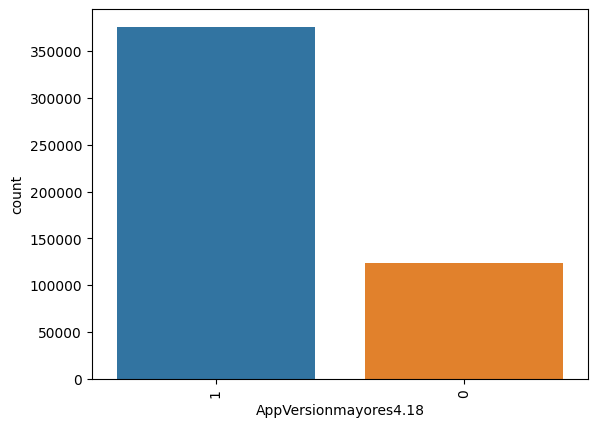

In [ ]:
# Agrupamos los valores en mayores/menores de v. 4.18
MMP10['AppVersionmayores4.18'] = MMP10['AppVersionmayores4.18'].astype(float)

MMP10['AppVersionmayores4.18'] = MMP10['AppVersionmayores4.18'].apply(lambda x: '1' if x >= 4.18 else '0')

cat_exploratory(MMP10, 'AppVersionmayores4.18')

In [ ]:
# Al convertirla en booleana no hará falta transformarla con OHE

MMP10['AppVersionmayores4.18'] = MMP10['AppVersionmayores4.18'].astype(int)


In [ ]:
MMP10["AppVersionmayores4.18"].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: AppVersionmayores4.18
Non-Null Count   Dtype
--------------   -----
500000 non-null  int64
dtypes: int64(1)
memory usage: 3.8 MB


In [ ]:
#ELIMINAR LA VARIABLE ANTERIOR

columnas_antiguas_eliminar.add('AppVersion')

###AvSigVersion

In [ ]:
MMP10["AvSigVersion"].value_counts().sort_values(ascending=False)

#Observamos que esta variable somos capaces de organizarla por versiones (1.20, 1.21 ... ) sin perder valor y haciéndola mejor para el modelo.

1.273.1420.0    5771
1.263.48.0      5537
1.275.1140.0    5317
1.275.727.0     5214
1.273.371.0     4799
                ... 
1.235.1570.0       1
1.237.1198.0       1
1.229.727.0        1
1.225.517.0        1
1.235.1538.0       1
Name: AvSigVersion, Length: 6455, dtype: int64

In [ ]:
def agrupar_4caract(valor):
    return valor[:4]

MMP10['AvSigVersionTRANSFORM'] = MMP10['AvSigVersion'].apply(agrupar_4caract)
MMP10["AvSigVersionTRANSFORM"].value_counts().sort_values(ascending=False)

1.27    447343
1.26     34152
1.25      9678
1.23      5539
1.24      2372
1.22       896
1.20         7
1.21         5
0.0.         4
1.19         3
1.16         1
Name: AvSigVersionTRANSFORM, dtype: int64

In [ ]:
MMP10["AvSigVersionOrdened"] = MMP10["AvSigVersionTRANSFORM"].sort_index(ascending = True)

In [ ]:
# Al tratarse de versiones y tener categorias con pocos valores, es candidata para transformarla con Ordinal Encoder

In [ ]:
#ELIMINAR LA VARIABLE ANTERIOR Y ORDINAL ENCODER

columnas_antiguas_eliminar.update(['AvSigVersion', "AvSigVersionTRANSFORM"])
columnas_OrdEnc = {"AvSigVersionOrdened"}

###IsBeta

In [ ]:
MMP10['IsBeta'].value_counts()

0    499999
1         1
Name: IsBeta, dtype: int64

In [ ]:
MMP10['IsBeta'].isnull().sum()

0

In [ ]:
#Eliminamos la variable al no tener varianza. Todas las filas tienen el mismo valor y no nos aporta informacion.

columnas_eliminar.add('IsBeta')
columnas_eliminar

{'IsBeta', 'MachineIdentifier', 'ProductName'}

###RtpStateBitfield

In [ ]:
MMP10['RtpStateBitfield'].value_counts(normalize=True)

7.0     0.973248
0.0     0.021298
8.0     0.002563
5.0     0.002325
3.0     0.000353
1.0     0.000211
35.0    0.000002
Name: RtpStateBitfield, dtype: float64

In [ ]:
#Eliminamos la variable al tener una varianza muy baja. El valor "7.0" posee el 97,3% de los valores, lo que difícilmente aportará nada al modelo.

columnas_eliminar.add('RtpStateBitfield')

###IsSxsPassiveMode

In [ ]:
MMP10['IsSxsPassiveMode'].value_counts(normalize=True)

0    0.982758
1    0.017242
Name: IsSxsPassiveMode, dtype: float64

In [ ]:
#Al igual que en la variable anterior, es una variable sin apenas varianza. Booleana que tiene un 98,2% de los valores en True. Eliminamos, no aporta.

columnas_eliminar.add('IsSxsPassiveMode')
columnas_eliminar

{'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'ProductName',
 'RtpStateBitfield'}

###DefaultBrowsersIdentifier

In [ ]:
MMP10['DefaultBrowsersIdentifier'].value_counts()

239.0     2589
3195.0    2423
1632.0    1601
3176.0    1313
146.0     1231
          ... 
2285.0       1
2100.0       1
2459.0       1
2196.0       1
1427.0       1
Name: DefaultBrowsersIdentifier, Length: 554, dtype: int64

In [ ]:
MMP10['DefaultBrowsersIdentifier'].isnull().sum()

475939

In [ ]:
(MMP10['DefaultBrowsersIdentifier'].isnull(). sum()) / len (MMP10['DefaultBrowsersIdentifier']) *100

95.1878

In [ ]:
#En este caso, nos encontramos con un 95% de nulos, hacer una tranformacion nos añadiría mucho sesgo en la variable, por lo que decidimos eliminarla.

columnas_eliminar.add('DefaultBrowsersIdentifier')
columnas_eliminar

{'DefaultBrowsersIdentifier',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'ProductName',
 'RtpStateBitfield'}

###AVProductStatesIdentifier

In [ ]:
MMP10['AVProductStatesIdentifier'].value_counts(normalize=True)

53447.0    0.655467
7945.0     0.053491
47238.0    0.037015
62773.0    0.029978
46413.0    0.012735
             ...   
2451.0     0.000002
19604.0    0.000002
3193.0     0.000002
26492.0    0.000002
18324.0    0.000002
Name: AVProductStatesIdentifier, Length: 5516, dtype: float64

In [ ]:
MMP10['AVProductStatesIdentifier'].isnull().sum()

1938

In [ ]:
# Imputamos los nulos con el valor más habitual de la variable

MMP10['AVProductStatesIdentifier'].fillna(MMP10['AVProductStatesIdentifier'].mode()[0], inplace=True)



In [ ]:
#Deberíamos cambiar el tipo, ya que no es un float, si no un object. Sus valores no pueden tratartse como numéricos como tal, ya que son identificadores.

MMP10['AVProductStatesIdentifier'] = MMP10['AVProductStatesIdentifier'].astype(int)

MMP10['AVProductStatesIdentifier'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: AVProductStatesIdentifier
Non-Null Count   Dtype
--------------   -----
500000 non-null  int64
dtypes: int64(1)
memory usage: 3.8 MB


In [ ]:
MMP['AVProductStatesIdentifier'].nunique()

5516

In [ ]:
sorted(MMP10['AVProductStatesIdentifier'].unique())


[3,
 17,
 39,
 48,
 51,
 68,
 104,
 191,
 216,
 227,
 256,
 260,
 264,
 267,
 287,
 288,
 296,
 307,
 329,
 335,
 338,
 343,
 356,
 387,
 396,
 401,
 419,
 424,
 444,
 449,
 474,
 522,
 538,
 547,
 560,
 573,
 586,
 646,
 659,
 668,
 687,
 710,
 712,
 713,
 775,
 815,
 826,
 841,
 857,
 871,
 885,
 888,
 901,
 938,
 956,
 983,
 995,
 1006,
 1012,
 1021,
 1025,
 1056,
 1069,
 1101,
 1144,
 1158,
 1159,
 1178,
 1223,
 1240,
 1252,
 1260,
 1270,
 1322,
 1334,
 1337,
 1347,
 1359,
 1374,
 1405,
 1408,
 1410,
 1444,
 1491,
 1510,
 1516,
 1526,
 1549,
 1561,
 1574,
 1604,
 1636,
 1657,
 1675,
 1693,
 1702,
 1708,
 1716,
 1746,
 1762,
 1764,
 1768,
 1798,
 1808,
 1850,
 1858,
 1878,
 1898,
 1906,
 1916,
 1923,
 1930,
 1932,
 1936,
 1968,
 1987,
 1989,
 2006,
 2011,
 2021,
 2041,
 2060,
 2063,
 2076,
 2090,
 2107,
 2119,
 2127,
 2128,
 2147,
 2148,
 2218,
 2219,
 2222,
 2236,
 2238,
 2250,
 2262,
 2279,
 2283,
 2293,
 2319,
 2321,
 2361,
 2365,
 2368,
 2380,
 2385,
 2386,
 2388,
 2404,
 2411,


(array([ 38026.,   5587.,  18447.,   3780.,  63781., 342307.,  26134.]),
 array([3.00000000e+00, 1.00728571e+04, 2.01427143e+04, 3.02125714e+04,
        4.02824286e+04, 5.03522857e+04, 6.04221429e+04, 7.04920000e+04]),
 <BarContainer object of 7 artists>)

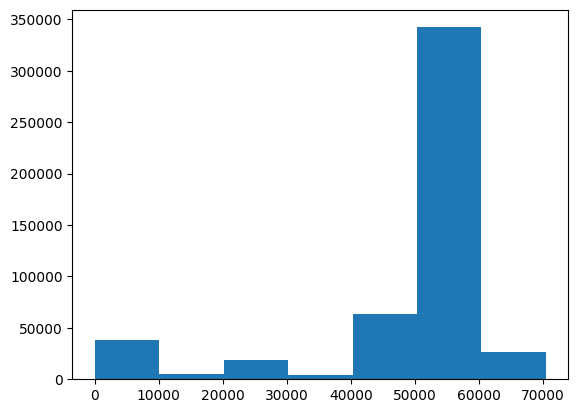

In [ ]:
plt.hist(MMP["AVProductStatesIdentifier"], bins=7)


In [ ]:
# Agrupamos el atributo de 10.000 en 10.000.

limits = range(0, 70486, 10000)

MMP10['AVProductStatesIdentifier_Grouped'] = pd.cut(MMP10['AVProductStatesIdentifier'], bins=limits)

MMP10['AVProductStatesIdentifier_Grouped'].value_counts(normalize=True, dropna= False).sort_index()

(0.0, 10000.0]        0.076032
(10000.0, 20000.0]    0.011156
(20000.0, 30000.0]    0.036796
(30000.0, 40000.0]    0.007532
(40000.0, 50000.0]    0.126212
(50000.0, 60000.0]    0.689430
(60000.0, 70000.0]    0.051930
NaN                   0.000912
Name: AVProductStatesIdentifier_Grouped, dtype: float64

In [ ]:
MMP10['AVProductStatesIdentifier_Grouped'] = MMP10['AVProductStatesIdentifier_Grouped'].astype(str)

In [ ]:

MMP10['AVProductStatesIdentifier_Grouped'].value_counts(normalize=True, dropna= False).sort_index()

(0, 10000]        0.076032
(10000, 20000]    0.011156
(20000, 30000]    0.036796
(30000, 40000]    0.007532
(40000, 50000]    0.126212
(50000, 60000]    0.689430
(60000, 70000]    0.051930
nan               0.000912
Name: AVProductStatesIdentifier_Grouped, dtype: float64

In [ ]:
# Imputamos valores nulos a categoria minoritaria.

In [ ]:
MMP10['AVProductStatesIdentifier_Grouped'] = MMP10['AVProductStatesIdentifier_Grouped'].replace('nan', '(30000, 40000]')

In [ ]:
#ELIMINAR LA VARIABLE ANTERIOR Y HACER OHE


columnas_antiguas_eliminar.add('AVProductStatesIdentifier')
columnas_OHE.add('AVProductStatesIdentifier_Grouped')

###AVProductsInstalled

Valores nulos:  1938


(1.0    348046
 2.0    137856
 3.0     11617
 4.0       514
 5.0        29
 Name: AVProductsInstalled, dtype: int64,
 None)

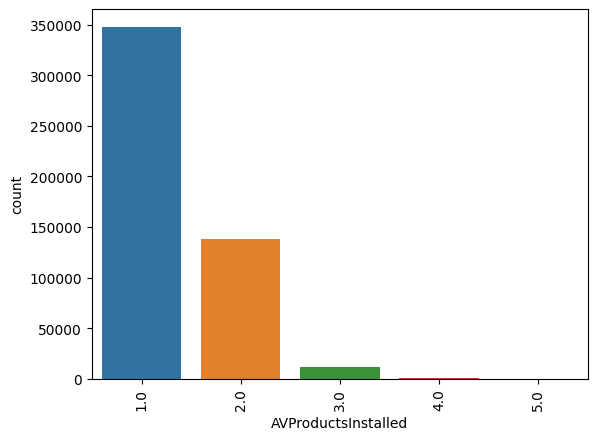

In [ ]:
cat_exploratory(MMP10, 'AVProductsInstalled')

In [ ]:
# Imputamos los valores nulos a la categoria mas frecuente
MMP10['AVProductsInstalled'].fillna(MMP10['AVProductsInstalled'].mode()[0], inplace=True)

In [ ]:
MMP10[['AVProductsInstalled','AVProductsEnabled']].head()

AVProductsInstalled  AVProductsEnabled
0                  1.0                1.0
1                  1.0                1.0
2                  2.0                1.0
3                  1.0                1.0
4                  2.0                1.0

In [ ]:
# Esta variable es valiosa así.Cambiamos dtype a int

MMP10['AVProductsInstalled'] = MMP10['AVProductsInstalled'].astype(int)
MMP10['AVProductsInstalled'].value_counts()

1    349984
2    137856
3     11617
4       514
5        29
Name: AVProductsInstalled, dtype: int64

In [ ]:
# Es candidata para OrdinalEncoder, ya que hay una relación ordinal entre los valores de la variable

columnas_OrdEnc.add('AVProductsInstalled')

###AVProductsEnabled


In [ ]:
MMP10['AVProductsEnabled'].value_counts(normalize=True)

1.0    0.974134
2.0    0.022234
0.0    0.002945
3.0    0.000634
4.0    0.000052
Name: AVProductsEnabled, dtype: float64

In [ ]:
#En este caso, nos encontramos con un 97,4% de valores en 1.0, lo que hace que la variable sea muy pobre en cuanto a información. Decidimos borrarla.
columnas_eliminar.add('AVProductsEnabled')
columnas_eliminar

{'AVProductsEnabled',
 'DefaultBrowsersIdentifier',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'ProductName',
 'RtpStateBitfield'}

###HasTpm


In [ ]:
MMP10['HasTpm'].value_counts(normalize=True)

1    0.987816
0    0.012184
Name: HasTpm, dtype: float64

In [ ]:
#En este caso, nos encontramos con un 98,8% de valores que son 1. Es una variable booleana que no va a tener mucho valor en el modelo por su baja varianza. La eliminamos.
columnas_eliminar.add('HasTpm')

###CountryIdentifier

In [ ]:
MMP10['CountryIdentifier'].value_counts()

43     22339
29     19273
141    18420
93     16205
171    15743
       ...  
212       13
37        12
165       11
217       10
193        9
Name: CountryIdentifier, Length: 222, dtype: int64

In [ ]:
#Como vemos en esta variable, hay demasiados valores, lo que nos puede aportar mucho ruido. Vamos a generar una nueva variable que solo nos engloble aquellos valores mas altos y mas bajos. dejando todos los demás en "otros"

In [ ]:
conteo_valores = MMP10['CountryIdentifier'].value_counts()
conteo_valores[conteo_valores <= 300].sum()

9025

In [ ]:
300/25000*100

1.2

In [ ]:
MMP10['CountryIdentifierTRANSFORM'] = setOthers(MMP10, 'CountryIdentifier', num_values = 20)

In [ ]:
MMP10['CountryIdentifier'].value_counts()

43        22339
29        19273
141       18420
93        16205
171       15743
60        13118
201       12405
207       11981
66        11607
89        11064
97        10883
214       10576
158       10302
44        10159
9          9763
107        9446
68         8950
41         8948
51         8868
203        8785
others        0
Name: CountryIdentifier, dtype: int64

In [ ]:
# conteo_valores = MMP10['CountryIdentifier'].value_counts()
#def agrupar_country_identifier(valor):
 #   if valor in conteo_valores[conteo_valores == 1].index:
  #      return valor
  #  elif valor in conteo_valores[conteo_valores >= 600].index:
  #      return valor
  #  else:
    #    return 'otros'

# Aplicar la función al atributo
# MMP10['CountryIdentifierTRANSFORM'] = MMP10['CountryIdentifier'].apply(agrupar_country_identifier)

In [ ]:
len(MMP10['CountryIdentifierTRANSFORM'].value_counts())

21

In [ ]:
# Eliminamos la columna anitgua y atributo transformado candidato para OHE

columnas_antiguas_eliminar.add('CountryIdentifier')

columnas_OHE.add('CountryIdentifierTRANSFORM')

###CityIdentifier

In [ ]:
# Vamos a seguir un procedimiento similar que en CountryIdentifier, pero existen muchos más valores, 6711 ciudades.

MMP10['CityIdentifier'].value_counts()

130775.0    5271
16668.0     4747
82373.0     4649
10222.0     4011
61668.0     3724
            ... 
151632.0       1
41727.0        1
83230.0        1
131294.0       1
148194.0       1
Name: CityIdentifier, Length: 37157, dtype: int64

In [ ]:
MMP10['CityIdentifier'].isnull().sum()

18240

In [ ]:
MMP10['CityIdentifier'].value_counts().head(15)

130775.0    5271
16668.0     4747
82373.0     4649
10222.0     4011
61668.0     3724
143782.0    3572
66202.0     3572
58607.0     3368
92213.0     3209
66953.0     3143
22656.0     3085
96401.0     2813
136271.0    2692
74924.0     2480
39800.0     2138
Name: CityIdentifier, dtype: int64

In [ ]:
MMP10['CityIdentifier'].value_counts().tail(4000)
# Obsevamos como, más de 4000 ciudades solo tienen un registro. Nos conviene más segmentar por arriba que por abajo. Lo que haremos será meter las ciudades con mas de 150 conteos individualmente
# ... y todas las demás (con los nulos incluidos), en una variable llamada otros.

64258.0     1
145928.0    1
12412.0     1
7015.0      1
49394.0     1
           ..
151632.0    1
41727.0     1
83230.0     1
131294.0    1
148194.0    1
Name: CityIdentifier, Length: 4000, dtype: int64

In [ ]:
# Obtener el conteo de repeticiones de cada valor en la columna "CountryIdentifier"
conteo_ciudades = MMP10['CityIdentifier'].value_counts()
conteo_ciudades

130775.0    5271
16668.0     4747
82373.0     4649
10222.0     4011
61668.0     3724
            ... 
151632.0       1
41727.0        1
83230.0        1
131294.0       1
148194.0       1
Name: CityIdentifier, Length: 37157, dtype: int64

In [ ]:
MMP10['CityIdentifierTRANSFORM'] = setOthers(MMP10, 'CityIdentifier', num_values = 20)

In [ ]:
# Definir una función para asignar los nuevos valores
#def agrupar_city_identifier(valor):
    #if valor in conteo_ciudades[conteo_ciudades >= 150].index:
     #   return valor
    #else:
     #   return 'otros'

# Aplicar la función a la columna "CityIdentifier" y guardar el resultado en una nueva columna "CityIdentifierTRANSFORM"
#MMP10['CityIdentifierTRANSFORM'] = MMP10['CityIdentifier'].apply(agrupar_city_identifier)

In [ ]:
MMP10['CityIdentifierTRANSFORM'].value_counts()

others      437474
130775.0      5271
16668.0       4747
82373.0       4649
10222.0       4011
61668.0       3724
143782.0      3572
66202.0       3572
58607.0       3368
92213.0       3209
66953.0       3143
22656.0       3085
96401.0       2813
136271.0      2692
74924.0       2480
39800.0       2138
143155.0      2099
37376.0       2077
20805.0       2021
67513.0       1955
20710.0       1900
Name: CityIdentifierTRANSFORM, dtype: int64

In [ ]:
# Eliminamos la columna antigua

columnas_antiguas_eliminar.add('CityIdentifier')

In [ ]:
columnas_OHE.add('CityIdentifierTRANSFORM')

###OrganizationIdentifier

In [ ]:
MMP10['OrganizationIdentifier'].value_counts(normalize=True)

27.0    0.679965
18.0    0.286136
48.0    0.010589
50.0    0.007347
37.0    0.003034
11.0    0.003002
49.0    0.002162
46.0    0.001856
14.0    0.000738
32.0    0.000666
36.0    0.000599
52.0    0.000504
33.0    0.000495
2.0     0.000443
5.0     0.000318
40.0    0.000289
28.0    0.000284
4.0     0.000229
10.0    0.000200
51.0    0.000153
1.0     0.000113
20.0    0.000110
8.0     0.000107
6.0     0.000072
31.0    0.000067
47.0    0.000064
22.0    0.000061
39.0    0.000061
3.0     0.000058
21.0    0.000055
16.0    0.000046
19.0    0.000029
29.0    0.000023
42.0    0.000023
7.0     0.000020
44.0    0.000017
26.0    0.000017
43.0    0.000012
45.0    0.000012
41.0    0.000006
35.0    0.000006
23.0    0.000006
25.0    0.000003
17.0    0.000003
Name: OrganizationIdentifier, dtype: float64

In [ ]:
MMP10['OrganizationIdentifier'].isnull().sum()

154563

Valores nulos:  0


(27.0     234885
 Otros    166273
 18.0      98842
 Name: OrganizationIdentifierT, dtype: int64,
 None)

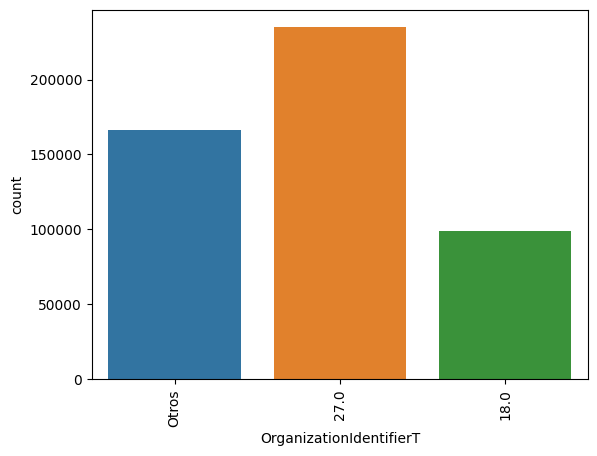

In [ ]:
#Esta variable tiene muchísimos nulos. Aproximadamente un 30% de la muestra. Creemos que nos pueden crear mucho ruido aun así consideramos que reorganizar la variable y luego evaluar mas tarde si tiene sentido puede ser más acertado.
#En este caso, haremos tres categorías. 27/18/otros. En 'otros' meteremos las variables con muy pocos datos que suman alrededor de un 2% + los nulos.

MMP10['OrganizationIdentifier'] = MMP10['OrganizationIdentifier'].astype(str)


MMP10['OrganizationIdentifierT'] = np.where((MMP10['OrganizationIdentifier'] != '18.0') & (MMP10['OrganizationIdentifier'] != '27.0'), 'Otros', MMP10['OrganizationIdentifier'])



cat_exploratory(MMP10,'OrganizationIdentifierT')

In [ ]:
#ELIMINAR LA VARIABLE ANTERIOR Y HACER OHE

columnas_antiguas_eliminar.add('OrganizationIdentifier')
columnas_OHE.add('OrganizationIdentifierT')

###GeoNameIdentifier


In [ ]:
MMP10["GeoNameIdentifier"].value_counts(normalize=True)

#Se observa como es otra variable que nos aporta localizaciones, por lo que pensamos que puede estar relacionada con alguna otra.

277.0    0.172166
211.0    0.047188
53.0     0.045955
89.0     0.040349
240.0    0.038979
           ...   
280.0    0.000002
231.0    0.000002
113.0    0.000002
221.0    0.000002
132.0    0.000002
Name: GeoNameIdentifier, Length: 268, dtype: float64

In [ ]:
geo_df = MMP[['GeoNameIdentifier', 'CountryIdentifier', 'CityIdentifier', TARGET]]

corr = geo_df.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
print('Observamos gran correlacion con la variable "CountryIdentifier": ',round(MMP["GeoNameIdentifier"].corr(MMP['CountryIdentifier']), 2))

#Observamos gran correlacion con la variable "CountryIdentifier"

Observamos gran correlacion con la variable "CountryIdentifier":  0.6


In [ ]:
# Observando las correlaciones con el Target ("HasDetections"), vemos con ninguna tiene una correlacion demasiado alta con el. Por lo tanto, ambas son iguales comparadas con el Target.
# Con estos datos procedemos a eliminar la variable "GeoNameIdentifier" al tener valores redundantes con 'CountryIdentifier'.

columnas_eliminar.add("GeoNameIdentifier")

###LocaleEnglishNameIdentifier

In [ ]:
# Evaluamos si tiene alguna relacion con otras variables de geolocalizacion.

In [ ]:
MMP10[['LocaleEnglishNameIdentifier','CountryIdentifier']].head(15)

LocaleEnglishNameIdentifier CountryIdentifier
0                           172               NaN
1                           124               NaN
2                            56               NaN
3                           172               NaN
4                            75               207
5                            75               NaN
6                            56               NaN
7                            42                43
8                           107               NaN
9                           229               NaN
10                          134               107
11                          113               NaN
12                           72               NaN
13                           75               NaN
14                            8               NaN

In [ ]:
MMP10['LocaleEnglishNameIdentifier'].value_counts(normalize=True)

75     0.235636
182    0.050374
42     0.046014
74     0.045788
88     0.041976
         ...   
152    0.000002
155    0.000002
165    0.000002
190    0.000002
127    0.000002
Name: LocaleEnglishNameIdentifier, Length: 233, dtype: float64

In [ ]:
# Nos revela la información geográfica de la columna, por lo que de momento la dejaremos así para ver su valor más adelante.

In [ ]:
columnas_FEnc = {'LocaleEnglishNameIdentifier'}

###Platform

Valores nulos:  0


(windows10      483048
 windows8        10825
 windows7         5314
 windows2016       813
 Name: Platform, dtype: int64,
 None)

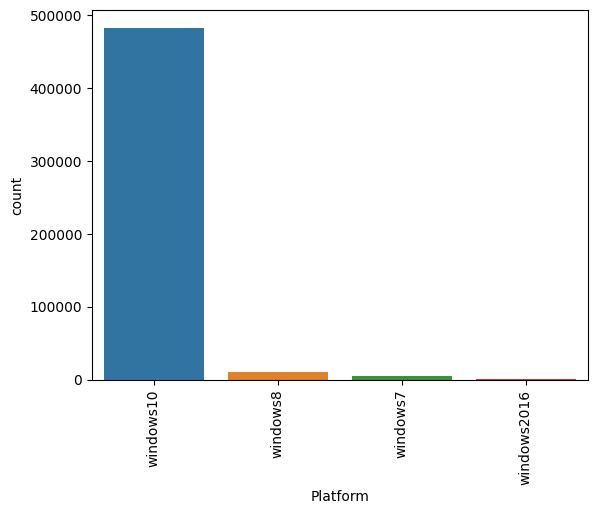

In [ ]:
cat_exploratory(MMP10,'Platform')

In [ ]:
# En otros casos habríamos decidido borrar la información dado que es una variable con muy poca varianza. Aún así esta nos interesa dejarla para analizarla más adelante en el modelo.
# Creemos que la información puede ser bastante útil aunque la variable esté muy desbalanceada. Posible overfitting para su uso. Dado que OHE implicaria añadir columnas con pocos datos, es candidata a FrequencyEncoder.
columnas_FEnc.add('Platform')
columnas_oversampling = {'Platform'}

###Processor

In [ ]:
MMP10["Processor"].value_counts()


x64      454423
x86       45563
arm64        14
Name: Processor, dtype: int64

In [ ]:
#Cambiamos el valor arm64 por x86 y dejamos la variable tal cual. Al convertirla en una categorica binaria. adaptamos el nombre.

MMP10["Processor_x64"] = MMP10["Processor"].replace({'arm64': 0, 'x86':0, 'x64':1})

MMP10["Processor_x64"].value_counts()



1    454423
0     45577
Name: Processor_x64, dtype: int64

In [ ]:
# Eliminamos columna antigua

columnas_antiguas_eliminar.add('Processor')

###OsVer


In [ ]:
MMP10["OsVer"].value_counts(normalize=True)


10.0.0.0      0.967660
6.3.0.0       0.021636
6.1.1.0       0.010562
6.1.0.0       0.000066
10.0.3.0      0.000024
10.0.1.0      0.000014
6.3.3.0       0.000004
10.0.0.1      0.000004
6.3.1.0       0.000004
10.0.32.72    0.000004
10.0.32.0     0.000002
10.0.80.0     0.000002
10.0.5.0      0.000002
10.0.2.0      0.000002
6.3.5.0       0.000002
10.0.4.0      0.000002
10.0.8.0      0.000002
10.0.0.112    0.000002
6.3.32.72     0.000002
6.3.7.0       0.000002
10.0.7.0      0.000002
Name: OsVer, dtype: float64

In [ ]:
def agrupar_2caract(valor):
    return valor[:2]
MMP10['OsVer10'] = MMP10['OsVer'].apply(agrupar_2caract)
MMP10["OsVer10"].value_counts(normalize=True)

10    0.967722
6.    0.032278
Name: OsVer10, dtype: float64

In [ ]:
# Mismo procedimiento que variable anterior, no hara falta hacer OHE
MMP10["OsVer10"] = MMP10["OsVer10"].replace('6.', '6')

MMP10["OsVer10"].replace({10:1, 6:0})

# Añadimos columna antigua a la lista para eliminar

columnas_antiguas_eliminar.add('OsVer')

columnas_OHE.add('OsVer10')

###OsBuild

In [ ]:
MMP10[['OsBuild']].head()

OsBuild
0    17134
1    17134
2    10586
3    17134
4    17134

In [ ]:
#Cambiamos el formato de la variable, ya que es un identificador.
MMP10['OsBuild'] = MMP10['OsBuild'].astype(object)

In [ ]:
MMP10['OsBuild'].describe()

count     500000
unique        48
top        17134
freq      220779
Name: OsBuild, dtype: int64

In [ ]:
MMP10['OsBuild'].value_counts()

17134    220779
16299    139901
15063     43352
14393     40717
10586     22955
10240     15014
9600      10825
7601       5281
17692       155
17738       134
17744       129
17758        86
17746        62
17713        60
17754        56
17751        53
17741        51
17755        45
17735        37
17686        36
17733        34
17763        33
7600         33
17760        31
17682        20
17677        17
18234        16
17672        15
18242        12
18237        12
17661         9
17666         8
17723         4
17634         4
17639         3
17730         3
17618         3
17747         3
17655         2
17650         2
17753         1
17604         1
18214         1
17711         1
17704         1
18219         1
17623         1
17749         1
Name: OsBuild, dtype: int64

In [ ]:
# Reducimos la dimensionalidad, añadiendo una nueva variable 'Otros', a partir de  7601, debido al bajo numero de bservaciones (El Decision Tree no se va a fijar en una variable tan escasa)

MMP10['OsBuild'] = setOthers(MMP10,'OsBuild', 7)

In [ ]:
MMP10['OsBuild'].value_counts()

17134     220779
16299     139901
15063      43352
14393      40717
10586      22955
10240      15014
9600       10825
others      6457
Name: OsBuild, dtype: int64

In [ ]:
#Añadimos a la lista de OHE.

In [ ]:
columnas_OHE.add('OsBuild')

### OsSuite

In [ ]:
MMP10['OsSuite'].head()

0    256
1    256
2    768
3    768
4    256
Name: OsSuite, dtype: int64

In [ ]:
MMP10['OsSuite'] = MMP10['OsSuite'].astype(object)

In [ ]:
MMP10['OsSuite'].describe()

count     500000
unique         9
top          768
freq      311226
Name: OsSuite, dtype: int64

In [ ]:
MMP10['OsSuite'].value_counts(dropna = False)

768    311226
256    187951
272       677
16         53
400        47
305        33
784        10
274         2
18          1
Name: OsSuite, dtype: int64

In [ ]:
explore_cat_values(MMP10, 'OsSuite', TARGET)

n_rows  pct_rows_  infections  pct_infections  mean_target
OsSuite                                                            
16           53      0.000          33           0.623            1
18            1      0.000           1           1.000            1
256      187951      0.376       96463           0.513            1
272         677      0.001         238           0.352            1
274           2      0.000           1           0.500            1
305          33      0.000          13           0.394            1
400          47      0.000          15           0.319            1
768      311226      0.622      153185           0.492            1
784          10      0.000           4           0.400            1

In [ ]:
#No existe ningún nulo, aplicamos la función setOthers para tener 3 etiquetas.
MMP10['OsSuite'] = setOthers(MMP10, 'OsSuite', 2)

In [ ]:
#La añadimos a la lista del OHE.
columnas_OHE.add('OsSuite')

### OsPlatformSubRelease

In [ ]:
MMP10['OsPlatformSubRelease'].describe()

count     500000
unique         9
top          rs4
freq      220779
Name: OsPlatformSubRelease, dtype: object

In [ ]:
#Variable que ya es un object.
MMP10['OsPlatformSubRelease'].value_counts(dropna = False)

rs4           220779
rs3           139901
rs2            43352
rs1            40717
th2            22955
th1            15014
windows8.1     10825
windows7        5314
prers5          1143
Name: OsPlatformSubRelease, dtype: int64

In [ ]:
#La añadimos a la lista de OHE.
columnas_OHE.add('OsPlatformSubRelease')

### OsBuildLab

In [ ]:
#El OsBuildLabes un identificador único que describe la versión y compilación de un sistema operativo.
#Es un valor alfanumérico que proporciona información detallada sobre la versión específica de un sistema operativo, incluyendo el número de compilación, la rama de desarrollo y otra información relevante

In [ ]:
MMP10['OsBuildLab'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: OsBuildLab
Non-Null Count   Dtype 
--------------   ----- 
499999 non-null  object
dtypes: object(1)
memory usage: 3.8+ MB


In [ ]:
MMP10['OsBuildLab'].describe()

count                                       499999
unique                                         453
top       17134.1.amd64fre.rs4_release.180410-1804
freq                                        206436
Name: OsBuildLab, dtype: object

In [ ]:
MMP10[['OsBuild','OsSuite','OsPlatformSubRelease','OsBuildLab']]

OsBuild OsSuite OsPlatformSubRelease  \
0        17134     256                  rs4   
1        17134     256                  rs4   
2        10586     768                  th2   
3        17134     768                  rs4   
4        17134     256                  rs4   
...        ...     ...                  ...   
499995   16299     768                  rs3   
499996   16299     768                  rs3   
499997   17134     256                  rs4   
499998   16299     256                  rs3   
499999   17134     256                  rs4   

                                               OsBuildLab  
0                17134.1.amd64fre.rs4_release.180410-1804  
1                17134.1.amd64fre.rs4_release.180410-1804  
2         10586.1176.amd64fre.th2_release_sec.170913-1848  
3                17134.1.amd64fre.rs4_release.180410-1804  
4                17134.1.amd64fre.rs4_release.180410-1804  
...                                                   ...  
499995  16299.431.amd64fre.rs3_release_svc_escrow.1805...  
499996          16299.15.amd64fre.rs3_release.170928-1534  
499997             17134.1.x86fre.rs4_release.180410-1804  
499998          16299.15.amd64fre.rs3_release.170928-1534  
499999           17134.1.amd64fre.rs4_release.180410-1804  

[500000 rows x 4 columns]

In [ ]:
#Columna redundante, ya que la información está ya includia en otras columnas.
#La añadimos a la lista de columnas a eliminar.
columnas_eliminar.add('OsBuildLab')

### SkuEdition

In [ ]:
#El SkuEdition es un término utilizado para describir las diferentes ediciones o versiones de un producto, especialmente en el contexto de los sistemas operativos.
#Se utiliza para distinguir entre las variantes del mismo sistema operativo que pueden tener características, funcionalidades y restricciones diferentes.

In [ ]:
MMP10['SkuEdition'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: SkuEdition
Non-Null Count   Dtype 
--------------   ----- 
500000 non-null  object
dtypes: object(1)
memory usage: 3.8+ MB


In [ ]:
MMP10['SkuEdition'].value_counts(normalize = True, dropna = False) #No tiene ningún valor nulo.

Home               0.617134
Pro                0.362084
Invalid            0.008846
Education          0.004642
Enterprise         0.003998
Enterprise LTSB    0.002282
Cloud              0.000618
Server             0.000396
Name: SkuEdition, dtype: float64

In [ ]:
explore_cat_values(MMP10,'SkuEdition', TARGET)

n_rows  pct_rows_  infections  pct_infections  mean_target
SkuEdition                                                                 
Cloud               309      0.001         121           0.392            1
Education          2321      0.005        1202           0.518            1
Enterprise         1999      0.004        1035           0.518            1
Enterprise LTSB    1141      0.002         614           0.538            1
Home             308567      0.617      152007           0.493            1
Invalid            4423      0.009        2069           0.468            1
Pro              181042      0.362       92853           0.513            1
Server              198      0.000          52           0.263            1

In [ ]:
#Home, a pesar de ser la version más utilizada, no es la que recibe más infecciones. Pro, recibe más infecciones proporcionalmente.
#La añadimos a la lista de OHE.
columnas_OHE.add('SkuEdition')

### IsProtected


In [ ]:
#True: Su hay al menos algun antivirus activado en la maquina.
#False: Hay algun antivirus en la maquina pero no está actualizado y/o activado.
#Nulo: No existe ningún antivirus en la maquina.

In [ ]:
MMP10['IsProtected'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: IsProtected
Non-Null Count   Dtype  
--------------   -----  
498074 non-null  float64
dtypes: float64(1)
memory usage: 3.8 MB


In [ ]:
MMP10['IsProtected'].value_counts(dropna = False)

1.0    471073
0.0     27001
NaN      1926
Name: IsProtected, dtype: int64

In [ ]:
MMP10['IsProtected'].fillna(0.0, inplace = True)

In [ ]:
explore_cat_values(MMP10,'IsProtected', TARGET)

n_rows  pct_rows_  infections  pct_infections  mean_target
IsProtected                                                            
0.0           28927      0.058       11076           0.383            1
1.0          471073      0.942      238877           0.507            1

In [ ]:
#El hecho de tener antivirus, no garantiza el hecho de no poder estar infectado. Como es lógico, No tener antivirus o no tenerlo activado o actualizado, podría estar considerado lo mismo.

In [ ]:
#Esta variable se quedará así, como booleana.
columnas_booleanas = {"IsProtected"}

### AutoSampleOptIn

In [ ]:
MMP10['AutoSampleOptIn'].value_counts()

0    499986
1        14
Name: AutoSampleOptIn, dtype: int64

In [ ]:
#Aributo muy desbalanceado. Muchos 0 y pocos 1. Añadimos a lista de columnas a eliminar.
columnas_eliminar.add('AutoSampleOptIn')

### PuaMode

In [ ]:
#Modo que, dependiendo del SO, permite al usuaria tener más control sobre que aplicaciones gestionan según que tipo de archivos

In [ ]:
MMP10['PuaMode'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: PuaMode
Non-Null Count  Dtype 
--------------  ----- 
126 non-null    object
dtypes: object(1)
memory usage: 3.8+ MB


In [ ]:
MMP10['PuaMode'].describe()

count     126
unique      1
top        on
freq      126
Name: PuaMode, dtype: object

In [ ]:
MMP10['PuaMode'].value_counts(dropna = False)

NaN    499874
on        126
Name: PuaMode, dtype: int64

In [ ]:
#Comentarios: Muy pocos usuarios tienen el POA Mode activado, simplemente 2. NO nos da demasiada información.
#Lo añadimos a la lista de columans a eliminar.
columnas_eliminar.add('PuaMode')

### SMode

In [ ]:
#El "S Mode" es una configuración especial de Microsoft Windows 10 que restringe la instalación de aplicaciones a través de fuentes no verificadas.
#En este modo, solo puedes instalar aplicaciones desde la Microsoft Store, lo que proporciona una experiencia más segura y controlada en términos de software.
#A priori, solo nos dda información sobre el Windows 10. True: Activado.

In [ ]:
MMP10['SMode'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: SMode
Non-Null Count   Dtype  
--------------   -----  
470152 non-null  float64
dtypes: float64(1)
memory usage: 3.8 MB


In [ ]:
MMP10['SMode'].value_counts()

0.0    469946
1.0       206
Name: SMode, dtype: int64

In [ ]:
#Muy pocos valors en 1, lo añadimos a la lsia de columnas a eliminar.
columnas_eliminar.add('SMode')

### IeVerIdentifier

In [ ]:
# Esta varaible se refiere a la version del navegador de Internet Explorer

In [ ]:
MMP10['IeVerIdentifier'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: IeVerIdentifier
Non-Null Count   Dtype  
--------------   -----  
496791 non-null  float64
dtypes: float64(1)
memory usage: 3.8 MB


In [ ]:
MMP10['IeVerIdentifier'] = MMP10['IeVerIdentifier'].astype(object)

In [ ]:
MMP10['IeVerIdentifier'].describe()

count     496791.0
unique       179.0
top          137.0
freq      219142.0
Name: IeVerIdentifier, dtype: float64

In [ ]:
MMP10['IeVerIdentifier'].value_counts(dropna = False)

137.0    219142
117.0     98667
108.0     26353
111.0     26143
98.0      19731
          ...  
79.0          1
15.0          1
54.0          1
192.0         1
281.0         1
Name: IeVerIdentifier, Length: 180, dtype: int64

In [ ]:
explore_cat_values(MMP10,'IeVerIdentifier', TARGET)

n_rows  pct_rows_  infections  pct_infections  mean_target
IeVerIdentifier                                                            
8.0                   1      0.000           1           1.000            1
39.0                 25      0.000          12           0.480            1
41.0               1918      0.004         926           0.483            1
42.0                502      0.001         230           0.458            1
44.0                181      0.000          84           0.464            1
...                 ...        ...         ...             ...          ...
388.0                 8      0.000           2           0.250            1
398.0                 8      0.000           1           0.125            1
407.0                 1      0.000           1           1.000            1
427.0                 1      0.000           1           1.000            1
429.0                12      0.000           3           0.250            1

[153 rows x 5 columns]

In [ ]:
MMP10['IeVerIdentifier'].value_counts().head(20)

137.0    219142
117.0     98667
108.0     26353
111.0     26143
98.0      19731
135.0     12314
74.0      11395
53.0      11352
94.0       9715
105.0      9695
333.0      8751
107.0      7080
103.0      6364
96.0       4695
76.0       3242
71.0       2275
41.0       1918
114.0      1862
323.0      1814
335.0      1422
Name: IeVerIdentifier, dtype: int64

In [ ]:
MMP10['IeVerIdentifier_grouped'] = setOthers(MMP10,'IeVerIdentifier',  8)

In [ ]:
# Eliminamos columna antigua y la nueva a la lista para OHE
columnas_antiguas_eliminar.add('IeVerIdentifier')
columnas_OHE.add('IeVerIdentifier_grouped')

### SmartScreen

In [ ]:
#SmartScreen es una tecnología de seguridad desarrollada por Microsoft que se utiliza para proteger a los usuarios de software malintencionado y sitios web potencialmente peligrosos.
#La función principal de SmartScreen es actuar como una barrera de seguridad para proteger a los usuarios de posibles amenazas en línea.

In [ ]:
MMP10['SmartScreen'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: SmartScreen
Non-Null Count   Dtype 
--------------   ----- 
321404 non-null  object
dtypes: object(1)
memory usage: 3.8+ MB


In [ ]:
MMP10['SmartScreen'].describe()

count           321404
unique              12
top       RequireAdmin
freq            241594
Name: SmartScreen, dtype: object

In [ ]:
MMP10['SmartScreen'].value_counts(dropna = False)

RequireAdmin    241594
NaN             178596
ExistsNotSet     58497
Off              10388
Warn              7530
Prompt            1950
Block             1274
off                 75
On                  53
&#x02;              20
&#x01;              14
on                   8
requireadmin         1
Name: SmartScreen, dtype: int64

In [ ]:
#Tiene muchos nulos, cambiamos los nulos por el atributo 'No_Smart'

In [ ]:
MMP10['SmartScreen'].fillna('No_smart', inplace = True)

In [ ]:
MMP10['SmartScreen'].value_counts(dropna = False)

RequireAdmin    241594
No_smart        178596
ExistsNotSet     58497
Off              10388
Warn              7530
Prompt            1950
Block             1274
off                 75
On                  53
&#x02;              20
&#x01;              14
on                   8
requireadmin         1
Name: SmartScreen, dtype: int64

In [ ]:
#Reducimos la dimensionalidad, dejando 6 etiquetas.
MMP10['SmartScreen'] = setOthers(MMP10, 'SmartScreen', 5)

In [ ]:
MMP10['SmartScreen'].value_counts(dropna = False)

RequireAdmin    241594
No_smart        178596
ExistsNotSet     58497
Off              10388
Warn              7530
others            3395
Name: SmartScreen, dtype: int64

In [ ]:
#Añadimos a la lista de OHE.
columnas_OHE.add('SmartScreen')

### Firewall

In [ ]:
#Atributo que es True si el SO es Windows 8.1, o superior y tiene el Firewall activado.

In [ ]:
MMP10['Firewall'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: Firewall
Non-Null Count   Dtype  
--------------   -----  
494838 non-null  float64
dtypes: float64(1)
memory usage: 3.8 MB


In [ ]:
MMP10['Firewall'] = MMP10['Firewall'].fillna(0.0)

In [ ]:
MMP10['Firewall'].value_counts(normalize = True, dropna = True)

1.0    0.968142
0.0    0.031858
Name: Firewall, dtype: float64

In [ ]:
# Al tratarse de variable booleana no requiere OHE.

columnas_oversampling.add("Firewall")

### UacLuaenable

In [ ]:
#El UAC ha sido diseñado para mejorar la seguridad de los sistemas Windows al prevenir modificaciones no deseadas y potencialmente dañinas.
#Al mantenerlo activado, se reducen los riesgos de infecciones por malware y cambios no autorizados en la configuración del sistema.

In [ ]:
MMP10['UacLuaenable'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: UacLuaenable
Non-Null Count   Dtype  
--------------   -----  
499377 non-null  float64
dtypes: float64(1)
memory usage: 3.8 MB


In [ ]:
MMP10['UacLuaenable'].value_counts(normalize = True, dropna = False)

1.0          0.992552
0.0          0.006172
NaN          0.001246
48.0         0.000026
2.0          0.000002
6357062.0    0.000002
Name: UacLuaenable, dtype: float64

In [ ]:
#Variable muy desbalanceada, 99.26% vs 0.74%. No nos proporciana ningún valor añaido. LA añadimos a la lista de coumnas a borrar.
columnas_eliminar.add('UacLuaenable')

### Census_MDC2FormFactor

In [ ]:
MMP10['Census_MDC2FormFactor'].head()

0        Desktop
1       Notebook
2    Convertible
3       Notebook
4       Notebook
Name: Census_MDC2FormFactor, dtype: object

In [ ]:
MMP10['Census_MDC2FormFactor'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: Census_MDC2FormFactor
Non-Null Count   Dtype 
--------------   ----- 
500000 non-null  object
dtypes: object(1)
memory usage: 3.8+ MB


In [ ]:
MMP10['Census_MDC2FormFactor'].value_counts(normalize = True, dropna = False)

Notebook        0.641896
Desktop         0.219054
Convertible     0.044738
Detachable      0.033604
AllInOne        0.032744
PCOther         0.015600
LargeTablet     0.007290
SmallTablet     0.003594
SmallServer     0.000992
MediumServer    0.000384
LargeServer     0.000100
ServerOther     0.000004
Name: Census_MDC2FormFactor, dtype: float64

In [ ]:
MMP10['Census_MDC2FormFactor'] = setOthers(MMP10, 'Census_MDC2FormFactor', 5)

In [ ]:
# Añadimos variable a lista OHE

columnas_OHE.add('Census_MDC2FormFactor')

### Census_DeviceFamily

In [ ]:
#Indica que tipo de dispositivo, según su sistema operativo, se trata.

In [ ]:
MMP10['Census_DeviceFamily'].head()

0    Windows.Desktop
1    Windows.Desktop
2    Windows.Desktop
3    Windows.Desktop
4    Windows.Desktop
Name: Census_DeviceFamily, dtype: object

In [ ]:
MMP10['Census_DeviceFamily'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: Census_DeviceFamily
Non-Null Count   Dtype 
--------------   ----- 
500000 non-null  object
dtypes: object(1)
memory usage: 3.8+ MB


In [ ]:
MMP10['Census_DeviceFamily'].describe()

count              500000
unique                  3
top       Windows.Desktop
freq               499183
Name: Census_DeviceFamily, dtype: object

In [ ]:
MMP10['Census_DeviceFamily'].value_counts(dropna = False)

Windows.Desktop    499183
Windows.Server        816
Windows                 1
Name: Census_DeviceFamily, dtype: int64

In [ ]:
#Variable muy desbalanceada. Atributo windows.Desktop muy mayoritario. La añadimos a la lista de columnas a eliminar.
columnas_eliminar.add('Census_DeviceFamily')

### Census_OEMNameIdentifier

In [ ]:
#OEM se refiere a los fabricantes de equipos originales que producen componentes y productos informáticos
#para ser utilizados por otras empresas en la fabricación de sus propios productos finales.

In [ ]:
MMP10['Census_OEMNameIdentifier'].head()

0    1443.0
1    2102.0
2    2206.0
3     525.0
4    1443.0
Name: Census_OEMNameIdentifier, dtype: float64

In [ ]:
MMP10['Census_OEMNameIdentifier'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: Census_OEMNameIdentifier
Non-Null Count   Dtype  
--------------   -----  
494619 non-null  float64
dtypes: float64(1)
memory usage: 3.8 MB


In [ ]:
MMP10['Census_OEMNameIdentifier'] = MMP10['Census_OEMNameIdentifier'].astype(object)

In [ ]:
MMP10['Census_OEMNameIdentifier'].describe()

count     494619.0
unique      1589.0
top         2668.0
freq       72011.0
Name: Census_OEMNameIdentifier, dtype: float64

<Axes: xlabel='HasDetections', ylabel='Census_OEMNameIdentifier'>

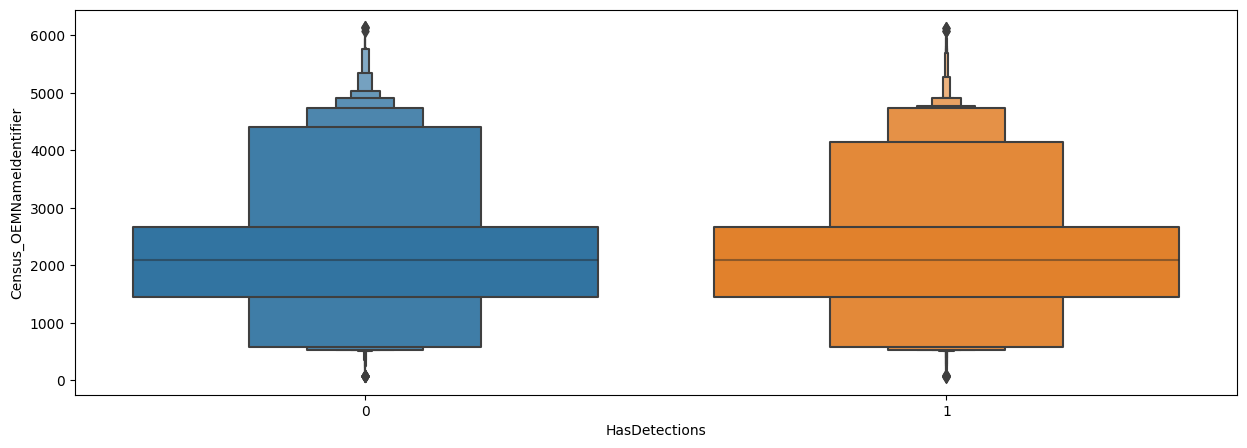

In [ ]:
plt.figure(figsize=(15,5))
sns.boxenplot(data = MMP10,
              x = 'HasDetections',
              y = 'Census_OEMNameIdentifier',
              )

In [ ]:
#Como se puede apreciar al plot, hay tantos 1 como 0 en cada rango de identificadores, por lo que no es una variable nada predictiva.
#La añadimos a la lista de columnas a eliminar.
columnas_eliminar.add('Census_OEMNameIdentifier')

### Census_OEMModelIdentifier

In [ ]:
MMP10['Census_OEMModelIdentifier'].head()

0    275891.0
1    248850.0
2    238234.0
3    265410.0
4    256478.0
Name: Census_OEMModelIdentifier, dtype: float64

In [ ]:
MMP10['Census_OEMModelIdentifier'] = MMP10['Census_OEMModelIdentifier'].astype(object)

In [ ]:
MMP10['Census_OEMModelIdentifier'].describe()

count     494236.0
unique     40697.0
top       313586.0
freq       17092.0
Name: Census_OEMModelIdentifier, dtype: float64

In [ ]:
MMP10['Census_OEMModelIdentifier'].value_counts(dropna = False)

313586.0    17092
242491.0    14726
317701.0     7676
317708.0     6541
NaN          5764
            ...  
1917.0          1
318232.0        1
342796.0        1
8067.0          1
35038.0         1
Name: Census_OEMModelIdentifier, Length: 40698, dtype: int64

<Axes: xlabel='HasDetections', ylabel='Census_OEMModelIdentifier'>

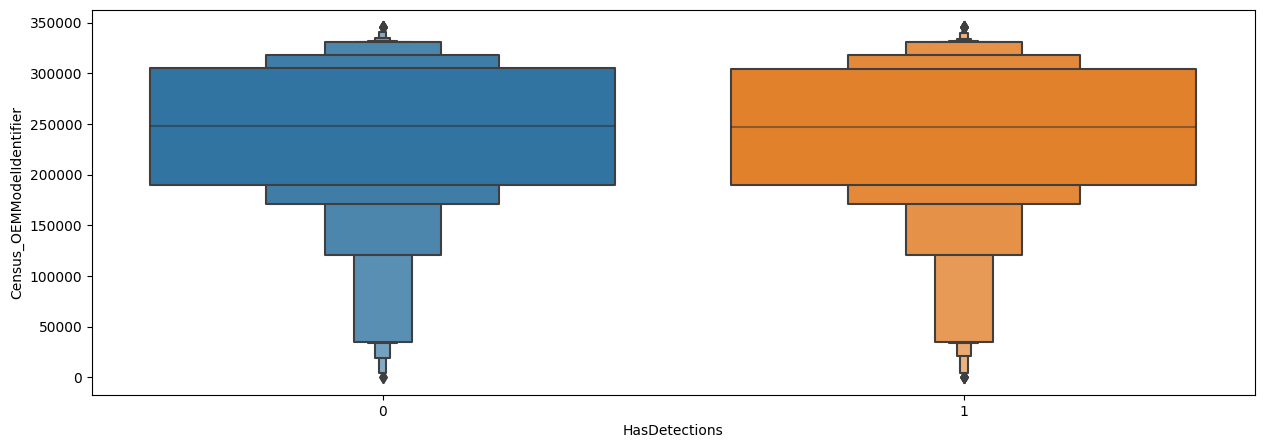

In [ ]:
plt.figure(figsize=(15,5))
sns.boxenplot(data = MMP10,
              x = 'HasDetections',
              y = 'Census_OEMModelIdentifier',
              )

In [ ]:
#Como se puede apreciar al plot, hay tantos 1 como 0 en cada rango de identificadores, por lo que no es una variable nada predictiva.
#La añadimos a la lista de columnas a eliminar.
columnas_eliminar.add('Census_OEMModelIdentifier')

### Census_ProcessorCoreCount

In [ ]:
#Número de nucleos en el procesador

In [ ]:
MMP10['Census_ProcessorCoreCount'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: Census_ProcessorCoreCount
Non-Null Count   Dtype  
--------------   -----  
497653 non-null  float64
dtypes: float64(1)
memory usage: 3.8 MB


In [ ]:
MMP10['Census_ProcessorCoreCount'].describe().T

count    497653.000000
mean          3.994074
std           2.071281
min           1.000000
25%           2.000000
50%           4.000000
75%           4.000000
max          88.000000
Name: Census_ProcessorCoreCount, dtype: float64

In [ ]:
MMP10['Census_ProcessorCoreCount'].value_counts(dropna = False)

4.0     304102
2.0     129178
8.0      48995
12.0      5184
6.0       4023
1.0       3980
NaN       2347
16.0      1006
3.0        752
32.0       113
20.0        97
24.0        95
40.0        39
28.0        17
36.0        16
48.0        15
5.0         10
10.0        10
56.0         8
7.0          3
11.0         2
64.0         2
52.0         1
44.0         1
88.0         1
80.0         1
14.0         1
46.0         1
Name: Census_ProcessorCoreCount, dtype: int64

In [ ]:
explore_cat_values(MMP10, 'Census_ProcessorCoreCount', TARGET)

n_rows  pct_rows_  infections  pct_infections  \
Census_ProcessorCoreCount                                                  
1.0                          3980      0.008        1207           0.303   
2.0                        129178      0.258       59122           0.458   
3.0                           752      0.002         342           0.455   
4.0                        304102      0.608      154734           0.509   
5.0                            10      0.000           7           0.700   
6.0                          4023      0.008        2290           0.569   
7.0                             3      0.000           1           0.333   
8.0                         48995      0.098       27121           0.554   
10.0                           10      0.000           3           0.300   
11.0                            2      0.000           1           0.500   
12.0                         5184      0.010        3011           0.581   
14.0                            1      0.000           1           1.000   
16.0                         1006      0.002         601           0.597   
20.0                           97      0.000          50           0.515   
24.0                           95      0.000          44           0.463   
28.0                           17      0.000           9           0.529   
32.0                          113      0.000          60           0.531   
36.0                           16      0.000           8           0.500   
40.0                           39      0.000          23           0.590   
44.0                            1      0.000           1           1.000   
46.0                            1      0.000           1           1.000   
48.0                           15      0.000           6           0.400   
56.0                            8      0.000           3           0.375   
64.0                            2      0.000           1           0.500   

                           mean_target  
Census_ProcessorCoreCount               
1.0                                  1  
2.0                                  1  
3.0                                  1  
4.0                                  1  
5.0                                  1  
6.0                                  1  
7.0                                  1  
8.0                                  1  
10.0                                 1  
11.0                                 1  
12.0                                 1  
14.0                                 1  
16.0                                 1  
20.0                                 1  
24.0                                 1  
28.0                                 1  
32.0                                 1  
36.0                                 1  
40.0                                 1  
44.0                                 1  
46.0                                 1  
48.0                                 1  
56.0                                 1  
64.0                                 1

In [ ]:
#Agrupamos en tres grandes bloques, los cuales serán 2, 4, 8 y 'Others'

In [ ]:
setOthers(MMP10,'Census_ProcessorCoreCount', 3)

0         4.0
1         4.0
2         4.0
3         8.0
4         4.0
         ... 
499995    4.0
499996    4.0
499997    4.0
499998    4.0
499999    8.0
Name: Census_ProcessorCoreCount, Length: 500000, dtype: category
Categories (4, object): [4.0, 2.0, 8.0, 'others']

In [ ]:
MMP10['Census_ProcessorCoreCount'] = setOthers(MMP10,'Census_ProcessorCoreCount', 3)

In [ ]:
#Cambiamos el tipo de variable a object y lo añadimos a la lista de OHE,
MMP10['Census_ProcessorCoreCount'] = MMP10['Census_ProcessorCoreCount'].astype(object)
columnas_OHE.add('Census_ProcessorCoreCount')

### Census_ProcessorManufacturerIdentifier

In [ ]:
#Identificador de fabricante

In [ ]:
MMP10['Census_ProcessorManufacturerIdentifier'].head()

0    5.0
1    5.0
2    5.0
3    5.0
4    1.0
Name: Census_ProcessorManufacturerIdentifier, dtype: float64

In [ ]:
MMP10['Census_ProcessorManufacturerIdentifier'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: Census_ProcessorManufacturerIdentifier
Non-Null Count   Dtype  
--------------   -----  
497653 non-null  float64
dtypes: float64(1)
memory usage: 3.8 MB


In [ ]:
#Debido que es un Id, lo consideramos una variable categorica.

In [ ]:
MMP10['Census_ProcessorManufacturerIdentifier'] = MMP10['Census_ProcessorManufacturerIdentifier'].astype(object)

In [ ]:
MMP10['Census_ProcessorManufacturerIdentifier'].describe()

count     497653.0
unique         4.0
top            5.0
freq      439028.0
Name: Census_ProcessorManufacturerIdentifier, dtype: float64

In [ ]:
MMP10['Census_ProcessorManufacturerIdentifier'].value_counts(dropna = False)

5.0     439028
1.0      58604
NaN       2347
10.0        14
3.0          7
Name: Census_ProcessorManufacturerIdentifier, dtype: int64

In [ ]:
#Reemplazamos los valores nulos por una etiqueta llamada 'Others'

In [ ]:
#Agrupamos Others y 10.0

In [ ]:
setOthers(MMP10,'Census_ProcessorManufacturerIdentifier', 2)

0         5.0
1         5.0
2         5.0
3         5.0
4         1.0
         ... 
499995    5.0
499996    5.0
499997    5.0
499998    5.0
499999    5.0
Name: Census_ProcessorManufacturerIdentifier, Length: 500000, dtype: category
Categories (3, object): [5.0, 1.0, 'others']

In [ ]:
MMP10['Census_ProcessorManufacturerIdentifier'].fillna('others', inplace = True)

In [ ]:
#Añadimos a la lista de OHE.
columnas_OHE.add('Census_ProcessorManufacturerIdentifier')

### Census_ProcessorModelIdentifier

In [ ]:
#Identificador según el modelo (y fabricante)

In [ ]:
MMP10['Census_ProcessorModelIdentifier'] = MMP10['Census_ProcessorModelIdentifier'].astype(object)

<Axes: xlabel='HasDetections', ylabel='Census_ProcessorModelIdentifier'>

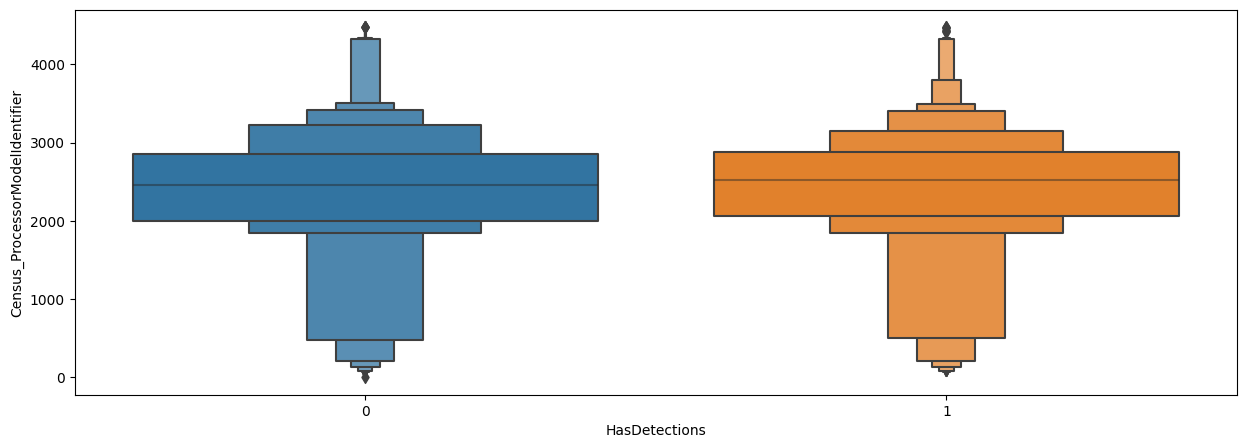

In [ ]:
MMP10['Census_ProcessorModelIdentifier'].describe()
plt.figure(figsize=(15,5))
sns.boxenplot(data = MMP10,
              x = 'HasDetections',
              y = 'Census_ProcessorModelIdentifier',
              )

In [ ]:
##Vomo se puede apreciar al plot, hay tantos 1 como 0 en cada rango de identificadores, por lo que no es una variable nada predictiva.
#La añadimos a la lista de columnas a eliminar.
columnas_eliminar.add('Census_ProcessorModelIdentifier')

### Census_ProcessorClass

In [ ]:
#Clasificación entre high/medium/low

In [ ]:
MMP10['Census_ProcessorClass'].info()


<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: Census_ProcessorClass
Non-Null Count  Dtype 
--------------  ----- 
2082 non-null   object
dtypes: object(1)
memory usage: 3.8+ MB


In [ ]:
MMP10['Census_ProcessorClass'].value_counts(dropna = False)

NaN     497918
mid       1196
low        546
high       340
Name: Census_ProcessorClass, dtype: int64

In [ ]:
#Gran cantidad de nulos. Según Kaggle, se empezo a usar para valorarlos monetariamente, pero se establecio no seguir con dicha clasificación.
#Añadimos a la lista de columnas a eliminar.
columnas_eliminar.add('Census_ProcessorClass')

###Census_PrimaryDiskTotalCapacity

In [ ]:
MMP10['Census_PrimaryDiskTotalCapacity'].describe()

count    4.970240e+05
mean     5.140433e+05
std      3.704468e+05
min      1.024000e+04
25%      2.393720e+05
50%      4.769400e+05
75%      9.538690e+05
max      4.768767e+07
Name: Census_PrimaryDiskTotalCapacity, dtype: float64

In [ ]:
# variable con distribucion muy desbalanceada a la izquierda.

In [ ]:
MMP10['Census_PrimaryDiskTotalCapacity'].isnull().sum()

2976

In [ ]:
def nulls_to_mean(df, column):
  df[column].fillna(df[column].mean(), inplace =  True)

nulls_to_mean(MMP10, 'Census_PrimaryDiskTotalCapacity')

<Axes: xlabel='Census_PrimaryDiskTotalCapacity', ylabel='Density'>

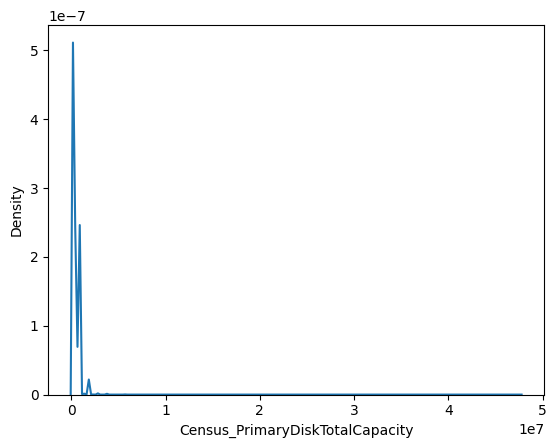

In [ ]:
sns.kdeplot(MMP10['Census_PrimaryDiskTotalCapacity'])

In [ ]:
PDTCmas1Mcount = len(MMP10[MMP10['Census_PrimaryDiskTotalCapacity']>1000000])
PDTCmenos1Mcount = len(MMP10[MMP10['Census_PrimaryDiskTotalCapacity']<1000000])
PDTCtotalvarcount = len(MMP10['Census_PrimaryDiskTotalCapacity'])
print('Con menos de 1,000,000 MB hay un porcentaje de', PDTCmenos1Mcount / PDTCtotalvarcount)

Con menos de 1,000,000 MB hay un porcentaje de 0.986202


In [ ]:
print('Estaríamos transformando a la media ', len(MMP10[MMP10['Census_PrimaryDiskTotalCapacity']>1000000])*95/5, ' valores de la muestra completa.')

Estaríamos transformando a la media  131081.0  valores de la muestra completa.


In [ ]:
# Transformamos outliers > 1500000 a la media

MMP10.loc[MMP10.loc[MMP10['Census_PrimaryDiskTotalCapacity'] > 1000000].index,
          'Census_PrimaryDiskTotalCapacity'] = MMP10['Census_PrimaryDiskTotalCapacity'].mean()

<Axes: xlabel='Census_PrimaryDiskTotalCapacity', ylabel='Density'>

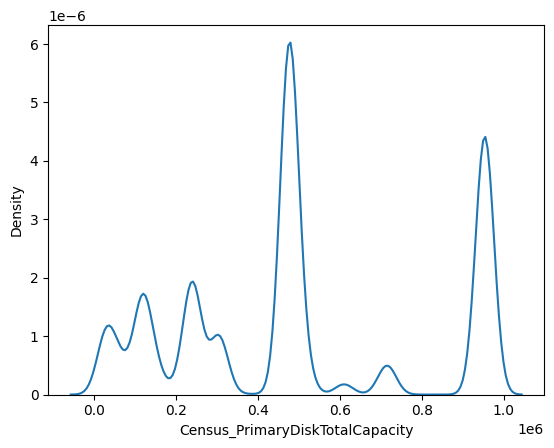

In [ ]:
sns.kdeplot(MMP10['Census_PrimaryDiskTotalCapacity'])

In [ ]:
# Variable candidata para aplicar MinMaxScaler en Fase Preprocesamiento

columnas_MinMaxS = {'Census_PrimaryDiskTotalCapacity'}

### Census_PrimaryDiskTypeName

Valores nulos:  709


(HDD            325429
 SSD            138155
 UNKNOWN         20083
 Unspecified     15624
 Name: Census_PrimaryDiskTypeName, dtype: int64,
 None)

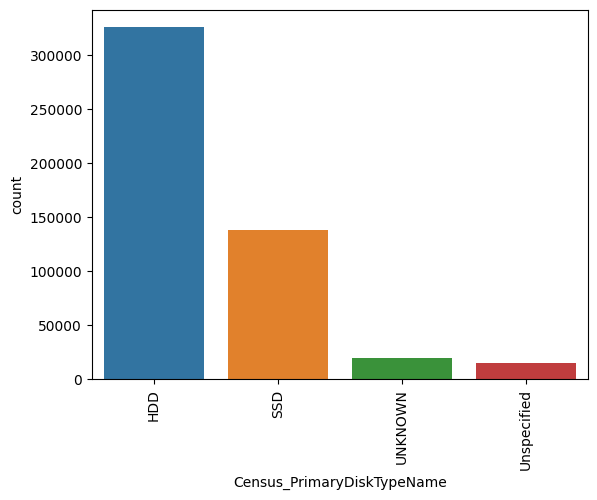

In [ ]:
cat_exploratory(MMP10,'Census_PrimaryDiskTypeName')

In [ ]:
# Agrupamos nulos y categoria 'Unespecified' a 'UNKNOWN'.

In [ ]:
MMP10['Census_PrimaryDiskTypeName'] = MMP10['Census_PrimaryDiskTypeName'].replace('Unspecified', 'UNKNOWN')
MMP10['Census_PrimaryDiskTypeName'] = MMP10['Census_PrimaryDiskTypeName'].fillna('UNKNOWN')

In [ ]:
# Variable candidata para OHE

columnas_OHE.add('Census_PrimaryDiskTypeName')

### Census_SystemVolumeTotalCapacity

In [ ]:
MMP10['Census_SystemVolumeTotalCapacity'].describe()

count    4.970240e+05
mean     3.780546e+05
std      3.384722e+05
min      9.689000e+03
25%      1.207750e+05
50%      2.494500e+05
75%      4.759810e+05
max      4.768710e+07
Name: Census_SystemVolumeTotalCapacity, dtype: float64

In [ ]:
nulls_to_mean(MMP10, 'Census_SystemVolumeTotalCapacity')

<Axes: xlabel='Census_SystemVolumeTotalCapacity', ylabel='Density'>

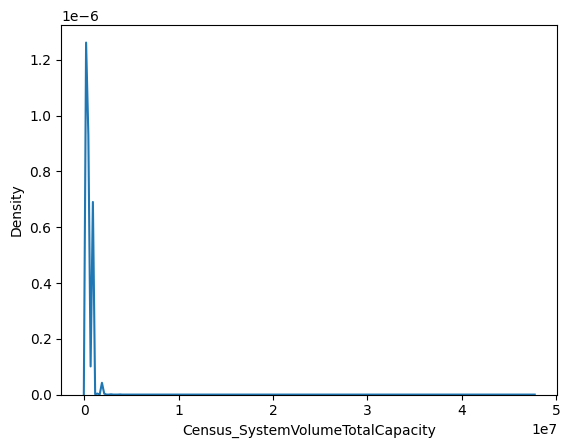

In [ ]:
sns.kdeplot(MMP10['Census_SystemVolumeTotalCapacity'])

In [ ]:
SVTCmas1Mcount = len(MMP10[MMP10['Census_SystemVolumeTotalCapacity']>1000000])
SVTCmenos1Mcount = len(MMP10[MMP10['Census_SystemVolumeTotalCapacity']<1000000])
SVTCtotalvarcount = len(MMP10['Census_SystemVolumeTotalCapacity'])
print('Con menos de 1,000,000 hay un porcentaje de', SVTCmenos1Mcount / SVTCtotalvarcount)

Con menos de 1,000,000 hay un porcentaje de 0.990956


In [ ]:
print('Estaríamos transformando a la media ', len(MMP10[MMP10['Census_SystemVolumeTotalCapacity']>1000000])*95/5, ' valores de la muestra completa.')

Estaríamos transformando a la media  85861.0  valores de la muestra completa.


In [ ]:
# Transformamos outliers > 1000000 a la media

MMP10.loc[MMP10.loc[MMP10['Census_SystemVolumeTotalCapacity'] > 1000000].index,
          'Census_SystemVolumeTotalCapacity'] = MMP10['Census_SystemVolumeTotalCapacity'].mean()

<Axes: xlabel='Census_SystemVolumeTotalCapacity', ylabel='Density'>

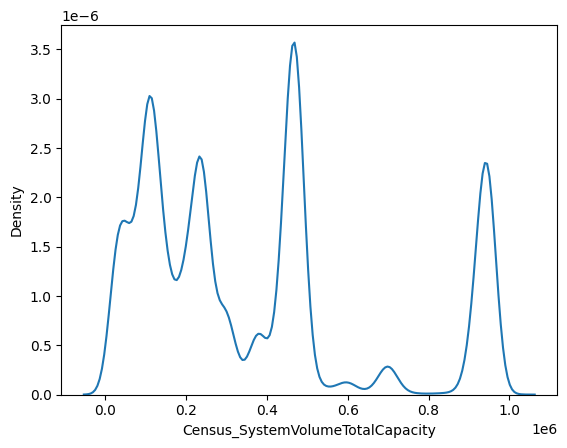

In [ ]:
sns.kdeplot(MMP10['Census_SystemVolumeTotalCapacity'])

In [ ]:
# Variable candidata para aplicar MinMaxScaler en fase preprocesamiento

columnas_MinMaxS.add('Census_SystemVolumeTotalCapacity')

### Census_HasOpticalDiskDrive

Valores nulos:  0


(0    461483
 1     38517
 Name: Census_HasOpticalDiskDrive, dtype: int64,
 None)

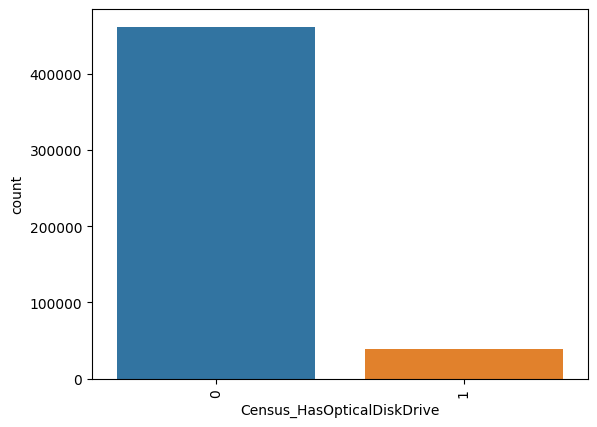

In [ ]:
cat_exploratory(MMP10,'Census_HasOpticalDiskDrive')

In [ ]:
# Variable muy desbalanceada y sin relevancia para el Target. La incluímos a la lista para eliminar.

In [ ]:
columnas_eliminar.add('Census_HasOpticalDiskDrive')

### Census_TotalPhysicalRAM

In [ ]:
MMP10['Census_TotalPhysicalRAM'].describe()

count    495444.000000
mean       6129.232176
std        4964.521253
min         512.000000
25%        4096.000000
50%        4096.000000
75%        8192.000000
max      393216.000000
Name: Census_TotalPhysicalRAM, dtype: float64

In [ ]:
nulls_to_mean(MMP10, 'Census_TotalPhysicalRAM')

In [ ]:
# convertimos la variable a int despues de transformar los nulos (4556) a la media.
MMP10['Census_TotalPhysicalRAM'].astype(int)

0          8192
1          8192
2          8192
3          8192
4          4096
          ...  
499995     4096
499996     8192
499997     4096
499998     6144
499999    16384
Name: Census_TotalPhysicalRAM, Length: 500000, dtype: int64

<Axes: xlabel='Census_TotalPhysicalRAM', ylabel='Density'>

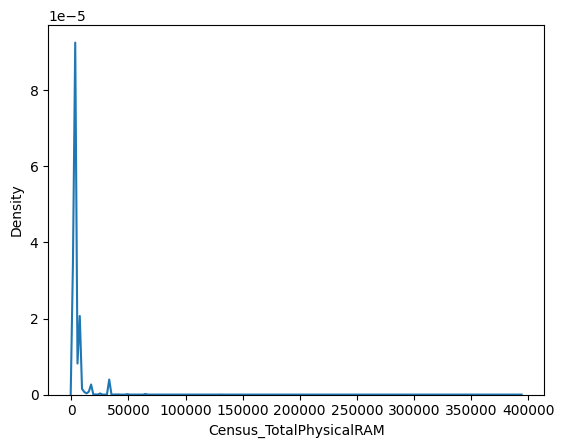

In [ ]:
sns.kdeplot(MMP10['Census_TotalPhysicalRAM'])

In [ ]:
# Variable muy desbalanceada a la izquierda, analizamos outliers

In [ ]:
TPRmas1Mcount = len(MMP10[MMP10['Census_TotalPhysicalRAM']>40000])
TPRmenos1Mcount = len(MMP10[MMP10['Census_TotalPhysicalRAM']<40000])
TPRtotalvarcount = len(MMP10['Census_TotalPhysicalRAM'])
print('Con menos de 40,000 hay un porcentaje de', TPRmenos1Mcount / TPRtotalvarcount)

Con menos de 40,000 hay un porcentaje de 0.99895


In [ ]:
print('Estaríamos transformando a la media ', len(MMP10[MMP10['Census_TotalPhysicalRAM']>40000])*95/5, ' valores de la muestra completa.')

Estaríamos transformando a la media  9975.0  valores de la muestra completa.


In [ ]:
# Transformamos outliers > 40000 a la media

MMP10.loc[MMP10.loc[MMP10['Census_TotalPhysicalRAM'] > 40000].index,
          'Census_TotalPhysicalRAM'] = MMP10['Census_TotalPhysicalRAM'].mean()

<Axes: xlabel='Census_TotalPhysicalRAM', ylabel='Density'>

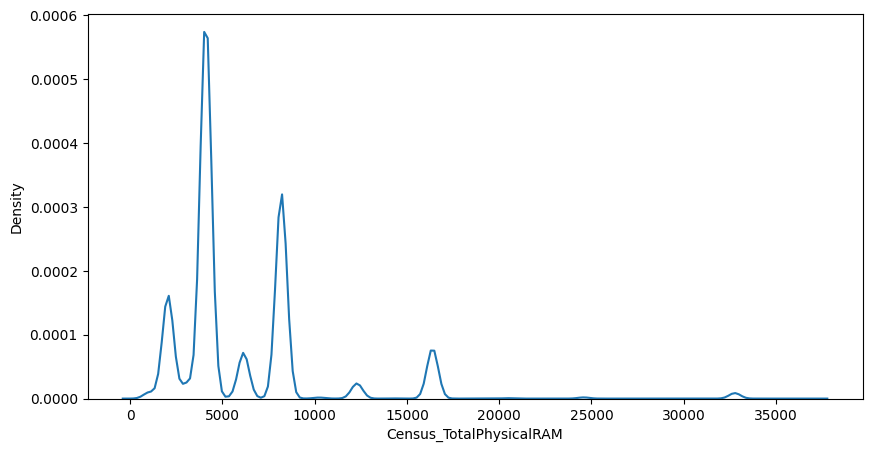

In [ ]:
plt.figure(figsize = [10,5])
sns.kdeplot(MMP10['Census_TotalPhysicalRAM'])

In [ ]:
# Variable candidata para aplicar MinMaxScaler en fase preprocesamiento

columnas_MinMaxS.add('Census_TotalPhysicalRAM')

### Census_ChassisTypeName

Valores nulos:  37


(Notebook               294232
 Desktop                104979
 Laptop                  38261
 Portable                20181
 AllinOne                11407
 MiniTower                4849
 Convertible              4685
 Other                    4215
 UNKNOWN                  3695
 Detachable               2930
 LowProfileDesktop        2878
 HandHeld                 2652
 SpaceSaving              1689
 Tablet                    730
 Tower                     692
 Unknown                   575
 MainServerChassis         512
 MiniPC                    261
 LunchBox                  224
 RackMountChassis          189
 SubNotebook                47
 BusExpansionChassis        38
 30                         11
 StickPC                     7
 0                           5
 MultisystemChassis          3
 35                          3
 PizzaBox                    3
 Blade                       3
 31                          2
 SubChassis                  2
 32                          1
 Expansi

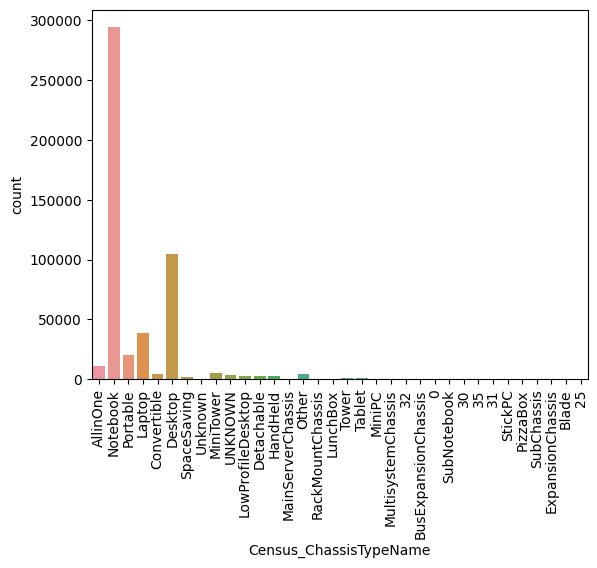

In [ ]:
cat_exploratory(MMP10, 'Census_ChassisTypeName')

In [ ]:
# Distribucion muy desbalanceada. Agruparemos las labels minoritarias en 'Others'

In [ ]:
def agruparOthers(dataframe, column, num_values):
    top_categories = dataframe[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    dataframe[column] = pd.Categorical(dataframe[column], categories=top_categories_list)
    return dataframe[column].fillna('Others')

In [ ]:
MMP10['Census_ChassisTypeNameG'] = agruparOthers(MMP10, 'Census_ChassisTypeName', 7)

In [ ]:
MMP10['Census_ChassisTypeNameG'].fillna('Others')

0            AllinOne
1            Notebook
2            Notebook
3            Notebook
4            Portable
             ...     
499995    Convertible
499996         Laptop
499997      MiniTower
499998       Notebook
499999        Desktop
Name: Census_ChassisTypeNameG, Length: 500000, dtype: category
Categories (8, object): ['Notebook', 'Desktop', 'Laptop', 'Portable', 'AllinOne', 'MiniTower',
                         'Convertible', 'Others']

Valores nulos:  0


(Notebook       294232
 Desktop        104979
 Laptop          38261
 Others          21406
 Portable        20181
 AllinOne        11407
 MiniTower        4849
 Convertible      4685
 Name: Census_ChassisTypeNameG, dtype: int64,
 None)

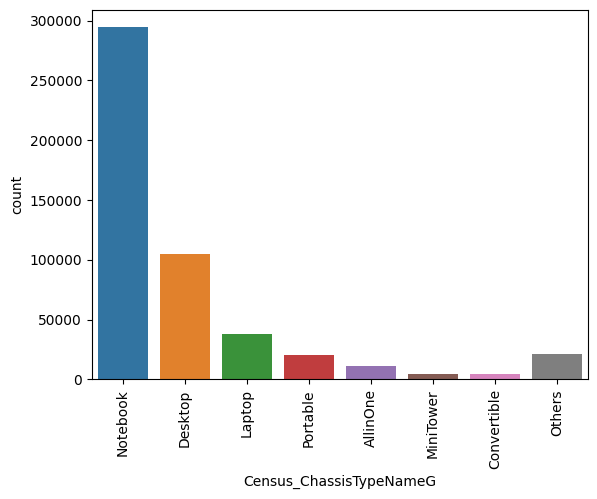

In [ ]:
cat_exploratory(MMP10, 'Census_ChassisTypeNameG')

In [ ]:
# Variable candidata para OHE
columnas_antiguas_eliminar.add('Census_ChassisTypeName')

columnas_OHE.add('Census_ChassisTypeNameG')

### Census_InternalPrimaryDiagonalDisplaySizeInInches


In [ ]:
MMP10['Census_InternalPrimaryDiagonalDisplaySizeInInches'].describe()

count    497346.000000
mean         16.689837
std           5.932014
min           4.900000
25%          13.900000
50%          15.500000
75%          17.200000
max         142.000000
Name: Census_InternalPrimaryDiagonalDisplaySizeInInches, dtype: float64

In [ ]:
# Transformamos nulos (2654)
nulls_to_mean(MMP10, 'Census_InternalPrimaryDiagonalDisplaySizeInInches')

<Axes: xlabel='Census_InternalPrimaryDiagonalDisplaySizeInInches', ylabel='Density'>

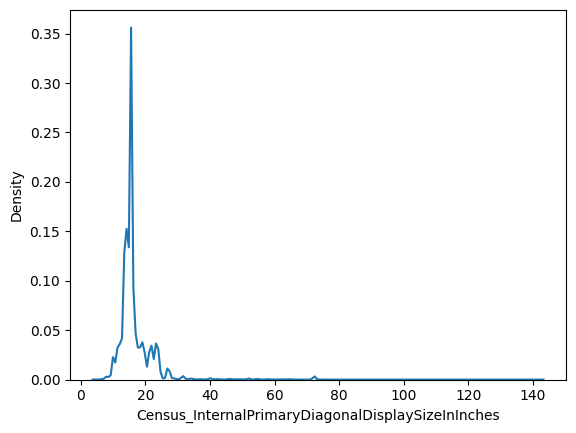

In [ ]:
sns.kdeplot(MMP10['Census_InternalPrimaryDiagonalDisplaySizeInInches'])

In [ ]:
IPDDSmas1Mcount = len(MMP10[MMP10['Census_InternalPrimaryDiagonalDisplaySizeInInches']>60])
IPDDSmenos1Mcount = len(MMP10[MMP10['Census_InternalPrimaryDiagonalDisplaySizeInInches']<60])
IPDDStotalvarcount = len(MMP10['Census_InternalPrimaryDiagonalDisplaySizeInInches'])
print('Con menos de 60 pulgadas hay un porcentaje de', IPDDSmenos1Mcount / IPDDStotalvarcount)

Con menos de 60 pulgadas hay un porcentaje de 0.995422


In [ ]:
print('Estaríamos transformando a la media ', len(MMP10[MMP10['Census_InternalPrimaryDiagonalDisplaySizeInInches']>60])*95/5, ' valores de la muestra completa.')

Estaríamos transformando a la media  43054.0  valores de la muestra completa.


In [ ]:
# Transformamos outliers > 60 a la media

MMP10.loc[MMP10.loc[MMP10['Census_InternalPrimaryDiagonalDisplaySizeInInches'] > 60].index,
          'Census_InternalPrimaryDiagonalDisplaySizeInInches'] = MMP10['Census_InternalPrimaryDiagonalDisplaySizeInInches'].mean()

<Axes: xlabel='Census_InternalPrimaryDiagonalDisplaySizeInInches', ylabel='Density'>

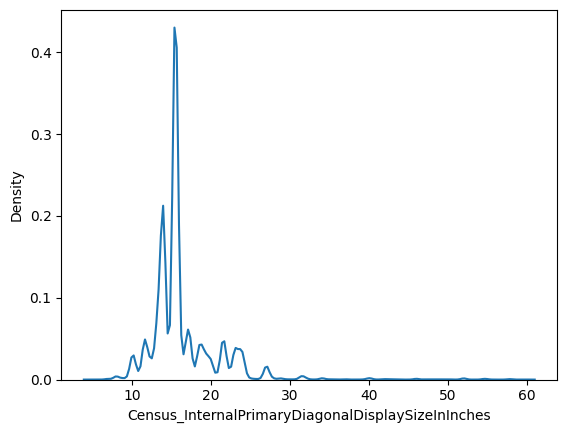

In [ ]:
sns.kdeplot(MMP10['Census_InternalPrimaryDiagonalDisplaySizeInInches'])

In [ ]:
# Variable candidata a aplicar MinMaxScaler en fase preprocesamiento

columnas_MinMaxS.add('Census_InternalPrimaryDiagonalDisplaySizeInInches')

### Census_InternalPrimaryDisplayResolutionHorizontal

In [ ]:
MMP10['Census_InternalPrimaryDisplayResolutionHorizontal'].describe()

count    497350.000000
mean       1548.304317
std         368.565945
min          -1.000000
25%        1366.000000
50%        1366.000000
75%        1920.000000
max       11520.000000
Name: Census_InternalPrimaryDisplayResolutionHorizontal, dtype: float64

In [ ]:
# Transformar nulos (2650) a la media
nulls_to_mean(MMP10,'Census_InternalPrimaryDisplayResolutionHorizontal')

In [ ]:
MMP10['Census_InternalPrimaryDisplayResolutionHorizontal'].astype(int)

0         1920
1         1280
2         1920
3         1920
4         1366
          ... 
499995    1366
499996    1280
499997    1366
499998    1366
499999    1920
Name: Census_InternalPrimaryDisplayResolutionHorizontal, Length: 500000, dtype: int64

<Axes: xlabel='Census_InternalPrimaryDisplayResolutionHorizontal', ylabel='Density'>

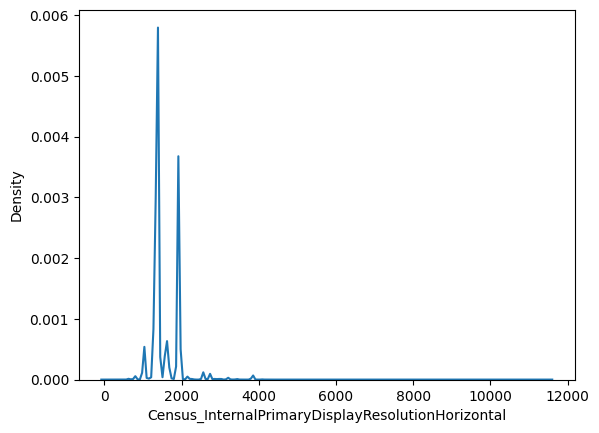

In [ ]:
sns.kdeplot(MMP10['Census_InternalPrimaryDisplayResolutionHorizontal'])

In [ ]:
IPDDSmas1Mcount = len(MMP10[MMP10['Census_InternalPrimaryDisplayResolutionHorizontal']>4000])
IPDDSmenos1Mcount = len(MMP10[MMP10['Census_InternalPrimaryDisplayResolutionHorizontal']<4000])
IPDDStotalvarcount = len(MMP10['Census_InternalPrimaryDisplayResolutionHorizontal'])
print('Con menos de 4000 pixeles hay un porcentaje de', IPDDSmenos1Mcount / IPDDStotalvarcount)

Con menos de 4000 pixeles hay un porcentaje de 0.999464


In [ ]:
print('Estaríamos transformando a la media ', len(MMP10[MMP10['Census_InternalPrimaryDisplayResolutionHorizontal']>4000])*95/5, ' valores de la muestra completa.')

Estaríamos transformando a la media  5092.0  valores de la muestra completa.


In [ ]:
# Transformamos outliers > 4000 a la media

MMP10.loc[MMP10.loc[MMP10['Census_InternalPrimaryDisplayResolutionHorizontal'] > 4000].index,
          'Census_InternalPrimaryDisplayResolutionHorizontal'] = MMP10['Census_InternalPrimaryDisplayResolutionHorizontal'].mean()

<Axes: xlabel='Census_InternalPrimaryDisplayResolutionHorizontal', ylabel='Density'>

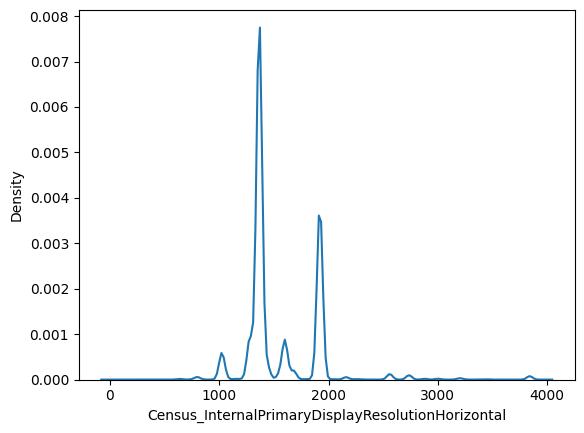

In [ ]:
sns.kdeplot(MMP10['Census_InternalPrimaryDisplayResolutionHorizontal'])

In [ ]:
# Variable candidata a aplicar MinMaxScaler en fase preprocesamiento

columnas_MinMaxS.add('Census_InternalPrimaryDisplayResolutionHorizontal')

### Census_InternalPrimaryDisplayResolutionVertical

In [ ]:
# Esta variable es redundante con las dos anteriores (mismo tipo de informacion, misma distribución). Procedemos a incluirla en la lista de atributos a eliminar.
# Después del MinMaxScaler se decidirá con cual de las dos anteriores nos quedamos.

In [ ]:
columnas_eliminar.add('Census_InternalPrimaryDisplayResolutionVertical')

### Census_PowerPlatformRoleName

Valores nulos:  2


(Mobile               346378
 Desktop              116054
 Slate                 27475
 Workstation            6235
 SOHOServer             2062
 UNKNOWN                1172
 EnterpriseServer        406
 AppliancePC             212
 PerformanceServer         4
 Name: Census_PowerPlatformRoleName, dtype: int64,
 None)

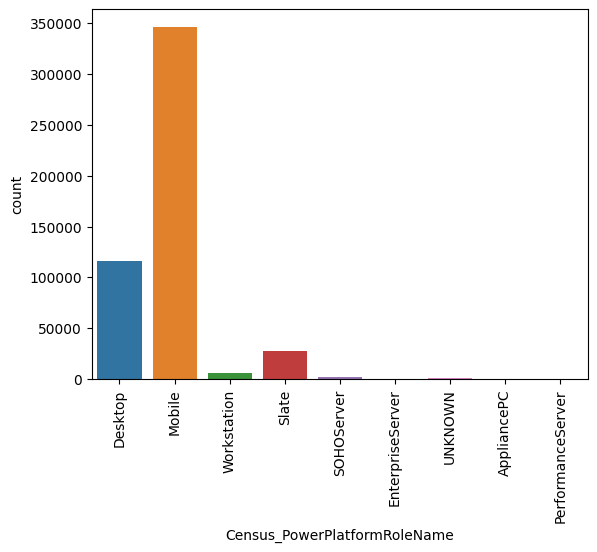

In [ ]:
cat_exploratory(MMP10, 'Census_PowerPlatformRoleName')

In [ ]:
# Variable muy desbalanceada, agrupamos a labels minoritarios a 'Others'

MMP10['Census_PowerPlatformRoleName'] = agruparOthers(MMP10, 'Census_PowerPlatformRoleName', 4)

In [ ]:
# Agrupamos valores nulos a 'Others'
MMP10['Census_PowerPlatformRoleName'].fillna('Others')

0         Desktop
1          Mobile
2          Mobile
3          Mobile
4          Mobile
           ...   
499995     Mobile
499996     Mobile
499997    Desktop
499998     Mobile
499999    Desktop
Name: Census_PowerPlatformRoleName, Length: 500000, dtype: category
Categories (5, object): ['Mobile', 'Desktop', 'Slate', 'Workstation', 'Others']

Valores nulos:  0


(Mobile         346378
 Desktop        116054
 Slate           27475
 Workstation      6235
 Others           3858
 Name: Census_PowerPlatformRoleName, dtype: int64,
 None)

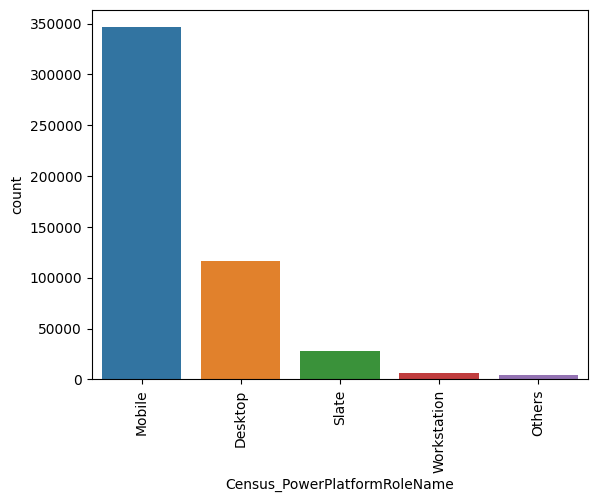

In [ ]:
cat_exploratory(MMP10, 'Census_PowerPlatformRoleName')

In [ ]:
columnas_OHE.add('Census_PowerPlatformRoleName')

### Census_InternalBatteryType

In [ ]:
nulosCIBT = MMP10['Census_InternalBatteryType'].isnull().sum()
muestraCIBT = len(MMP10['Census_InternalBatteryType'])
print('Hay un ', nulosCIBT/muestraCIBT*100, '% de nulos')

Hay un  71.1206 % de nulos


In [ ]:
# Se incluye atributo a la lista de columnas para eliminar

columnas_eliminar.add('Census_InternalBatteryType')

### Census_InternalBatteryNumberOfCharges

In [ ]:
MMP10['Census_InternalBatteryNumberOfCharges'].describe()

count    4.849620e+05
mean     1.125600e+09
std      1.888768e+09
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      4.294967e+09
max      4.294967e+09
Name: Census_InternalBatteryNumberOfCharges, dtype: float64

In [ ]:
nulosCIBNC = MMP10['Census_InternalBatteryNumberOfCharges'].isnull().sum()
muestraCIBNC = len(MMP10['Census_InternalBatteryNumberOfCharges'])
print('Hay un ', nulosCIBNC/muestraCIBNC*100, '% de nulos')

Hay un  3.0076 % de nulos


<Axes: xlabel='Census_InternalBatteryNumberOfCharges', ylabel='Density'>

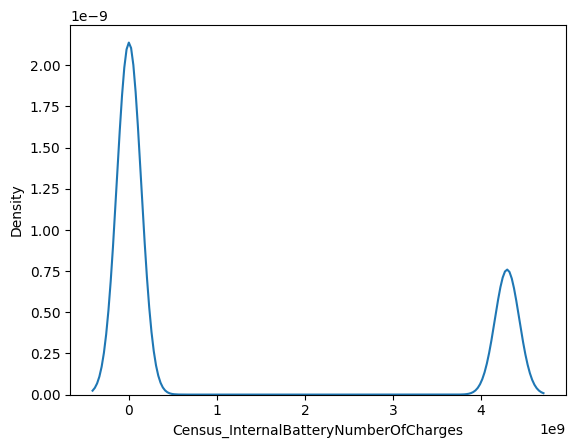

In [ ]:
sns.kdeplot(MMP10['Census_InternalBatteryNumberOfCharges'])

In [ ]:
nulls_to_mean(MMP10, 'Census_InternalBatteryNumberOfCharges')

In [ ]:
# Esta variable es candidata para aplicar MinMaxScaler en la fase de preprocesamiento

columnas_MinMaxS.add('Census_InternalBatteryNumberOfCharges')

### Census_OSVersion

In [ ]:
MMP10['Census_OSVersion'].value_counts()

10.0.17134.228     79975
10.0.17134.165     50511
10.0.16299.431     30519
10.0.17134.285     26289
10.0.17134.112     19501
                   ...  
10.0.18214.1000        1
10.0.15019.1000        1
10.0.14328.1000        1
10.0.10586.601         1
10.0.15048.0           1
Name: Census_OSVersion, Length: 305, dtype: int64

In [ ]:
def agrupar_7caract(valor):
    return valor[:7]

In [ ]:
# Agrupamos las versiones en los 5 primeros valores
MMP10['Census_OSVersion_GROUPED'] = MMP10['Census_OSVersion'].apply(agrupar_7caract)
MMP10["Census_OSVersion_GROUPED"].value_counts().sort_index()

10.0.10     48299
10.0.11         1
10.0.14     43710
10.0.15     44265
10.0.16    136574
10.0.17    227107
10.0.18        43
6.3.960         1
Name: Census_OSVersion_GROUPED, dtype: int64

In [ ]:
MMP10['Census_OSVersion_GROUPED'] = MMP10['Census_OSVersion_GROUPED'].replace({'10.0.11':'Other_version','10.0.18': 'Other_version', '6.3.960': 'Other_version'})

In [ ]:
MMP10["Census_OSVersion_GROUPED"].value_counts().sort_index()

10.0.10           48299
10.0.14           43710
10.0.15           44265
10.0.16          136574
10.0.17          227107
Other_version        45
Name: Census_OSVersion_GROUPED, dtype: int64

Valores nulos:  0


(10.0.17          227107
 10.0.16          136574
 10.0.10           48299
 10.0.15           44265
 10.0.14           43710
 Other_version        45
 Name: Census_OSVersion_GROUPED, dtype: int64,
 None)

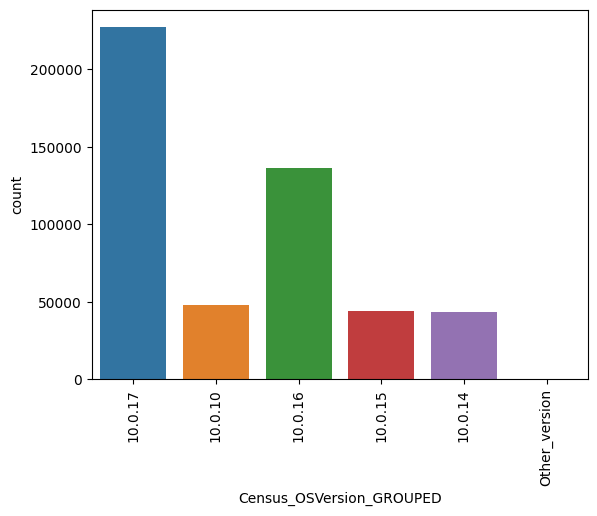

In [ ]:
cat_exploratory(MMP10, "Census_OSVersion_GROUPED")

In [ ]:
# Candidata para OHE
columnas_antiguas_eliminar.add('Census_OSVersion')
columnas_OHE.add('Census_OSVersion_GROUPED')

### Census_OSArchitecture







Valores nulos:  0


(amd64    454435
 x86       45551
 arm64        14
 Name: Census_OSArchitecture, dtype: int64,
 None)

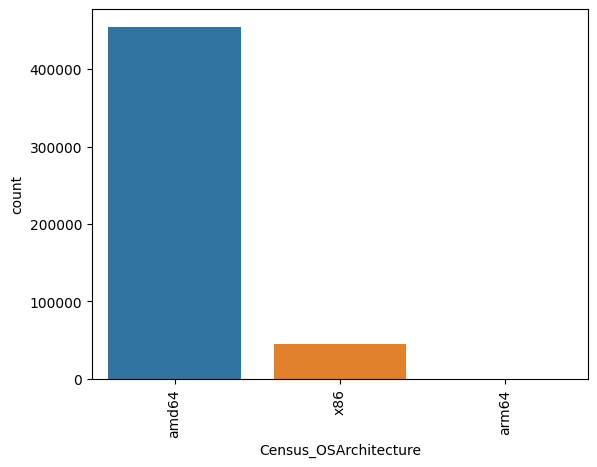

In [ ]:
cat_exploratory(MMP10, 'Census_OSArchitecture')

In [ ]:
# Este atributo lo eliminamos ya que es redundante con OSProcessador

In [ ]:
columnas_eliminar.add('Census_OSArchitecture')

### Census_OSBranch

Valores nulos:  0


(rs4_release                  226001
 rs3_release                   69216
 rs3_release_svc_escrow        67027
 rs2_release                   44264
 rs1_release                   43705
 th2_release                   18298
 th2_release_sec               14895
 th1_st1                       10822
 th1                            4284
 rs5_release                     839
 rs3_release_svc_escrow_im       329
 rs_prerelease                   184
 rs_prerelease_flt               132
 rs5_release_sigma                 3
 winblue_ltsb_escrow               1
 Name: Census_OSBranch, dtype: int64,
 None)

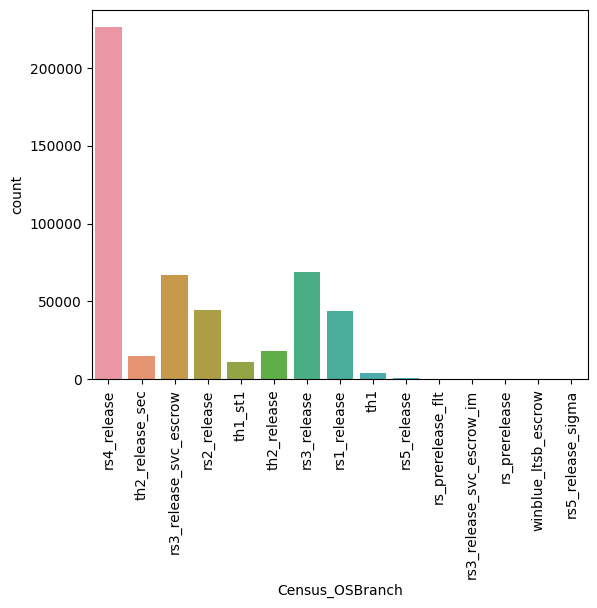

In [ ]:
cat_exploratory(MMP10, 'Census_OSBranch')

In [ ]:
# Creamos función para agrupar valores en función de similitud y valores minoritatios
def englobar_categoria(valor):
    if valor.startswith("rs1_release"):
        return "rs1_release"
    elif valor.startswith("rs2_release"):
        return "rs2_release"
    elif valor.startswith("rs3_release"):
        return "rs3_release"
    elif valor.startswith("rs4_release"):
        return "rs4_release"
    elif valor.startswith("rs5_release"):
        return "Others"
    elif valor.startswith("th2_release"):
        return "th2_release"
    elif valor.startswith("th1"):
        return "Others"
    elif valor.startswith("rs_prerelease"):
        return "Others"
    else:
        return valor

Valores nulos:  0


(rs4_release            226001
 rs3_release            136572
 rs2_release             44264
 rs1_release             43705
 th2_release             33193
 Others                  16264
 winblue_ltsb_escrow         1
 Name: Census_OSBranch_grouped, dtype: int64,
 None)

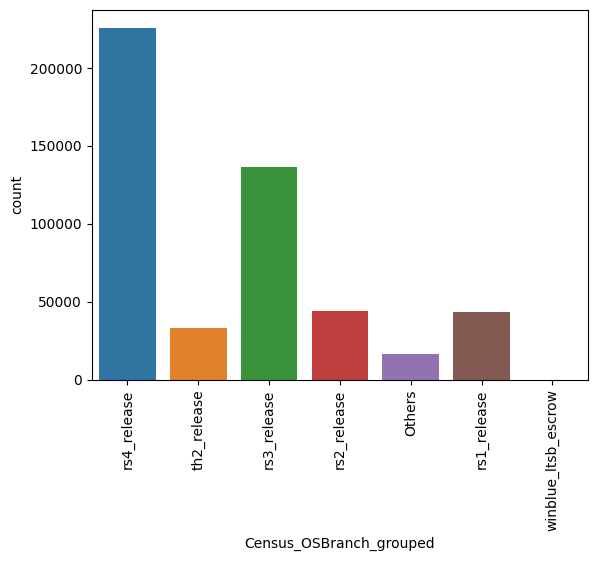

In [ ]:
MMP10["Census_OSBranch_grouped"] = MMP10["Census_OSBranch"].apply(englobar_categoria)
cat_exploratory(MMP10,"Census_OSBranch_grouped")

In [ ]:
# Variable candidata ara OHE

columnas_antiguas_eliminar.add('Census_OSBranch')
columnas_OHE.add("Census_OSBranch_grouped")

### Census_OSBuildNumber

Valores nulos:  0


(17134    225979
 16299    136572
 15063     44262
 14393     43702
 10586     33193
           ...  
 9600          1
 17074         1
 17753         1
 15042         1
 15048         1
 Name: Census_OSBuildNumber, Length: 61, dtype: int64,
 None)

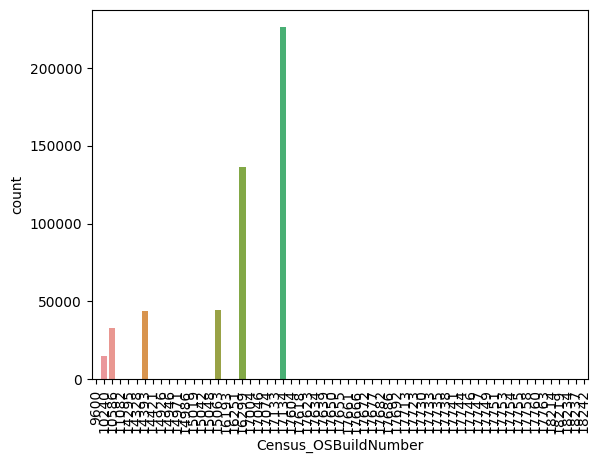

In [ ]:
cat_exploratory(MMP10, 'Census_OSBuildNumber')

Valores nulos:  0


(17134     225979
 16299     136572
 Others     49485
 15063      44262
 14393      43702
 Name: Census_OSBuildNumberGROUPED, dtype: int64,
 None)

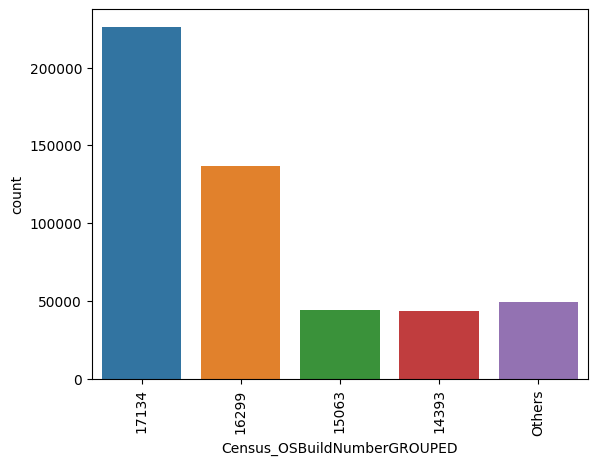

In [ ]:
# Agrupamos categoria 'Others' los poco frecuentes
MMP10['Census_OSBuildNumberGROUPED'] = agruparOthers(MMP10, 'Census_OSBuildNumber', 4)

cat_exploratory(MMP10, 'Census_OSBuildNumberGROUPED')


In [ ]:
# Candidata para OHE

columnas_OHE.add('Census_OSBuildNumberGROUPED')

columnas_antiguas_eliminar.add('Census_OSBuildNumber')


### Census_OSBuildRevision

In [ ]:
MMP10['Census_OSBuildRevision'].nunique()

242

In [ ]:
MMP10['Census_OSBuildRevision'].value_counts().sort_values(ascending= False).to_frame()

Census_OSBuildRevision
228                     79975
165                     50511
431                     30519
285                     26289
112                     19503
...                       ...
281                         1
448                         1
1670                        1
456                         1
16399                       1

[242 rows x 1 columns]

In [ ]:
# Agrupamos valores minoritarios

MMP10['Census_OSBuildRevisionGROUPED'] = agruparOthers(MMP10, 'Census_OSBuildRevision', 37)


In [ ]:
MMP10['Census_OSBuildRevision'].isnull().sum()

71449

In [ ]:
# Segun parece, esta variable es categorica ordinal, a medida que se hacern revisiones y/o cambios en una version del sistema operativa el numero aumenta. Variable candidata para OrdinalEncoder
# (Este numero también está incluido en la numeracion de la version del sistema operativo. Probablemente será redundante)

columnas_OrdEnc.add('Census_OSBuildRevisionGROUPED')

columnas_antiguas_eliminar.add('Census_OSBuildRevision')


### Census_OSEdition

Valores nulos:  0


(Core                        194469
 Professional                175808
 CoreSingleLanguage          108696
 CoreCountrySpecific           9275
 ProfessionalEducation         3100
 Education                     2310
 Enterprise                    2055
 ProfessionalN                 1624
 EnterpriseS                   1108
 ServerStandard                 584
 Cloud                          336
 CoreN                          251
 ServerStandardEval             151
 EducationN                      61
 ServerDatacenterEval            47
 EnterpriseSN                    47
 ServerSolution                  34
 EnterpriseN                     28
 ProfessionalEducationN          12
 ProfessionalWorkstation          2
 CloudN                           1
 ProfessionalWorkstationN         1
 Name: Census_OSEdition, dtype: int64,
 None)

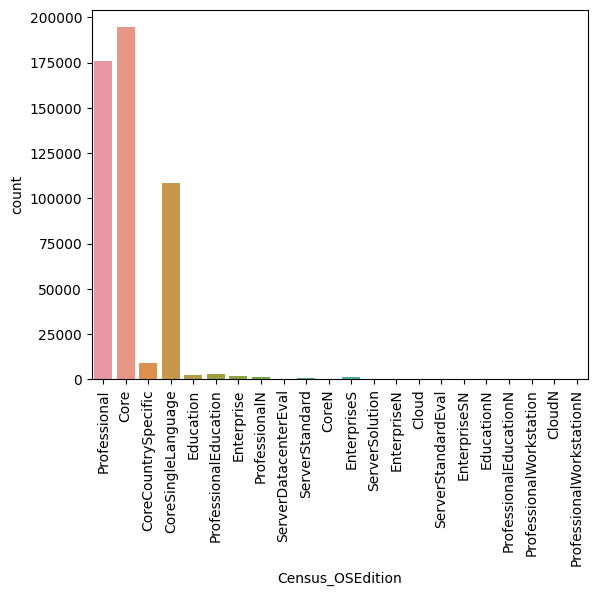

In [ ]:
cat_exploratory(MMP10, 'Census_OSEdition')

In [ ]:
# Vamos a crear una funcion que elimine la letra final -N de todas aquellas categorias que la contengan, de manera que que cuando se ejecute el codigo en el df final tambien modifique aquellas que no aparecen en la version reducida

def eliminar_N_final(df, columna):
    df[columna] = df[columna].str.rstrip('N')
    return df

In [ ]:
eliminar_N_final(MMP10, 'Census_OSEdition')
MMP10['Census_OSEdition'].value_counts()

Core                       194720
Professional               177432
CoreSingleLanguage         108696
CoreCountrySpecific          9275
ProfessionalEducation        3112
Education                    2371
Enterprise                   2083
EnterpriseS                  1155
ServerStandard                584
Cloud                         337
ServerStandardEval            151
ServerDatacenterEval           47
ServerSolution                 34
ProfessionalWorkstation         3
Name: Census_OSEdition, dtype: int64

In [ ]:
# Agrupamos categorias similares y categorias minoritarias

MMP10['Census_OSEditionGROUPED'] = MMP10['Census_OSEdition'].replace({'ProfessionalWorkstation':'Professional', 'ServerDatacenterEval': 'Others', 'EnterpriseS': 'Others',
                                                                      'ServerSolution': 'Others', 'ServerStandardEval': 'Others', 'Cloud': 'Others', 'Education': 'Others',
                                                                      'ProfessionalEducation':'Others', 'ServerStandard': 'Others'
                                })

Valores nulos:  0


(Core                   194720
 Professional           177435
 CoreSingleLanguage     108696
 CoreCountrySpecific      9275
 Others                   7791
 Enterprise               2083
 Name: Census_OSEditionGROUPED, dtype: int64,
 None)

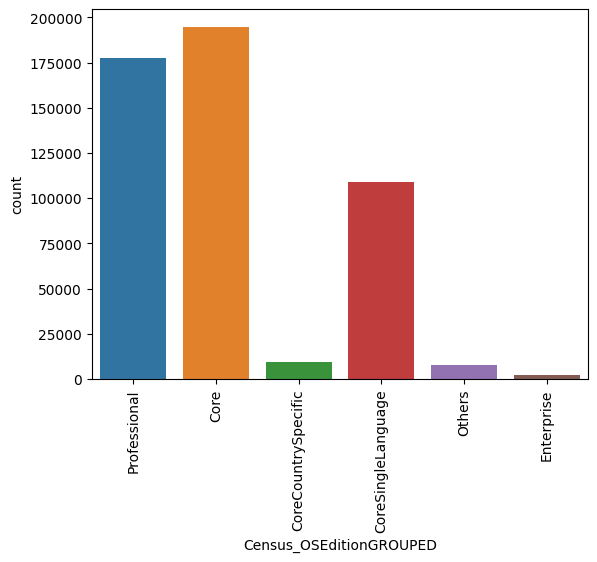

In [ ]:
cat_exploratory(MMP10,'Census_OSEditionGROUPED')

In [ ]:
# Variable candidata para OHE

columnas_OHE.add('Census_OSEditionGROUPED')
columnas_antiguas_eliminar.add('Census_OSEdition')

### Census_OSSkuName

Valores nulos:  0


(CORE                            194464
 PROFESSIONAL                    178947
 CORE_SINGLELANGUAGE             108674
 CORE_COUNTRYSPECIFIC              9257
 EDUCATION                         2313
 ENTERPRISE                        2063
 PROFESSIONAL_N                    1634
 ENTERPRISE_S                      1107
 STANDARD_SERVER                    584
 CLOUD                              332
 CORE_N                             251
 STANDARD_EVALUATION_SERVER         151
 EDUCATION_N                         61
 ENTERPRISE_S_N                      48
 DATACENTER_EVALUATION_SERVER        47
 SB_SOLUTION_SERVER                  34
 ENTERPRISE_N                        28
 PRO_WORKSTATION                      2
 CLOUDN                               1
 PRO_WORKSTATION_N                    1
 UNLICENSED                           1
 Name: Census_OSSkuName, dtype: int64,
 None)

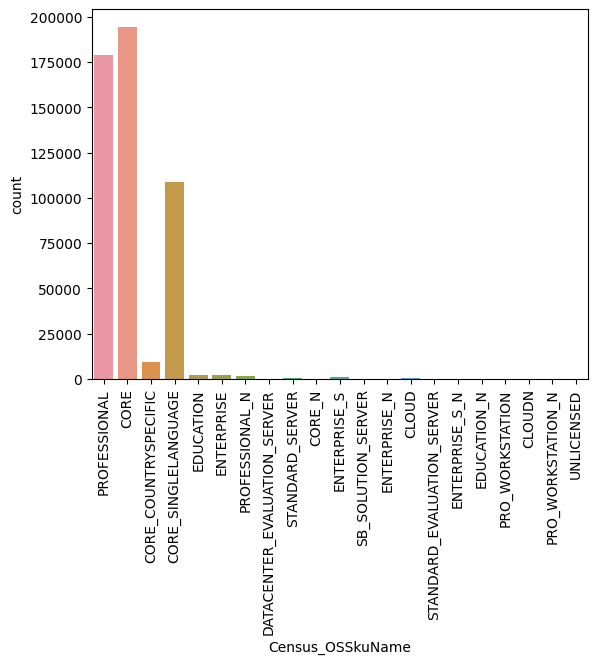

In [ ]:
cat_exploratory(MMP10, 'Census_OSSkuName')

In [ ]:
# Atributo redundante con el anterior. Añadimos a la lista para eliminar

columnas_eliminar.add('Census_OSSkuName')

### Census_OSInstallTypeName

Valores nulos:  0


(UUPUpgrade        146780
 IBSClean           92403
 Update             88892
 Upgrade            70013
 Other              46960
 Reset              36510
 Refresh            11540
 Clean               3885
 CleanPCRefresh      3017
 Name: Census_OSInstallTypeName, dtype: int64,
 None)

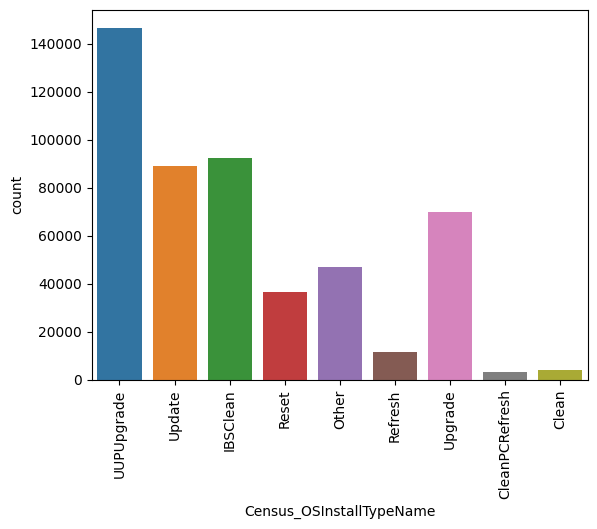

In [ ]:
cat_exploratory(MMP10,'Census_OSInstallTypeName')

In [ ]:
# Candidato para OHE
columnas_OHE.add('Census_OSInstallTypeName')

###Wdft_RegionIdentifier

In [ ]:
MMP10['Wdft_RegionIdentifier']

0         11.0
1          3.0
2         15.0
3         15.0
4         13.0
          ... 
499995    10.0
499996    15.0
499997     8.0
499998     1.0
499999     4.0
Name: Wdft_RegionIdentifier, Length: 500000, dtype: float64

In [ ]:
MMP10['Wdft_RegionIdentifier'].value_counts()

10.0    100392
11.0     75612
3.0      73069
1.0      68692
15.0     57346
7.0      33362
8.0      15761
13.0     12681
5.0      11466
12.0      9115
6.0       8750
4.0       7586
9.0       4521
2.0       4470
14.0       227
Name: Wdft_RegionIdentifier, dtype: int64

En la documentación no se conoce que hace esta variable, a riesgo de meter ruido la borramos

In [ ]:
columnas_eliminar.add('Wdft_RegionIdentifier')
columnas_eliminar

{'AVProductsEnabled',
 'AutoSampleOptIn',
 'Census_DeviceFamily',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryType',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_OEMModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OSArchitecture',
 'Census_OSSkuName',
 'Census_ProcessorClass',
 'Census_ProcessorModelIdentifier',
 'DefaultBrowsersIdentifier',
 'GeoNameIdentifier',
 'HasTpm',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'OsBuildLab',
 'ProductName',
 'PuaMode',
 'RtpStateBitfield',
 'SMode',
 'UacLuaenable',
 'Wdft_RegionIdentifier'}

### Wdft_IsGamer: Si viene de un sistema de videojuegos

In [ ]:
MMP10['Wdft_IsGamer'].describe()

count    483050.000000
mean          0.284060
std           0.450966
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: Wdft_IsGamer, dtype: float64

In [ ]:
MMP10['Wdft_IsGamer'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: Wdft_IsGamer
Non-Null Count   Dtype  
--------------   -----  
483050 non-null  float64
dtypes: float64(1)
memory usage: 3.8 MB


In [ ]:
MMP10['Wdft_IsGamer'].value_counts()

0.0    345835
1.0    137215
Name: Wdft_IsGamer, dtype: int64

In [ ]:
MMP10['Wdft_IsGamer'].isnull().sum()

16950

In [ ]:
MMP10[MMP10['Wdft_IsGamer'].isnull()]

Unnamed: 0                 MachineIdentifier   ProductName  \
19         2797061  503ff9f5e17315afd880eb6745316439  win8defender   
90         5780477  a5eaa9f0f5c54e6e356c1aa644f387b9  win8defender   
93         5540530  9f0b0a2255f3efcce0fb5bbbc87c4844  win8defender   
113        5171730  9469b98aaa92c90c4fa4581be51597d8  win8defender   
126        2064664  3b40e86d43c362611d8c04466b4580bc  win8defender   
...            ...                               ...           ...   
499883     7631531  daf88544489b70291a818cf79b952f46  win8defender   
499911     5601054  a0c5240ea1987eef7818f048e3208e8c  win8defender   
499957     2025824  3a23b8b90dae55d291338aa13d0aa179  win8defender   
499977     5354306  99ab8ff0c6d6b347d8a4ce3141f5f225  win8defender   
499979     5253164  96c417e49191b49f11c51314fe27e5c4  win8defender   

       EngineVersion       AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  \
19       1.1.15200.1  4.18.1807.18075   1.275.948.0       0               7.0   
90       1.1.15200.1     4.10.14393.0   1.275.260.0       0               7.0   
93       1.1.15200.1  4.18.1807.18075   1.275.941.0       0               7.0   
113      1.1.14600.4     4.13.17134.1    1.263.48.0       0               7.0   
126      1.1.15200.1  4.18.1807.18075   1.275.877.0       0               7.0   
...              ...              ...           ...     ...               ...   
499883   1.1.15200.1   4.13.17134.228   1.275.988.0       0               7.0   
499911   1.1.15100.1  4.18.1806.18062   1.273.488.0       0               7.0   
499957   1.1.14600.4     4.13.17134.1    1.263.48.0       0               7.0   
499977   1.1.15200.1  4.18.1807.18075   1.275.919.0       0               7.0   
499979   1.1.15200.1  4.18.1807.18075  1.275.1140.0       0               7.0   

        IsSxsPassiveMode  DefaultBrowsersIdentifier  ...  \
19                     0                        NaN  ...   
90                     0                        NaN  ...   
93                     0                        NaN  ...   
113                    0                        NaN  ...   
126                    0                        NaN  ...   
...                  ...                        ...  ...   
499883                 0                        NaN  ...   
499911                 0                        NaN  ...   
499957                 0                        NaN  ...   
499977                 0                        NaN  ...   
499979                 0                        NaN  ...   

        OrganizationIdentifierT  Processor_x64  OsVer10  \
19                        Otros              0       10   
90                        Otros              1       10   
93                        Otros              1       10   
113                        18.0              1       10   
126                        27.0              1       10   
...                         ...            ...      ...   
499883                     27.0              1       10   
499911                     27.0              1       10   
499957                     27.0              1       10   
499977                     27.0              1       10   
499979                    Otros              0       10   

        IeVerIdentifier_grouped Census_ChassisTypeNameG  \
19                        117.0                 Desktop   
90                       others                 Desktop   
93                        137.0                Notebook   
113                       137.0                 Desktop   
126                       137.0                Notebook   
...                         ...                     ...   
499883                    137.0                AllinOne   
499911                    117.0                Notebook   
499957                    137.0                AllinOne   
499977                    137.0                 Desktop   
499979                    137.0                 Desktop   

       Census_OSVersion_GROUPED Census_OSBranch_grouped

<Axes: xlabel='HasDetections', ylabel='count'>

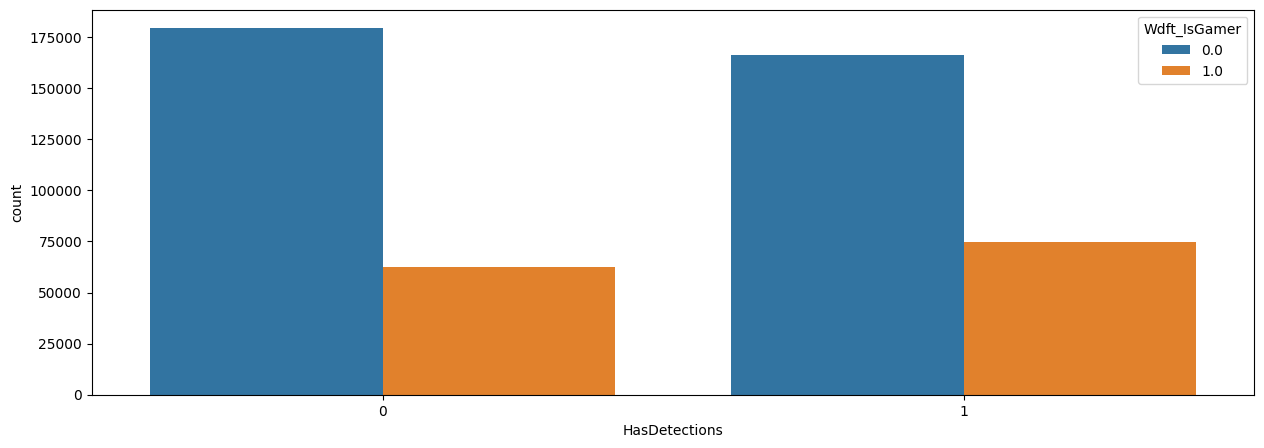

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(data=MMP10, x=TARGET, hue='Wdft_IsGamer')    #observamos

SE imputan nulos LOS NULOS

In [ ]:
#imputamos nulos con 'ffill'

MMP10['Wdft_IsGamer'].fillna(method="ffill", inplace=True)

### Census_IsAlwaysOnAlwaysConnectedCapable

In [ ]:
MMP10.head(5)

Unnamed: 0                 MachineIdentifier   ProductName EngineVersion  \
0     8427007  f1cd864e97bae82bdf96523e1a539121  win8defender   1.1.15100.1   
1     8829090  fd5ba6f5b75325ec0423a6c67cc75942  win8defender   1.1.15100.1   
2     2731904  4e628391e7cc7c482fb3286f486dbd25  win8defender   1.1.15100.1   
3     1359513  270a2e9d028144a4df12a9e3da79fba5  win8defender   1.1.15200.1   
4      236059  06ca8fa8d32c2abdc5b3577d676b3269  win8defender   1.1.15200.1   

        AppVersion  AvSigVersion  IsBeta  RtpStateBitfield  IsSxsPassiveMode  \
0  4.18.1807.18075  1.273.1234.0       0               7.0                 0   
1  4.18.1807.18075  1.273.1282.0       0               7.0                 0   
2   4.9.10586.1106   1.273.781.0       0               7.0                 0   
3  4.18.1807.18075  1.275.1639.0       0               7.0                 0   
4  4.18.1807.18075   1.275.511.0       0               7.0                 0   

   DefaultBrowsersIdentifier  ...  OrganizationIdentifierT  Processor_x64  \
0                        NaN  ...                    Otros              1   
1                        NaN  ...                    Otros              1   
2                        NaN  ...                     27.0              1   
3                        NaN  ...                     27.0              1   
4                        NaN  ...                     27.0              1   

   OsVer10  IeVerIdentifier_grouped Census_ChassisTypeNameG  \
0       10                    137.0                AllinOne   
1       10                    137.0                Notebook   
2       10                     74.0                Notebook   
3       10                    137.0                Notebook   
4       10                    137.0                Portable   

  Census_OSVersion_GROUPED Census_OSBranch_grouped  \
0                  10.0.17             rs4_release   
1                  10.0.17             rs4_release   
2                  10.0.10             th2_release   
3                  10.0.17             rs4_release   
4                  10.0.17             rs4_release   

   Census_OSBuildNumberGROUPED  Census_OSBuildRevisionGROUPED  \
0                        17134                            165   
1                        17134                            165   
2                       Others                           1176   
3                        17134                            286   
4                        17134                            228   

  Census_OSEditionGROUPED  
0            Professional  
1            Professional  
2                    Core  
3                    Core  
4            Professional  

[5 rows x 101 columns]

In [ ]:
MMP10['Census_IsAlwaysOnAlwaysConnectedCapable'].describe()

count    495960.000000
mean          0.057245
std           0.232310
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Census_IsAlwaysOnAlwaysConnectedCapable, dtype: float64

In [ ]:
MMP10['Census_IsAlwaysOnAlwaysConnectedCapable'].value_counts(normalize=True)

0.0    0.942755
1.0    0.057245
Name: Census_IsAlwaysOnAlwaysConnectedCapable, dtype: float64

In [ ]:
# no tenemos varianza, la eliminamos

columnas_eliminar.add('Census_IsAlwaysOnAlwaysConnectedCapable')
columnas_eliminar

{'AVProductsEnabled',
 'AutoSampleOptIn',
 'Census_DeviceFamily',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryType',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_OEMModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OSArchitecture',
 'Census_OSSkuName',
 'Census_ProcessorClass',
 'Census_ProcessorModelIdentifier',
 'DefaultBrowsersIdentifier',
 'GeoNameIdentifier',
 'HasTpm',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'OsBuildLab',
 'ProductName',
 'PuaMode',
 'RtpStateBitfield',
 'SMode',
 'UacLuaenable',
 'Wdft_RegionIdentifier'}

### Census_IsPenCapable

In [ ]:
MMP10['Census_IsPenCapable'].describe()

count    500000.000000
mean          0.037744
std           0.190577
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Census_IsPenCapable, dtype: float64

In [ ]:
MMP10['Census_IsPenCapable'].value_counts()

0    481128
1     18872
Name: Census_IsPenCapable, dtype: int64

In [ ]:
MMP10['Census_IsPenCapable'].value_counts(normalize=True)

0    0.962256
1    0.037744
Name: Census_IsPenCapable, dtype: float64

In [ ]:
MMP10['Census_IsPenCapable'].isnull().sum()

0

In [ ]:
MMP10[MMP10['Census_IsPenCapable'] == 1]

Unnamed: 0                 MachineIdentifier   ProductName  \
2          2731904  4e628391e7cc7c482fb3286f486dbd25  win8defender   
17         8438263  f2203748ea4c33c38acd8ee26442c35e  win8defender   
29         2074872  3b8beb8d804ccaa953ee1c6e101ad4ec  win8defender   
71         4718320  876ad82333e04faf34cb8fd21e2b4f0f  win8defender   
76         7025862  c9958631447470cac1d4f3d515a65753  win8defender   
...            ...                               ...           ...   
499861     7504029  d74c0930a6a6d511481670ecc9b50ab3  win8defender   
499881     2774085  4f969d93292009e2db654c3762fb5734  win8defender   
499891     2794740  502efdaba16bcb37f522352753f8e579  win8defender   
499908     7823445  e0792a9be3d34db3102a218810b12652  win8defender   
499947     5072441  9191ac7cf41abc7ad19f1ba9ef285848  win8defender   

       EngineVersion        AppVersion  AvSigVersion  IsBeta  \
2        1.1.15100.1    4.9.10586.1106   1.273.781.0       0   
17       1.1.15200.1   4.18.1807.18075  1.275.1429.0       0   
29       1.1.15100.1   4.18.1806.18062   1.273.366.0       0   
71       1.1.15200.1   4.18.1807.18075  1.275.1312.0       0   
76       1.1.15100.1  4.12.17007.18022   1.273.950.0       0   
...              ...               ...           ...     ...   
499861   1.1.15100.1   4.18.1806.18062   1.273.309.0       0   
499881   1.1.14405.2      4.11.15063.0    1.259.16.0       0   
499891   1.1.15200.1  4.12.17007.18022   1.275.877.0       0   
499908   1.1.15100.1   4.18.1807.18075  1.273.1420.0       0   
499947   1.1.14700.5  4.14.17613.18039   1.265.948.0       0   

        RtpStateBitfield  IsSxsPassiveMode  DefaultBrowsersIdentifier  ...  \
2                    7.0                 0                        NaN  ...   
17                   7.0                 0                        NaN  ...   
29                   7.0                 0                        NaN  ...   
71                   7.0                 0                        NaN  ...   
76                   0.0                 1                        NaN  ...   
...                  ...               ...                        ...  ...   
499861               7.0                 0                        NaN  ...   
499881               7.0                 0                      494.0  ...   
499891               7.0                 0                        NaN  ...   
499908               7.0                 0                        NaN  ...   
499947               7.0                 0                        NaN  ...   

        OrganizationIdentifierT  Processor_x64  OsVer10  \
2                          27.0              1       10   
17                        Otros              1       10   
29                         27.0              1       10   
71                         18.0              1       10   
76                         18.0              1       10   
...                         ...            ...      ...   
499861                     27.0              1       10   
499881                     27.0              1       10   
499891                     27.0              1       10   
499908                     27.0              1       10   
499947                     27.0              1       10   

        IeVerIdentifier_grouped Census_ChassisTypeNameG  \
2                          74.0                Notebook   
17                        137.0             Convertible   
29                        137.0                Notebook   
71                        108.0                  Others   
76                        135.0                Notebook   
...                         ...                     ...   
499861                    117.0                Notebook   
499881                   others                Notebook   
499891                    111.0                  Laptop   
499908                    137.0                  Others   
499947                    137.0                  Laptop   

       Census_OSVersion_GROUPED Census_OSBr

In [ ]:
MMP10[['Census_IsPenCapable', TARGET]].corr()


Census_IsPenCapable  HasDetections
Census_IsPenCapable              1.00000       -0.01688
HasDetections                   -0.01688        1.00000

<Axes: xlabel='Census_IsPenCapable', ylabel='count'>

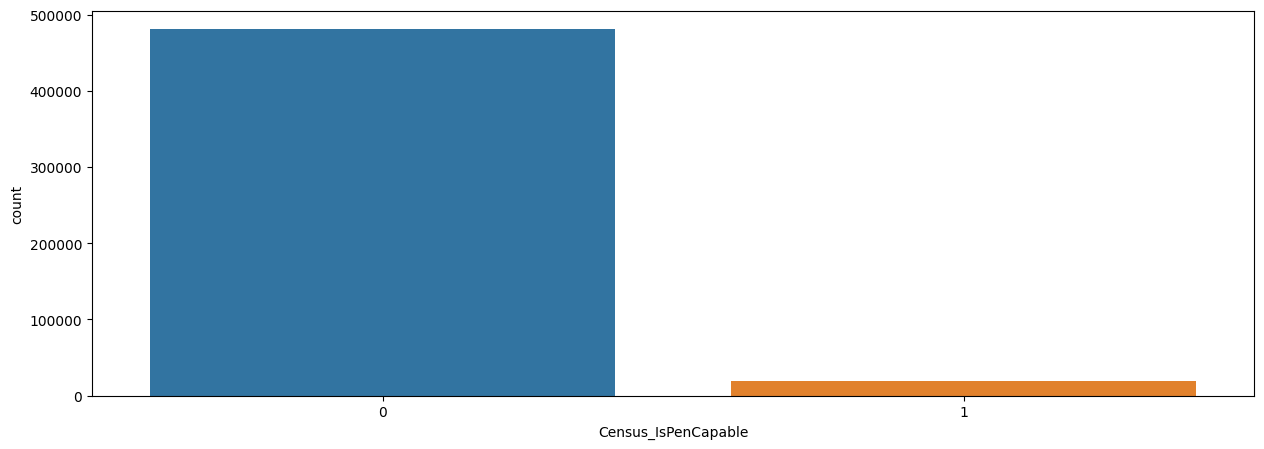

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(data=MMP10, x='Census_IsPenCapable')

SE VALORA ELIMINAR LA VARIABLE

In [ ]:
columnas_eliminar.add('Census_IsPenCapable')
columnas_eliminar

{'AVProductsEnabled',
 'AutoSampleOptIn',
 'Census_DeviceFamily',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryType',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsPenCapable',
 'Census_OEMModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OSArchitecture',
 'Census_OSSkuName',
 'Census_ProcessorClass',
 'Census_ProcessorModelIdentifier',
 'DefaultBrowsersIdentifier',
 'GeoNameIdentifier',
 'HasTpm',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'OsBuildLab',
 'ProductName',
 'PuaMode',
 'RtpStateBitfield',
 'SMode',
 'UacLuaenable',
 'Wdft_RegionIdentifier'}

###Census_IsTouchEnabled

In [ ]:
MMP10['Census_IsTouchEnabled'].value_counts(normalize=True)

0    0.874566
1    0.125434
Name: Census_IsTouchEnabled, dtype: float64

<Axes: xlabel='Census_IsTouchEnabled', ylabel='count'>

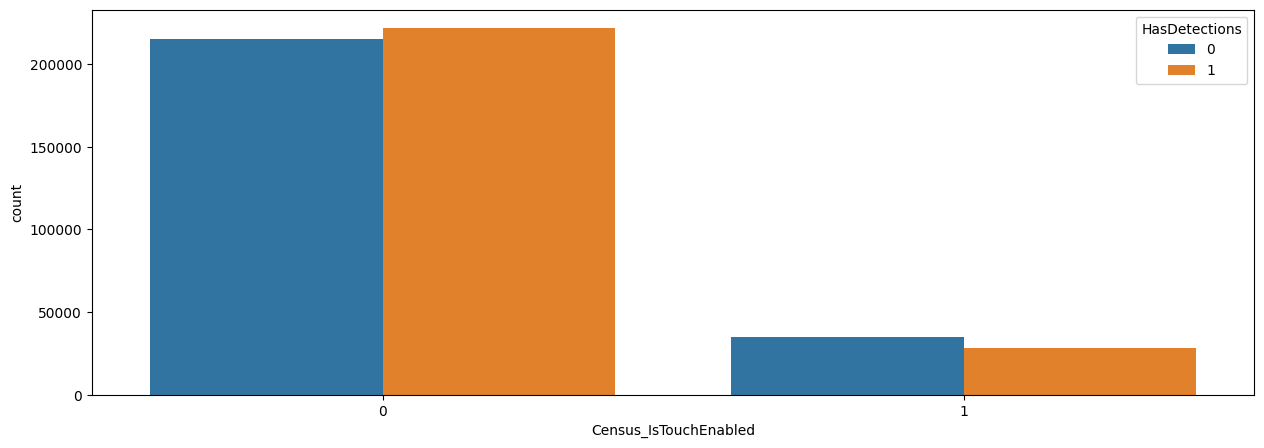

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(data=MMP10, x='Census_IsTouchEnabled', hue=TARGET)

###Census_IsVirtualDevice

In [ ]:
MMP10['Census_IsVirtualDevice'].value_counts()

0.0    495572
1.0      3527
Name: Census_IsVirtualDevice, dtype: int64

In [ ]:
MMP10['Census_IsVirtualDevice'].value_counts(normalize=True)

0.0    0.992933
1.0    0.007067
Name: Census_IsVirtualDevice, dtype: float64

LA ELIMINAMOS, NO PRESENTA VARIANZA

In [ ]:
columnas_eliminar.add('Census_IsVirtualDevice')
columnas_eliminar

{'AVProductsEnabled',
 'AutoSampleOptIn',
 'Census_DeviceFamily',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryType',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsPenCapable',
 'Census_IsVirtualDevice',
 'Census_OEMModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OSArchitecture',
 'Census_OSSkuName',
 'Census_ProcessorClass',
 'Census_ProcessorModelIdentifier',
 'DefaultBrowsersIdentifier',
 'GeoNameIdentifier',
 'HasTpm',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'OsBuildLab',
 'ProductName',
 'PuaMode',
 'RtpStateBitfield',
 'SMode',
 'UacLuaenable',
 'Wdft_RegionIdentifier'}

###Census_IsWIMBootEnabled

In [ ]:
MMP10['Census_IsWIMBootEnabled'].describe()

count    182334.0
mean          0.0
std           0.0
min           0.0
25%           0.0
50%           0.0
75%           0.0
max           0.0
Name: Census_IsWIMBootEnabled, dtype: float64

In [ ]:
MMP10['Census_IsWIMBootEnabled'].value_counts()

0.0    182334
Name: Census_IsWIMBootEnabled, dtype: int64

LA ELIMINAMOS, SOLO TIENE VALOR 0

In [ ]:
columnas_eliminar.add('Census_IsWIMBootEnabled')
columnas_eliminar

{'AVProductsEnabled',
 'AutoSampleOptIn',
 'Census_DeviceFamily',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryType',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsPenCapable',
 'Census_IsVirtualDevice',
 'Census_IsWIMBootEnabled',
 'Census_OEMModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OSArchitecture',
 'Census_OSSkuName',
 'Census_ProcessorClass',
 'Census_ProcessorModelIdentifier',
 'DefaultBrowsersIdentifier',
 'GeoNameIdentifier',
 'HasTpm',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'OsBuildLab',
 'ProductName',
 'PuaMode',
 'RtpStateBitfield',
 'SMode',
 'UacLuaenable',
 'Wdft_RegionIdentifier'}

###Census_IsSecureBootEnabled

In [ ]:
MMP10['Census_IsSecureBootEnabled'].describe()

count    500000.000000
mean          0.485438
std           0.499788
min           0.000000
25%           0.000000
50%           0.000000
75%           1.000000
max           1.000000
Name: Census_IsSecureBootEnabled, dtype: float64

In [ ]:
MMP10['Census_IsSecureBootEnabled'].value_counts(normalize=True)

0    0.514562
1    0.485438
Name: Census_IsSecureBootEnabled, dtype: float64

<Axes: xlabel='Census_IsSecureBootEnabled', ylabel='count'>

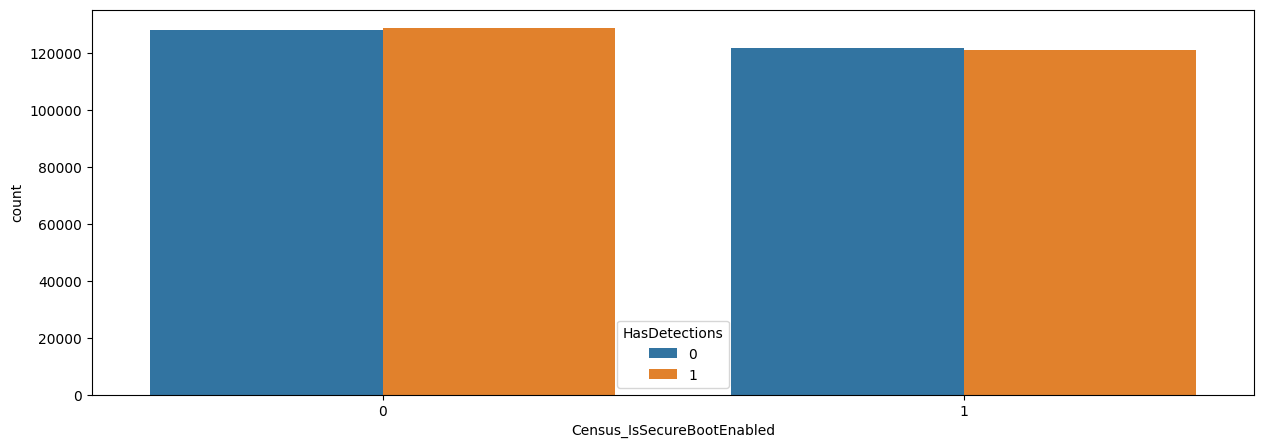

In [ ]:
plt.figure(figsize=(15,5))
sns.countplot(data=MMP10, x='Census_IsSecureBootEnabled', hue=TARGET)

###Census_FirmwareVersionIdentifier

In [ ]:
MMP10['Census_FirmwareVersionIdentifier'].describe()

count    490939.000000
mean      33030.988944
std       21220.161428
min          10.000000
25%       13156.000000
50%       33070.000000
75%       52436.000000
max       72091.000000
Name: Census_FirmwareVersionIdentifier, dtype: float64

In [ ]:
MMP10['Census_FirmwareVersionIdentifier'].isnull().sum()

9061

<Axes: xlabel='Census_FirmwareVersionIdentifier', ylabel='Count'>

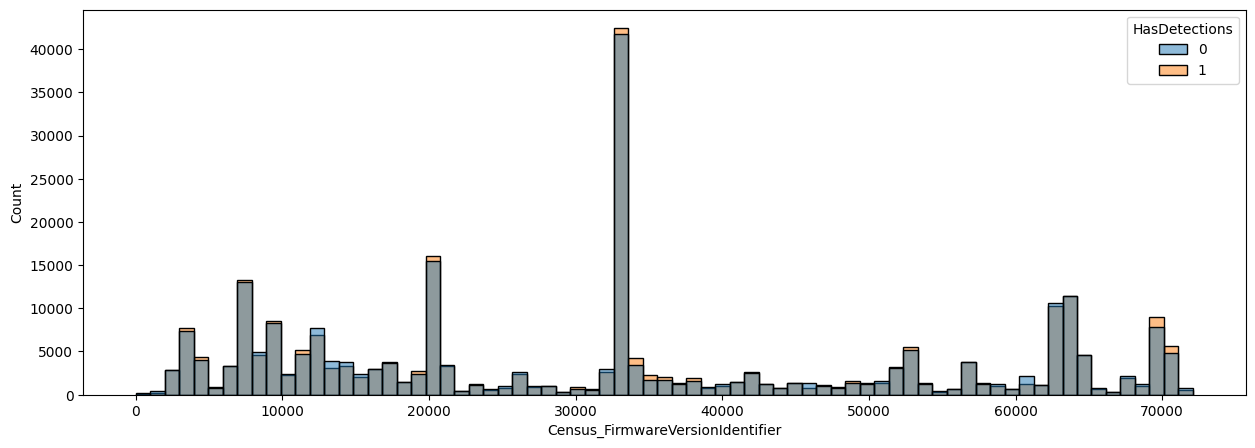

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(x = 'Census_FirmwareVersionIdentifier', hue = TARGET, data = MMP10)

In [ ]:
# Comprobamos ese pico entre 30000 y 40000

seleccion = MMP10[(MMP10['Census_FirmwareVersionIdentifier'] >= 30000) & (MMP10['Census_FirmwareVersionIdentifier'] <= 40000)]

In [ ]:
seleccion['Census_FirmwareVersionIdentifier'].value_counts()

33105.0    5036
33111.0    3356
33054.0    3124
33108.0    3071
33115.0    2882
           ... 
37264.0       1
36154.0       1
36323.0       1
36701.0       1
31502.0       1
Name: Census_FirmwareVersionIdentifier, Length: 3258, dtype: int64

In [ ]:
#rellenamos nulos con la media

mean_firmwareversion = round(MMP10['Census_FirmwareVersionIdentifier'].mean(),0)

MMP10['Census_FirmwareVersionIdentifier'].fillna(mean_firmwareversion, inplace=True)

In [ ]:
#transformamos con MINMAXSCALER

columnas_MinMaxS.add('Census_FirmwareVersionIdentifier')

###Census_FirmwareManufacturerIdentifier

In [ ]:
MMP10['Census_FirmwareManufacturerIdentifier'].describe()

count    489651.000000
mean        402.675943
std         221.527124
min          11.000000
25%         142.000000
50%         500.000000
75%         556.000000
max        1084.000000
Name: Census_FirmwareManufacturerIdentifier, dtype: float64

<Axes: xlabel='Census_FirmwareManufacturerIdentifier', ylabel='Count'>

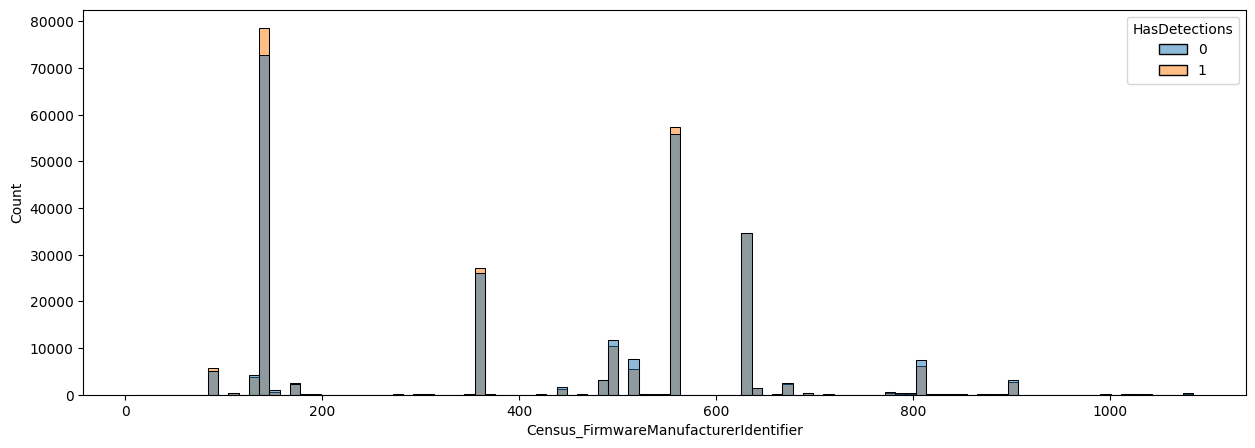

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(x = 'Census_FirmwareManufacturerIdentifier', hue = TARGET, data = MMP10)

In [ ]:
MMP10['Census_FirmwareManufacturerIdentifier'].isnull().sum()

10349

In [ ]:
MMP10['Census_FirmwareManufacturerIdentifier'].mean()

402.67594266120153

In [ ]:
#rellenamos nulos con la media

mean_firmwareversion = round(MMP10['Census_FirmwareManufacturerIdentifier'].mean(),0)

MMP10['Census_FirmwareManufacturerIdentifier'].fillna(mean_firmwareversion, inplace=True)

In [ ]:
#transformamos con MINMAXSCALER

columnas_MinMaxS.add('Census_FirmwareManufacturerIdentifier')

###Census_ThresholdOptIn

In [ ]:
MMP10['Census_ThresholdOptIn'].describe()

count    181896.000000
mean          0.000258
std           0.016072
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Census_ThresholdOptIn, dtype: float64

In [ ]:
MMP10['Census_ThresholdOptIn'].value_counts(normalize=True)

0.0    0.999742
1.0    0.000258
Name: Census_ThresholdOptIn, dtype: float64

<Axes: xlabel='Census_ThresholdOptIn', ylabel='Count'>

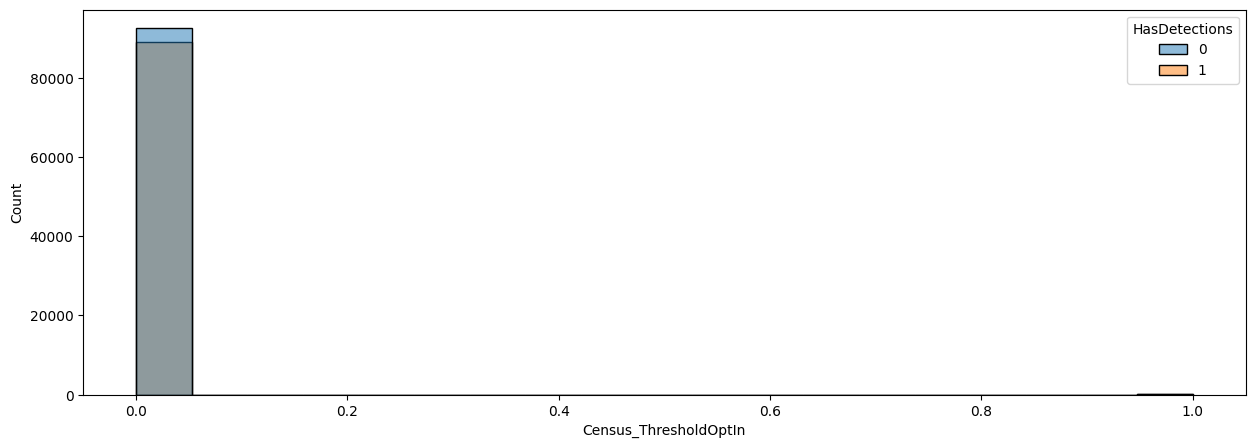

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(x = 'Census_ThresholdOptIn', hue = TARGET, data = MMP10)

In [ ]:
columnas_eliminar.add('Census_ThresholdOptIn')
columnas_eliminar

{'AVProductsEnabled',
 'AutoSampleOptIn',
 'Census_DeviceFamily',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryType',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsPenCapable',
 'Census_IsVirtualDevice',
 'Census_IsWIMBootEnabled',
 'Census_OEMModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OSArchitecture',
 'Census_OSSkuName',
 'Census_ProcessorClass',
 'Census_ProcessorModelIdentifier',
 'Census_ThresholdOptIn',
 'DefaultBrowsersIdentifier',
 'GeoNameIdentifier',
 'HasTpm',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'OsBuildLab',
 'ProductName',
 'PuaMode',
 'RtpStateBitfield',
 'SMode',
 'UacLuaenable',
 'Wdft_RegionIdentifier'}

###Census_FlightRing

In [ ]:
MMP10['Census_FlightRing'].describe()

count     500000
unique         8
top       Retail
freq      468299
Name: Census_FlightRing, dtype: object

In [ ]:
MMP10['Census_FlightRing'].isnull().sum()

0

In [ ]:
MMP10['Census_FlightRing'].value_counts(normalize=True)

Retail      0.936598
NOT_SET     0.032088
Unknown     0.027402
WIS         0.001212
RP          0.001166
WIF         0.001098
Disabled    0.000434
OSG         0.000002
Name: Census_FlightRing, dtype: float64

<Axes: xlabel='Census_FlightRing', ylabel='Count'>

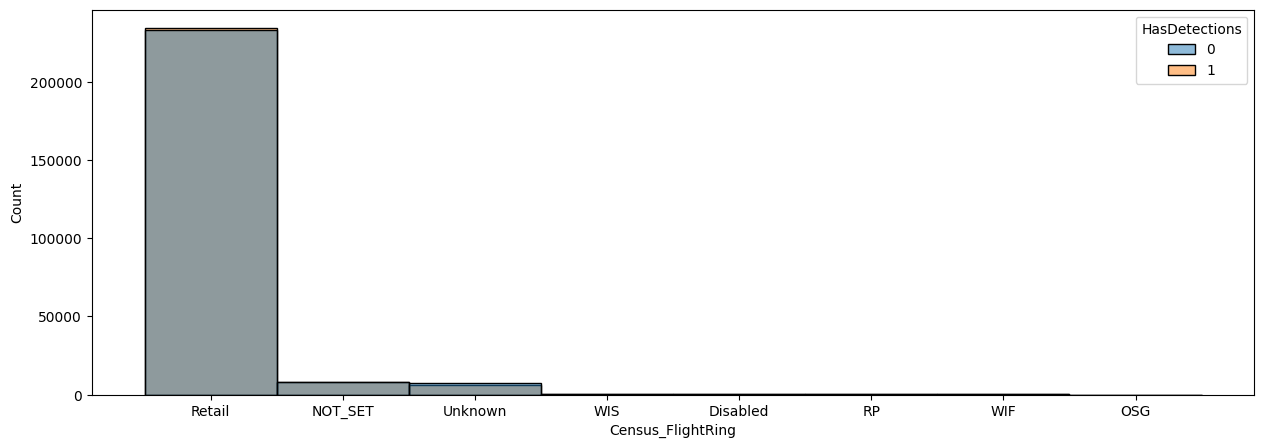

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(x = 'Census_FlightRing', hue = TARGET, data = MMP10)

In [ ]:
#eliminamos la columna no aporta varianza

columnas_eliminar.add('Census_FlightRing')
columnas_eliminar

{'AVProductsEnabled',
 'AutoSampleOptIn',
 'Census_DeviceFamily',
 'Census_FlightRing',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryType',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsPenCapable',
 'Census_IsVirtualDevice',
 'Census_IsWIMBootEnabled',
 'Census_OEMModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OSArchitecture',
 'Census_OSSkuName',
 'Census_ProcessorClass',
 'Census_ProcessorModelIdentifier',
 'Census_ThresholdOptIn',
 'DefaultBrowsersIdentifier',
 'GeoNameIdentifier',
 'HasTpm',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'OsBuildLab',
 'ProductName',
 'PuaMode',
 'RtpStateBitfield',
 'SMode',
 'UacLuaenable',
 'Wdft_RegionIdentifier'}

###Census_IsFlightsDisabled

In [ ]:
MMP10['Census_IsFlightsDisabled'].describe()

count    491067.000000
mean          0.000014
std           0.003776
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Census_IsFlightsDisabled, dtype: float64

In [ ]:
MMP10['Census_IsFlightsDisabled'].value_counts(normalize=True)

0.0    0.999986
1.0    0.000014
Name: Census_IsFlightsDisabled, dtype: float64

<Axes: xlabel='Census_IsFlightsDisabled', ylabel='Count'>

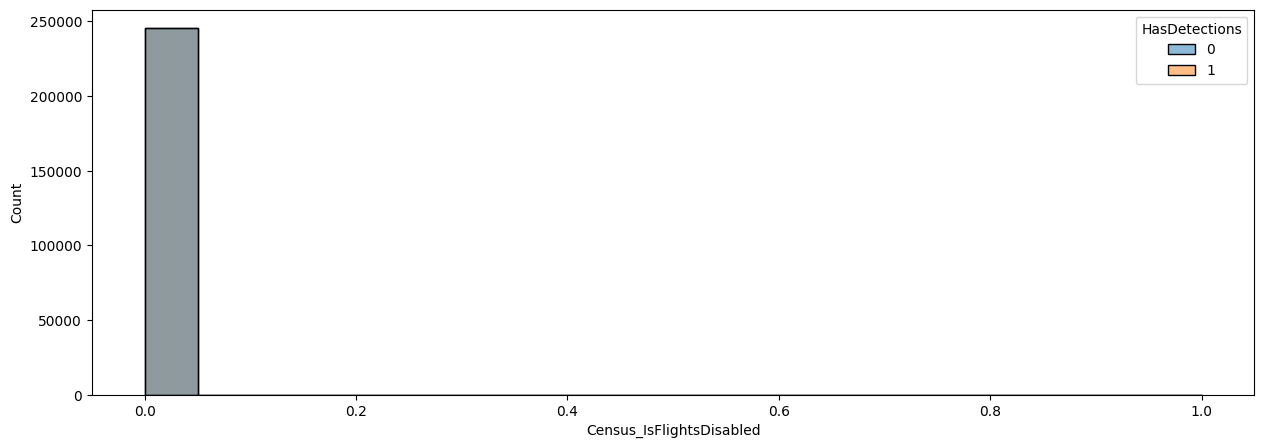

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(x = 'Census_IsFlightsDisabled', hue = TARGET, data = MMP10)

In [ ]:
#eliminamos la columna no aporta varianza

columnas_eliminar.add('Census_IsFlightsDisabled')
columnas_eliminar

{'AVProductsEnabled',
 'AutoSampleOptIn',
 'Census_DeviceFamily',
 'Census_FlightRing',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryType',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsFlightsDisabled',
 'Census_IsPenCapable',
 'Census_IsVirtualDevice',
 'Census_IsWIMBootEnabled',
 'Census_OEMModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OSArchitecture',
 'Census_OSSkuName',
 'Census_ProcessorClass',
 'Census_ProcessorModelIdentifier',
 'Census_ThresholdOptIn',
 'DefaultBrowsersIdentifier',
 'GeoNameIdentifier',
 'HasTpm',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'OsBuildLab',
 'ProductName',
 'PuaMode',
 'RtpStateBitfield',
 'SMode',
 'UacLuaenable',
 'Wdft_RegionIdentifier'}

###Census_IsFlightingInternal

In [ ]:
MMP10['Census_IsFlightingInternal'].isnull().sum()

415225

In [ ]:
#eliminamos la columna excesivos nulos

columnas_eliminar.add('Census_IsFlightingInternal')
columnas_eliminar

{'AVProductsEnabled',
 'AutoSampleOptIn',
 'Census_DeviceFamily',
 'Census_FlightRing',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryType',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsFlightingInternal',
 'Census_IsFlightsDisabled',
 'Census_IsPenCapable',
 'Census_IsVirtualDevice',
 'Census_IsWIMBootEnabled',
 'Census_OEMModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OSArchitecture',
 'Census_OSSkuName',
 'Census_ProcessorClass',
 'Census_ProcessorModelIdentifier',
 'Census_ThresholdOptIn',
 'DefaultBrowsersIdentifier',
 'GeoNameIdentifier',
 'HasTpm',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'OsBuildLab',
 'ProductName',
 'PuaMode',
 'RtpStateBitfield',
 'SMode',
 'UacLuaenable',
 'Wdft_RegionIdentifier'}

###Census_ActivationChannel

In [ ]:
MMP10['Census_ActivationChannel'].describe()

count     500000
unique         6
top       Retail
freq      264932
Name: Census_ActivationChannel, dtype: object

In [ ]:
MMP10['Census_ActivationChannel'].value_counts()

Retail            264932
OEM:DM            191350
Volume:GVLK        25109
OEM:NONSLP         17943
Volume:MAK           468
Retail:TB:Eval       198
Name: Census_ActivationChannel, dtype: int64

<Axes: xlabel='Census_ActivationChannel', ylabel='Count'>

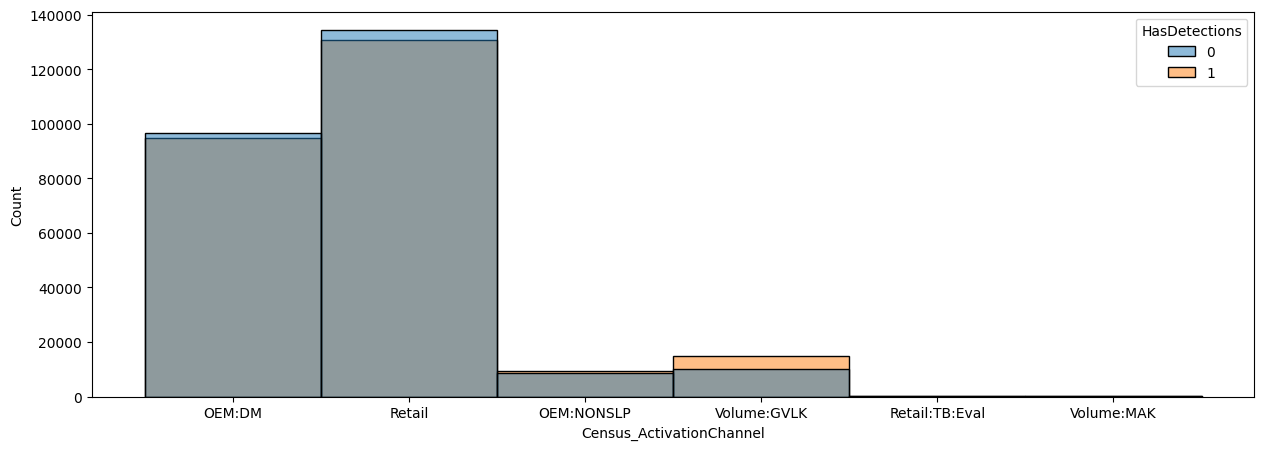

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(x = 'Census_ActivationChannel', hue = TARGET, data = MMP10)

In [ ]:
MMP10['Census_ActivationChannel'] = MMP10['Census_ActivationChannel'].astype('object')

In [ ]:
MMP10['Census_ActivationChannel'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: Census_ActivationChannel
Non-Null Count   Dtype 
--------------   ----- 
500000 non-null  object
dtypes: object(1)
memory usage: 3.8+ MB


Agrupamos en OEM, RETAIL y VOLUME

In [ ]:
MMP10['Census_ActivationChannel'].replace(['OEM:DM','OEM:NONSLP'], 'OEM', inplace=True)


In [ ]:
MMP10['Census_ActivationChannel'].replace(['Volume:GVLK','Volume:MAK'], 'Volume', inplace=True)

In [ ]:
MMP10['Census_ActivationChannel'].replace(['Retail','Retail:TB:Eval'], 'Retail', inplace=True)

In [ ]:
MMP10['Census_ActivationChannel'].value_counts()

Retail    265130
OEM       209293
Volume     25577
Name: Census_ActivationChannel, dtype: int64

In [ ]:
#hacemos OHE

columnas_OHE.add('Census_ActivationChannel')

###Census_GenuineStateName

In [ ]:
MMP10['Census_GenuineStateName'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 500000 entries, 0 to 499999
Series name: Census_GenuineStateName
Non-Null Count   Dtype 
--------------   ----- 
500000 non-null  object
dtypes: object(1)
memory usage: 3.8+ MB


In [ ]:
MMP10['Census_GenuineStateName'].describe()

count         500000
unique             4
top       IS_GENUINE
freq          441402
Name: Census_GenuineStateName, dtype: object

In [ ]:
MMP10['Census_GenuineStateName'].value_counts()

IS_GENUINE         441402
INVALID_LICENSE     44990
OFFLINE             12834
UNKNOWN               774
Name: Census_GenuineStateName, dtype: int64

In [ ]:
MMP10['Census_GenuineStateName'].value_counts()

IS_GENUINE         441402
INVALID_LICENSE     44990
OFFLINE             12834
UNKNOWN               774
Name: Census_GenuineStateName, dtype: int64

<Axes: xlabel='Census_GenuineStateName', ylabel='Count'>

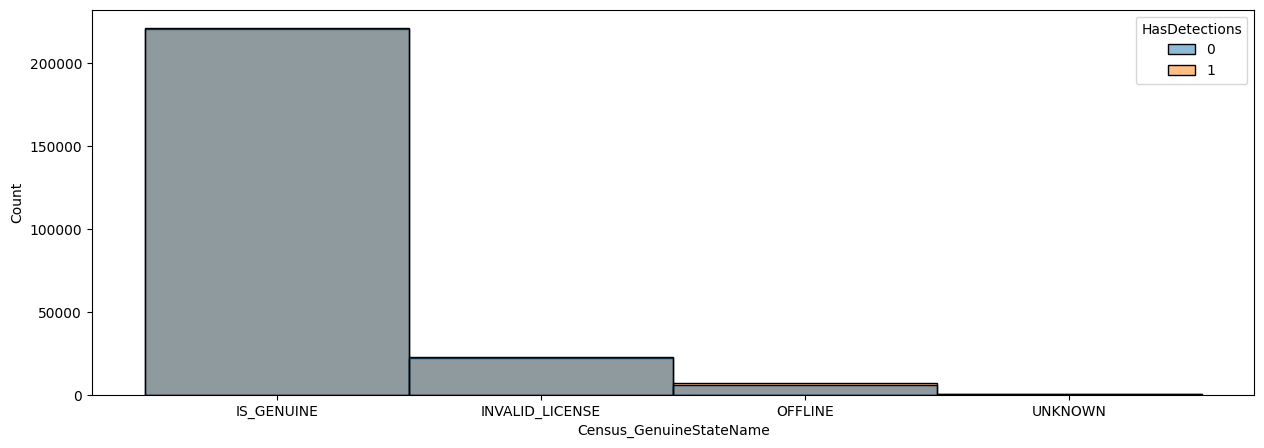

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(x = 'Census_GenuineStateName', hue = TARGET, data = MMP10)

In [ ]:
#eliminamos la columna poca varianza

columnas_eliminar.add('Census_GenuineStateName')
columnas_eliminar

{'AVProductsEnabled',
 'AutoSampleOptIn',
 'Census_DeviceFamily',
 'Census_FlightRing',
 'Census_GenuineStateName',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryType',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsFlightingInternal',
 'Census_IsFlightsDisabled',
 'Census_IsPenCapable',
 'Census_IsVirtualDevice',
 'Census_IsWIMBootEnabled',
 'Census_OEMModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OSArchitecture',
 'Census_OSSkuName',
 'Census_ProcessorClass',
 'Census_ProcessorModelIdentifier',
 'Census_ThresholdOptIn',
 'DefaultBrowsersIdentifier',
 'GeoNameIdentifier',
 'HasTpm',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'OsBuildLab',
 'ProductName',
 'PuaMode',
 'RtpStateBitfield',
 'SMode',
 'UacLuaenable',
 'Wdft_RegionIdentifier'}

###Census_IsPortableOperatingSystem

In [ ]:
MMP10['Census_IsPortableOperatingSystem'].describe()

count    500000.000000
mean          0.000522
std           0.022841
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: Census_IsPortableOperatingSystem, dtype: float64

In [ ]:
MMP10['Census_IsPortableOperatingSystem'].value_counts()

0    499739
1       261
Name: Census_IsPortableOperatingSystem, dtype: int64

In [ ]:
MMP10['Census_IsPortableOperatingSystem'].value_counts(normalize=True)

0    0.999478
1    0.000522
Name: Census_IsPortableOperatingSystem, dtype: float64

In [ ]:
#eliminamos la columna poca varianza

columnas_eliminar.add('Census_IsPortableOperatingSystem')
columnas_eliminar

{'AVProductsEnabled',
 'AutoSampleOptIn',
 'Census_DeviceFamily',
 'Census_FlightRing',
 'Census_GenuineStateName',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryType',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsFlightingInternal',
 'Census_IsFlightsDisabled',
 'Census_IsPenCapable',
 'Census_IsPortableOperatingSystem',
 'Census_IsVirtualDevice',
 'Census_IsWIMBootEnabled',
 'Census_OEMModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OSArchitecture',
 'Census_OSSkuName',
 'Census_ProcessorClass',
 'Census_ProcessorModelIdentifier',
 'Census_ThresholdOptIn',
 'DefaultBrowsersIdentifier',
 'GeoNameIdentifier',
 'HasTpm',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'OsBuildLab',
 'ProductName',
 'PuaMode',
 'RtpStateBitfield',
 'SMode',
 'UacLuaenable',
 'Wdft_RegionIdentifier'}

###Census_OSWUAutoUpdateOptionsName

In [ ]:
MMP10['Census_OSWUAutoUpdateOptionsName']

0         FullAuto
1         FullAuto
2           Notify
3         FullAuto
4         FullAuto
            ...   
499995      Notify
499996     UNKNOWN
499997    FullAuto
499998    FullAuto
499999    FullAuto
Name: Census_OSWUAutoUpdateOptionsName, Length: 500000, dtype: object

In [ ]:
MMP10['Census_OSWUAutoUpdateOptionsName'].value_counts()

FullAuto                                 222482
UNKNOWN                                  140961
Notify                                   113507
AutoInstallAndRebootAtMaintenanceTime     20731
Off                                        1506
DownloadNotify                              813
Name: Census_OSWUAutoUpdateOptionsName, dtype: int64

<Axes: xlabel='Census_OSWUAutoUpdateOptionsName', ylabel='Count'>

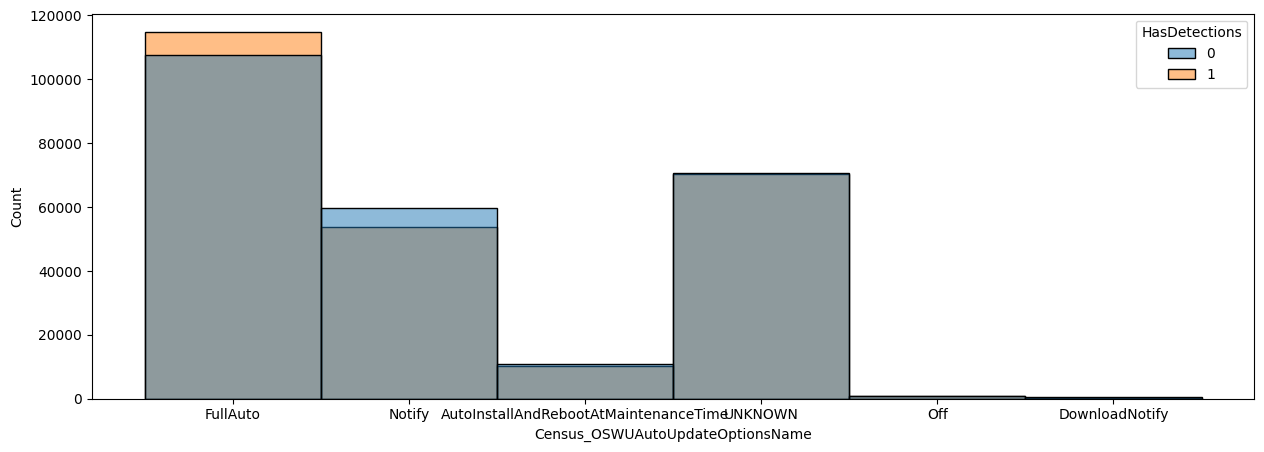

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(x = 'Census_OSWUAutoUpdateOptionsName', hue = TARGET, data = MMP10)

In [ ]:
columnas_OHE.add('Census_OSWUAutoUpdateOptionsName')


###Census_OSUILocaleIdentifier

In [ ]:
MMP10['Census_OSUILocaleIdentifier'].describe()

count    500000.000000
mean         60.446306
std          45.000423
min           1.000000
25%          31.000000
50%          34.000000
75%          90.000000
max         162.000000
Name: Census_OSUILocaleIdentifier, dtype: float64

In [ ]:
MMP10['Census_OSUILocaleIdentifier'].value_counts(normalize=True)

31     0.355966
34     0.116614
30     0.057596
125    0.056002
49     0.048846
         ...   
89     0.000002
22     0.000002
6      0.000002
71     0.000002
141    0.000002
Name: Census_OSUILocaleIdentifier, Length: 92, dtype: float64

<Axes: xlabel='Census_OSUILocaleIdentifier', ylabel='Count'>

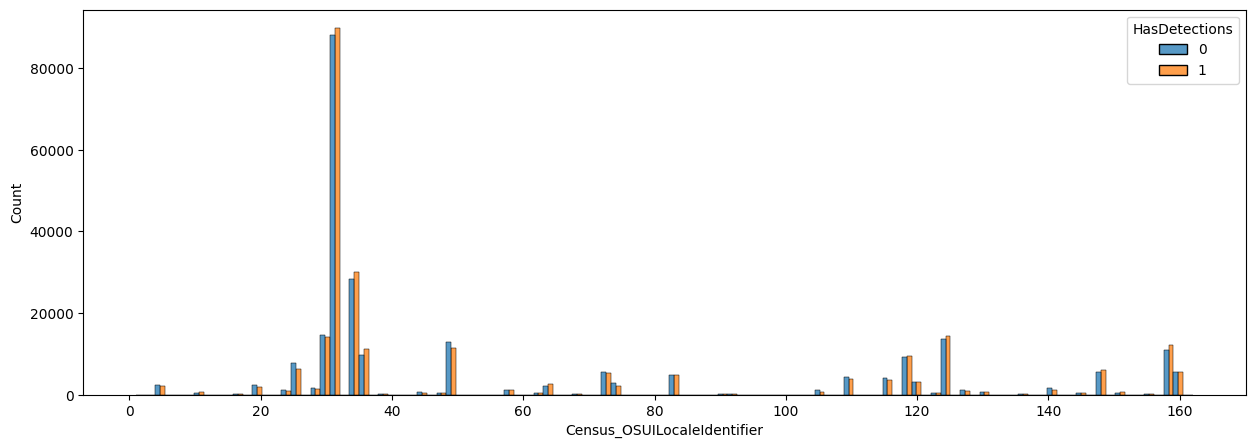

In [ ]:
plt.figure(figsize=(15,5))
sns.histplot(x = 'Census_OSUILocaleIdentifier', hue = TARGET, data = MMP10,multiple = "dodge")

In [ ]:
# Aqui se me ocurrio hacer una funcion ya que estoy todo el rato haciendo lo mismo


def explore_var(data, column):
  describe = data[column].describe()
  nulos = data[column].isnull().sum()
  count = data[column].value_counts()

  plt.figure(figsize=(15,5))
  sns.histplot(x = column, hue = TARGET, data = data ,multiple = "dodge")
  plt.show()

  return print(describe),print('                           '),print(count),print('                           '), print('Tiene',nulos,'nulos.')





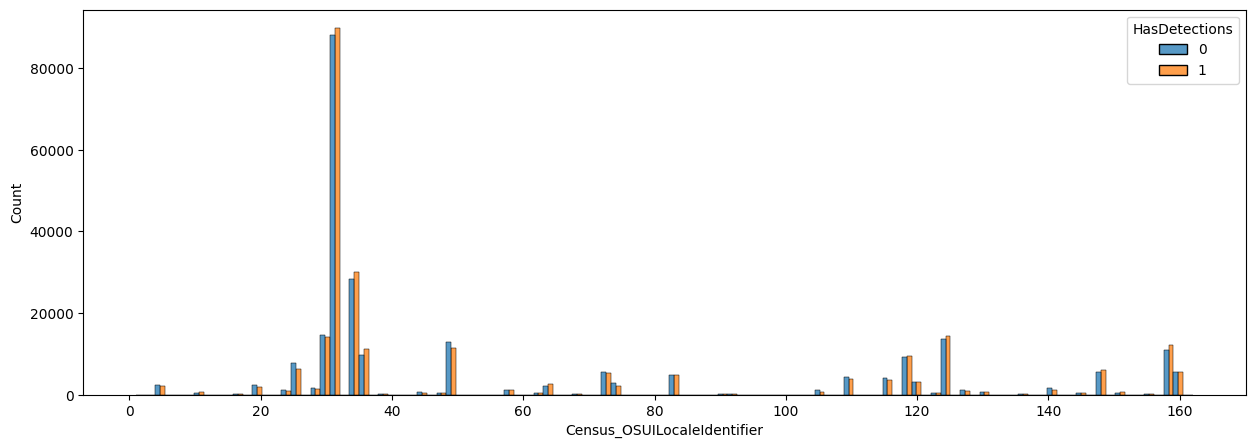

count    500000.000000
mean         60.446306
std          45.000423
min           1.000000
25%          31.000000
50%          34.000000
75%          90.000000
max         162.000000
Name: Census_OSUILocaleIdentifier, dtype: float64
                           
31     177983
34      58307
30      28798
125     28001
49      24423
        ...  
89          1
22          1
6           1
71          1
141         1
Name: Census_OSUILocaleIdentifier, Length: 92, dtype: int64
                           
Tiene 0 nulos.


(None, None, None, None, None)

In [ ]:
explore_var(MMP10, 'Census_OSUILocaleIdentifier')

In [ ]:
columnas_FEnc.add('Census_OSUILocaleIdentifier')

### Census_OSInstallLanguageIdentifier

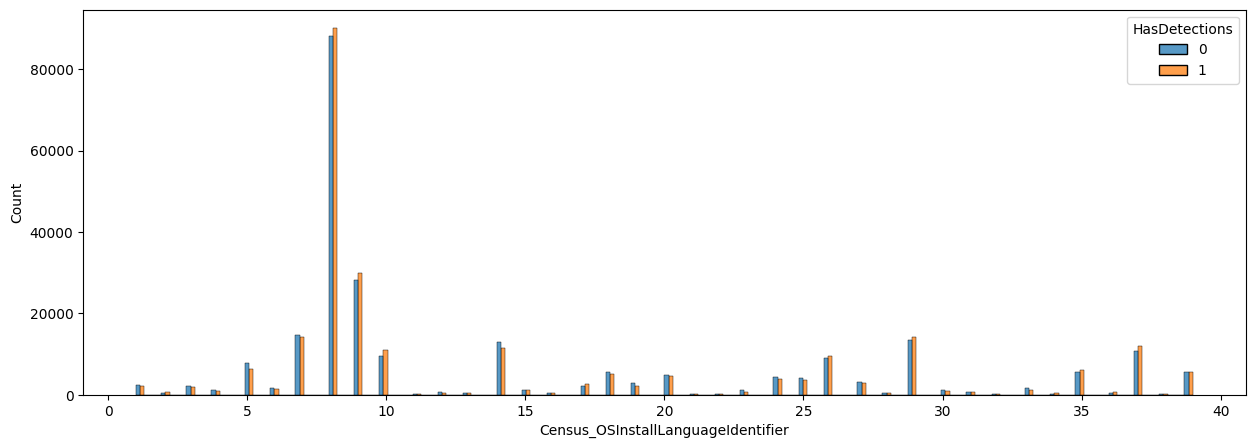

count    496668.000000
mean         14.605509
std          10.200946
min           1.000000
25%           8.000000
50%           9.000000
75%          20.000000
max          39.000000
Name: Census_OSInstallLanguageIdentifier, dtype: float64
                           
8.0     178405
9.0      58013
7.0      28766
29.0     27669
14.0     24191
37.0     22635
10.0     20268
26.0     18520
5.0      14085
35.0     11497
39.0     11221
18.0     10600
20.0      9512
24.0      8127
25.0      7502
27.0      5956
19.0      4775
17.0      4695
1.0       4516
3.0       4067
6.0       2881
33.0      2807
15.0      2311
4.0       1996
30.0      1793
23.0      1652
31.0      1213
12.0      1119
2.0       1096
36.0       846
16.0       837
28.0       713
34.0       584
13.0       581
21.0       413
32.0       246
11.0       197
38.0       185
22.0       178
Name: Census_OSInstallLanguageIdentifier, dtype: int64
                           
Tiene 3332 nulos.


(None, None, None, None, None)

In [ ]:
explore_var(MMP10, 'Census_OSInstallLanguageIdentifier')

In [ ]:
MMP10['Census_OSInstallLanguageIdentifier'].value_counts()

8.0     178405
9.0      58013
7.0      28766
29.0     27669
14.0     24191
37.0     22635
10.0     20268
26.0     18520
5.0      14085
35.0     11497
39.0     11221
18.0     10600
20.0      9512
24.0      8127
25.0      7502
27.0      5956
19.0      4775
17.0      4695
1.0       4516
3.0       4067
6.0       2881
33.0      2807
15.0      2311
4.0       1996
30.0      1793
23.0      1652
31.0      1213
12.0      1119
2.0       1096
36.0       846
16.0       837
28.0       713
34.0       584
13.0       581
21.0       413
32.0       246
11.0       197
38.0       185
22.0       178
Name: Census_OSInstallLanguageIdentifier, dtype: int64

In [ ]:
columnas_FEnc.add('Census_OSInstallLanguageIdentifier')

In [ ]:
MMP_clean = MMP10.copy()

In [ ]:
MMP_clean.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 101 entries, Unnamed: 0 to Census_OSEditionGROUPED
dtypes: category(18), float64(26), int64(17), object(40)
memory usage: 325.2+ MB


# Preprocesamiento

### Eliminar columnas

In [ ]:
MMP10['Census_IsVirtualDevice'].value_counts()

0.0    495572
1.0      3527
Name: Census_IsVirtualDevice, dtype: int64

In [ ]:
columnas_eliminar

{'AVProductsEnabled',
 'AutoSampleOptIn',
 'Census_DeviceFamily',
 'Census_FlightRing',
 'Census_GenuineStateName',
 'Census_HasOpticalDiskDrive',
 'Census_InternalBatteryType',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_IsFlightingInternal',
 'Census_IsFlightsDisabled',
 'Census_IsPenCapable',
 'Census_IsPortableOperatingSystem',
 'Census_IsVirtualDevice',
 'Census_IsWIMBootEnabled',
 'Census_OEMModelIdentifier',
 'Census_OEMNameIdentifier',
 'Census_OSArchitecture',
 'Census_OSSkuName',
 'Census_ProcessorClass',
 'Census_ProcessorModelIdentifier',
 'Census_ThresholdOptIn',
 'DefaultBrowsersIdentifier',
 'GeoNameIdentifier',
 'HasTpm',
 'IsBeta',
 'IsSxsPassiveMode',
 'MachineIdentifier',
 'OsBuildLab',
 'ProductName',
 'PuaMode',
 'RtpStateBitfield',
 'SMode',
 'UacLuaenable',
 'Wdft_RegionIdentifier'}

In [ ]:
columnas_to_drop = list(columnas_eliminar) + list(columnas_antiguas_eliminar)
columnas_to_drop

['Census_IsPenCapable',
 'Census_IsVirtualDevice',
 'IsBeta',
 'Census_IsWIMBootEnabled',
 'OsBuildLab',
 'Census_OEMModelIdentifier',
 'Census_DeviceFamily',
 'ProductName',
 'Census_InternalPrimaryDisplayResolutionVertical',
 'Census_OEMNameIdentifier',
 'AVProductsEnabled',
 'Census_ThresholdOptIn',
 'UacLuaenable',
 'Census_OSArchitecture',
 'Census_IsAlwaysOnAlwaysConnectedCapable',
 'Census_ProcessorClass',
 'AutoSampleOptIn',
 'Census_InternalBatteryType',
 'Census_FlightRing',
 'RtpStateBitfield',
 'Census_OSSkuName',
 'MachineIdentifier',
 'SMode',
 'Census_IsFlightsDisabled',
 'Census_IsFlightingInternal',
 'PuaMode',
 'HasTpm',
 'GeoNameIdentifier',
 'Census_HasOpticalDiskDrive',
 'DefaultBrowsersIdentifier',
 'IsSxsPassiveMode',
 'Census_ProcessorModelIdentifier',
 'Census_IsPortableOperatingSystem',
 'Wdft_RegionIdentifier',
 'Census_GenuineStateName',
 'AppVersion',
 'Census_OSVersion',
 'Census_OSBuildRevision',
 'EngineVersion',
 'Processor',
 'Census_OSBuildNumber',
 '

In [ ]:
MMP_clean = MMP_clean.drop(columnas_to_drop, axis=1)

In [ ]:
for columna in MMP_clean.columns:
    valores_unicos = MMP_clean[columna].unique()
    if len(valores_unicos) == 2 and 0 in valores_unicos and 1 in valores_unicos:
        columnas_booleanas.add(columna)

In [ ]:
total_columnas = set(columnas_OrdEnc) | set(columnas_FEnc) | set(columnas_MinMaxS) | set(columnas_OHE) | set(columnas_booleanas) | set(columnas_oversampling)
print('Ahora tenemos', len(total_columnas), 'columnas, sin hacer ninguna transformacion, deberíamos hacer limpieza o nos quedaremos con un DataSet Enorme')

Ahora tenemos 48 columnas, sin hacer ninguna transformacion, deberíamos hacer limpieza o nos quedaremos con un DataSet Enorme


In [ ]:
MMP_clean.info(verbose=False)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Columns: 49 entries, Unnamed: 0 to Census_OSEditionGROUPED
dtypes: category(12), float64(12), int64(9), object(16)
memory usage: 146.9+ MB


In [ ]:
#Localizar las variables que nos faltan
columnas_faltantes = list(set(MMP_clean.columns) - total_columnas)
columnas_faltantes

['Unnamed: 0']

In [ ]:
MMP_clean = MMP_clean.drop('Unnamed: 0', axis = 1)

In [ ]:
#CON ESTA FUNCIÓN, NOS ASEGURAMOS DE QUE EN LAS LISTAS, NO EXISTEN COLUMNAS A LAS QUE VAYAMOS A DAR DOS TRATAMIENTOS POR QUE ESTÉN METIDAS EN DOS LISTAS.

def check_duplicates(lists):
    all_variables = []
    duplicates = []

    for lst in lists:
        for var in lst:
            if var in all_variables:
                duplicates.append(var)
            else:
                all_variables.append(var)

    if duplicates:
        print("Se encontraron variables repetidas:")
        for var in duplicates:
            print(var)
    else:
        print("No se encontraron variables repetidas.")

listas = [columnas_OrdEnc, columnas_FEnc, columnas_MinMaxS, columnas_OHE, columnas_booleanas, columnas_oversampling ]
check_duplicates(listas)


Se encontraron variables repetidas:
Firewall
Platform


#### Analizar redundancia Variables Categóricas

##### Aplicar OHE para evaluar correlación

In [ ]:
df_OHE = pd.DataFrame(MMP_clean[columnas_OHE])

<ipython-input-451-ff817020f1b9>:1: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  df_OHE = pd.DataFrame(MMP_clean[columnas_OHE])


In [ ]:
df_OHE = pd.get_dummies(df_OHE)

corr = df_OHE.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# Grupos de columnas con alta correlación:

  # G1-> (Census_MDC2FormFactor, Census_ChassisTypeNameG, Census_PowerPlatformRoleName)
  # G2-> (Census_OSWUAutoUpdateOptionsName, IsProtected)
  # G3-> (Census_OSVersion_GROUPED,Census_OSBranch_grouped, Census_OSBuildNumberGROUPED, OsPlatformSubRelease, IeVerIdentifier_grouped, OSBuild)
  # G4-> (CityIdentifierTRANSFORM, CountryIdentifierTRANSFORM)
  # G5-> (Census_OSEditionGROUPED, SkuEdition, OsSuite)

G1. (Census_MDC2FormFactor, Census_ChassisTypeNameG, Census_PowerPlatformRoleName)

In [ ]:
MMP_clean['Census_MDC2FormFactor'].value_counts()

Notebook       320948
Desktop        109527
Convertible     22369
Detachable      16802
AllInOne        16372
others          13982
Name: Census_MDC2FormFactor, dtype: int64

In [ ]:
MMP_clean['Census_ChassisTypeNameG'].value_counts()

Notebook       294232
Desktop        104979
Laptop          38261
Others          21406
Portable        20181
AllinOne        11407
MiniTower        4849
Convertible      4685
Name: Census_ChassisTypeNameG, dtype: int64

In [ ]:
MMP_clean['Census_PowerPlatformRoleName'].value_counts()

Mobile         346378
Desktop        116054
Slate           27475
Workstation      6235
Others           3858
Name: Census_PowerPlatformRoleName, dtype: int64

In [ ]:
# Nos quedamos con Cenus_chasis_TypeNameG. Procedemos a eliminar las otras dos columnas

columnas_OHE_eliminar = {'Census_MDC2FormFactor', 'Census_PowerPlatformRoleName'}

G2. (Census_OSWUAutoUpdateOptionsName, IsProtected)

In [ ]:
MMP_clean['Census_OSWUAutoUpdateOptionsName'].value_counts()

FullAuto                                 222482
UNKNOWN                                  140961
Notify                                   113507
AutoInstallAndRebootAtMaintenanceTime     20731
Off                                        1506
DownloadNotify                              813
Name: Census_OSWUAutoUpdateOptionsName, dtype: int64

In [ ]:
MMP_clean['IsProtected'].value_counts()

1.0    471073
0.0     28927
Name: IsProtected, dtype: int64

In [ ]:
# Parece ser que aun teniendo alta correlación, aporta información diferente: 'Census_OSWUAutoUpdateOptionsName' indica tipos de actualizacion y 'IsProtected' indica si tiene antivirus y si esta activado

G3 (Census_OSVersion_GROUPED,Census_OSBranch_grouped, Census_OSBuildNumberGROUPED, OsPlatformSubRelease, IeVerIdentifier_grouped, OSBuild)


In [ ]:
MMP_clean['OsBuild'].value_counts()

17134     220779
16299     139901
15063      43352
14393      40717
10586      22955
10240      15014
9600       10825
others      6457
Name: OsBuild, dtype: int64

In [ ]:
MMP_clean['Census_OSBuildNumberGROUPED'].value_counts()

17134     225979
16299     136572
Others     49485
15063      44262
14393      43702
Name: Census_OSBuildNumberGROUPED, dtype: int64

In [ ]:
# Por alta correlacion (> .90) de estas dos variables con OSVersion, procedemos a eliminarlas
columnas_OHE_eliminar.add('Census_OSBuildNumberGROUPED')
columnas_OHE_eliminar.add('OsBuild')

In [ ]:
MMP_clean['Census_OSVersion_GROUPED'].value_counts()

10.0.17          227107
10.0.16          136574
10.0.10           48299
10.0.15           44265
10.0.14           43710
Other_version        45
Name: Census_OSVersion_GROUPED, dtype: int64

In [ ]:
MMP_clean['Census_OSBranch_grouped'].value_counts()

rs4_release            226001
rs3_release            136572
rs2_release             44264
rs1_release             43705
th2_release             33193
Others                  16264
winblue_ltsb_escrow         1
Name: Census_OSBranch_grouped, dtype: int64

In [ ]:
MMP_clean['OsPlatformSubRelease'].value_counts()

rs4           220779
rs3           139901
rs2            43352
rs1            40717
th2            22955
th1            15014
windows8.1     10825
windows7        5314
prers5          1143
Name: OsPlatformSubRelease, dtype: int64

In [ ]:
# Por alta correlación entre estas tres variables, además de la redundancia en los datos, decidimos quedarnos con 'Census_OSVersion_GROUPED'.
columnas_OHE_eliminar.add('Census_OSBranch_grouped')
columnas_OHE_eliminar.add('OsPlatformSubRelease')

In [ ]:
MMP_clean['IeVerIdentifier_grouped'].value_counts()

137.0     219142
117.0      98667
others     74903
108.0      26353
111.0      26143
98.0       19731
135.0      12314
74.0       11395
53.0       11352
Name: IeVerIdentifier_grouped, dtype: int64

In [ ]:
# Esta variable tiene alta correlación con las anteriores (> 0.70), no obstante la mantenemos ya que aporta informacion diferente (versionNavegador vs version SO)

G4 (CityIdentifierTRANSFORM, CountryIdentifierTRANSFORM)

In [ ]:
# Tienen alta correlación, consideramos que no es necesario incluir las ciudades en el modelo, dado el Target, si ya disponemos de los paises.
columnas_OHE_eliminar.add('CityIdentifierTRANSFORM')

G5 (Census_OSEditionGROUPED, SkuEdition, OsSuite)

In [ ]:
MMP_clean['Census_OSEditionGROUPED'].value_counts()

Core                   194720
Professional           177435
CoreSingleLanguage     108696
CoreCountrySpecific      9275
Others                   7791
Enterprise               2083
Name: Census_OSEditionGROUPED, dtype: int64

In [ ]:
MMP_clean['SkuEdition'].value_counts()

Home               308567
Pro                181042
Invalid              4423
Education            2321
Enterprise           1999
Enterprise LTSB      1141
Cloud                 309
Server                198
Name: SkuEdition, dtype: int64

In [ ]:
MMP_clean['OsSuite'].value_counts()

768       311226
256       187951
others       823
Name: OsSuite, dtype: int64

In [ ]:
# Estas variables tienen correlaciones de entre 0.8 y > 0.9. Decidimos mantener 'Census_OSEditionGROUPED' por estar mejor distribuida.
columnas_OHE_eliminar.add('OsSuite')
columnas_OHE_eliminar.add('SkuEdition')

In [ ]:
columnas_OHE - columnas_OHE_eliminar

{'AVProductStatesIdentifier_Grouped',
 'Census_ActivationChannel',
 'Census_ChassisTypeNameG',
 'Census_OSEditionGROUPED',
 'Census_OSInstallTypeName',
 'Census_OSVersion_GROUPED',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_PrimaryDiskTypeName',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'CountryIdentifierTRANSFORM',
 'EngineVersionTRANSFORM',
 'IeVerIdentifier_grouped',
 'OrganizationIdentifierT',
 'OsVer10',
 'SmartScreen'}

In [ ]:
MMP_clean = MMP_clean.drop(columnas_OHE_eliminar, axis=1)

In [ ]:
len(MMP_clean.columns)

39

In [ ]:
columnas_OHE = columnas_OHE - columnas_OHE_eliminar
columnas_OHE

{'AVProductStatesIdentifier_Grouped',
 'Census_ActivationChannel',
 'Census_ChassisTypeNameG',
 'Census_OSEditionGROUPED',
 'Census_OSInstallTypeName',
 'Census_OSVersion_GROUPED',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_PrimaryDiskTypeName',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'CountryIdentifierTRANSFORM',
 'EngineVersionTRANSFORM',
 'IeVerIdentifier_grouped',
 'OrganizationIdentifierT',
 'OsVer10',
 'SmartScreen'}

In [ ]:
del(df_OHE)

## Análisis Multivariante

##### Cambiar nombre columnas

In [ ]:
def eliminar_sufijo(nombre_columna):
    if nombre_columna.endswith('_Grouped'):
        return nombre_columna[:-8]
    elif nombre_columna.endswith('_GROUPED'):
        return nombre_columna[:-8]
    elif nombre_columna.endswith('GROUPED'):
        return nombre_columna[:-7]
    elif nombre_columna.endswith('_grouped'):
        return nombre_columna[:-8]
    elif nombre_columna.endswith('TRANSFORM'):
        return nombre_columna[:-9]
    elif nombre_columna.endswith('Ordened'):
        return nombre_columna[:-7]
    else:
        return nombre_columna

for column in MMP_clean.columns:
    columna_renomb = eliminar_sufijo(column)
    MMP_clean.rename(columns={column: columna_renomb}, inplace=True)

In [ ]:
MMP_clean.columns

Index(['AVProductsInstalled', 'LocaleEnglishNameIdentifier', 'Platform',
       'IsProtected', 'SmartScreen', 'Firewall', 'Census_ProcessorCoreCount',
       'Census_ProcessorManufacturerIdentifier',
       'Census_PrimaryDiskTotalCapacity', 'Census_PrimaryDiskTypeName',
       'Census_SystemVolumeTotalCapacity', 'Census_TotalPhysicalRAM',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches',
       'Census_InternalPrimaryDisplayResolutionHorizontal',
       'Census_InternalBatteryNumberOfCharges', 'Census_OSInstallTypeName',
       'Census_OSInstallLanguageIdentifier', 'Census_OSUILocaleIdentifier',
       'Census_OSWUAutoUpdateOptionsName', 'Census_ActivationChannel',
       'Census_FirmwareManufacturerIdentifier',
       'Census_FirmwareVersionIdentifier', 'Census_IsSecureBootEnabled',
       'Census_IsTouchEnabled', 'Wdft_IsGamer', 'HasDetections',
       'EngineVersion', 'AppVersionmayores4.18', 'AvSigVersion',
       'AVProductStatesIdentifier', 'CountryIdentifier',
       

In [ ]:
columnas_LabelEncoder = {'AvSigVersion'}

In [ ]:
columnas_OHE = {'AVProductStatesIdentifier', 'Census_ActivationChannel', 'Census_ChassisTypeNameG', 'Census_OSEdition', 'Census_OSInstallTypeName',  'Census_OSVersion', 'Census_OSWUAutoUpdateOptionsName', 'Census_PrimaryDiskTypeName', 'Census_ProcessorCoreCount',
                'Census_ProcessorManufacturerIdentifier','CountryIdentifier','EngineVersion', 'IeVerIdentifier', 'IsProtected', 'OrganizationIdentifierT', 'OsVer10', 'SmartScreen'}

In [ ]:
columnas_OrdEnc = {'AVProductsInstalled', 'AvSigVersion', 'Census_OSBuildRevision'}

### Variables categóricas

In [ ]:
v_categoricas = list(columnas_OHE) + list(columnas_FEnc) + list(columnas_OrdEnc)

for column in v_categoricas:
    MMP_clean[column] = MMP_clean[column].astype(str)

In [ ]:
v_categoricas

['Census_OSWUAutoUpdateOptionsName',
 'EngineVersion',
 'IsProtected',
 'Census_ProcessorCoreCount',
 'OsVer10',
 'Census_OSInstallTypeName',
 'Census_PrimaryDiskTypeName',
 'IeVerIdentifier',
 'CountryIdentifier',
 'Census_OSEdition',
 'OrganizationIdentifierT',
 'SmartScreen',
 'Census_OSVersion',
 'Census_ProcessorManufacturerIdentifier',
 'Census_ChassisTypeNameG',
 'AVProductStatesIdentifier',
 'Census_ActivationChannel',
 'LocaleEnglishNameIdentifier',
 'Platform',
 'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'Census_OSBuildRevision',
 'AvSigVersion',
 'AVProductsInstalled']

1. Columnas a tratar con OHE

In [ ]:
from tabulate import tabulate
import matplotlib.gridspec as gridspec

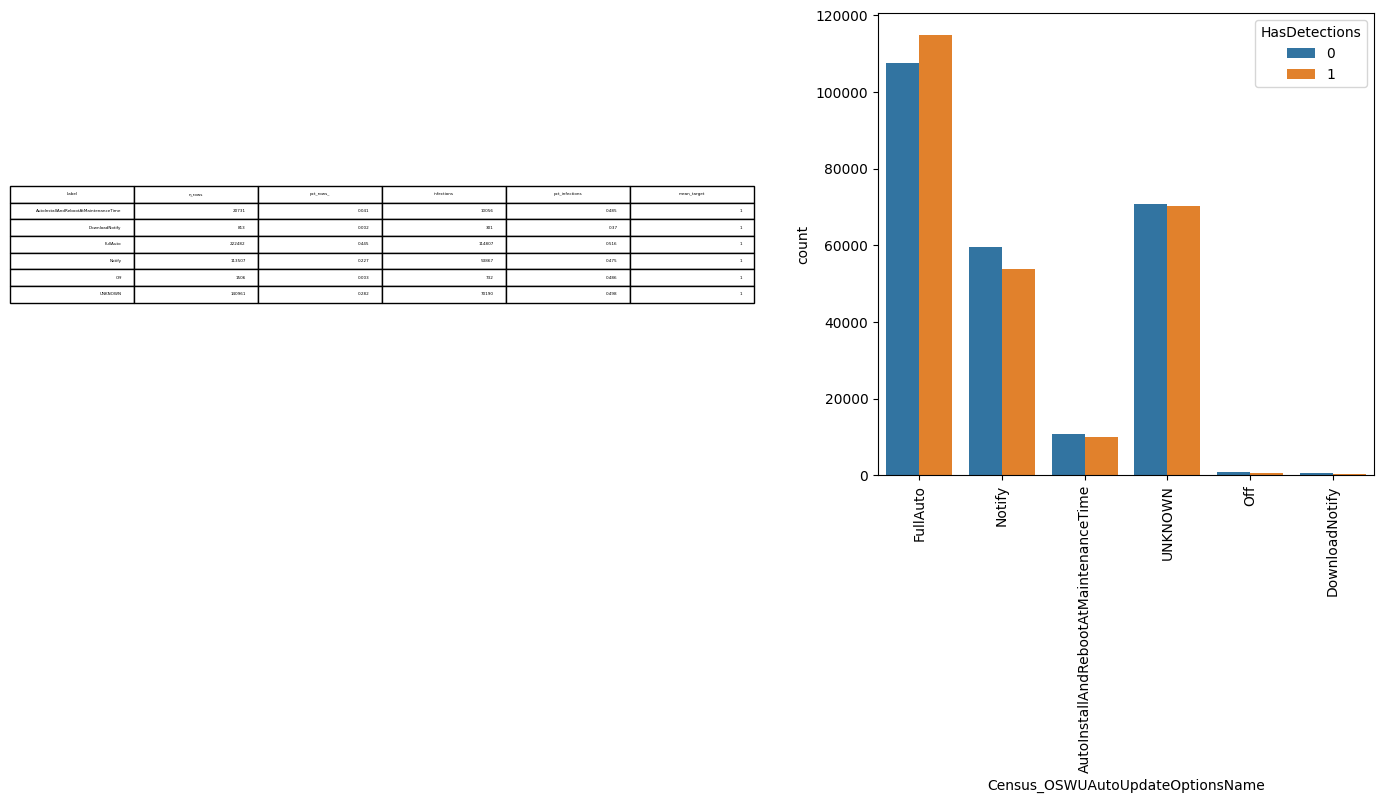

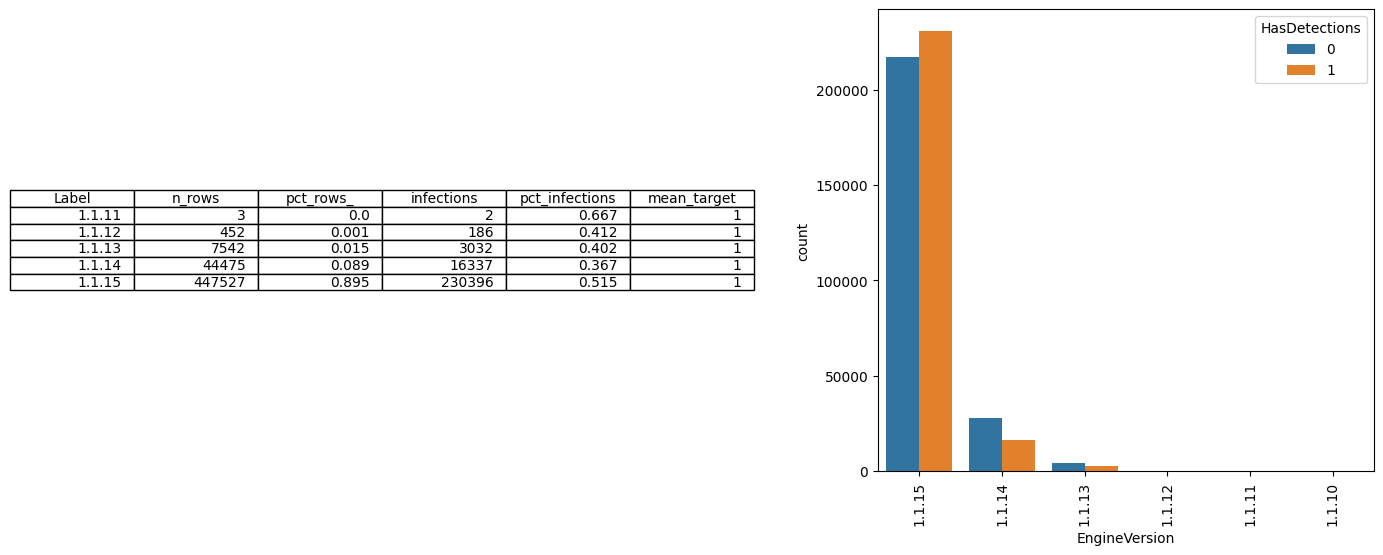

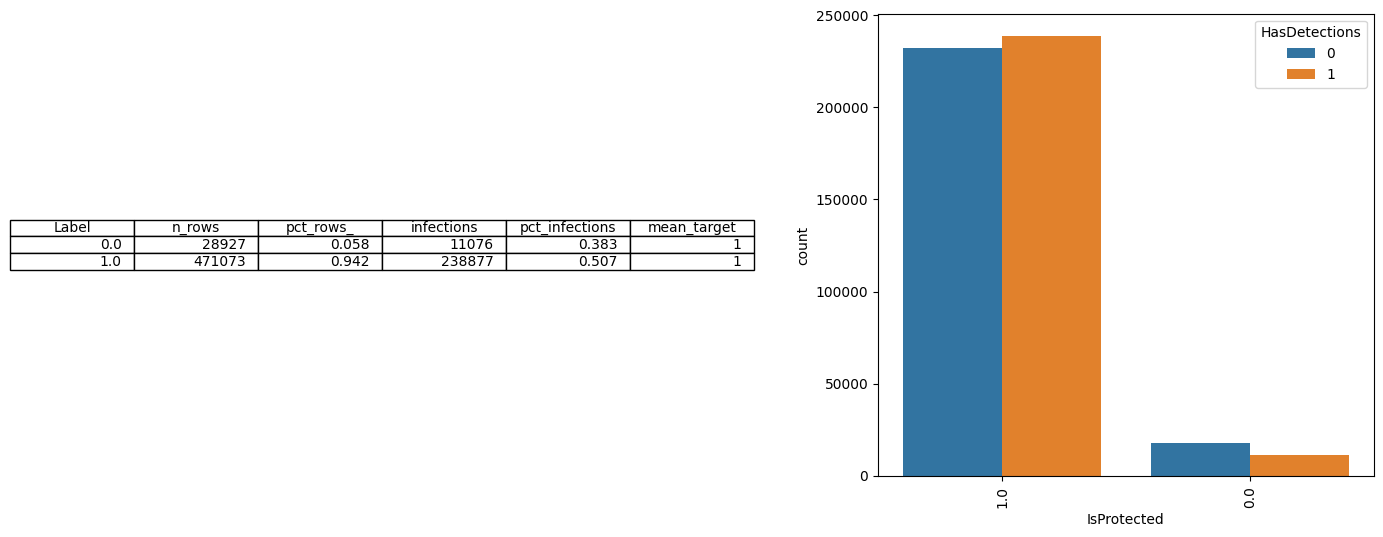

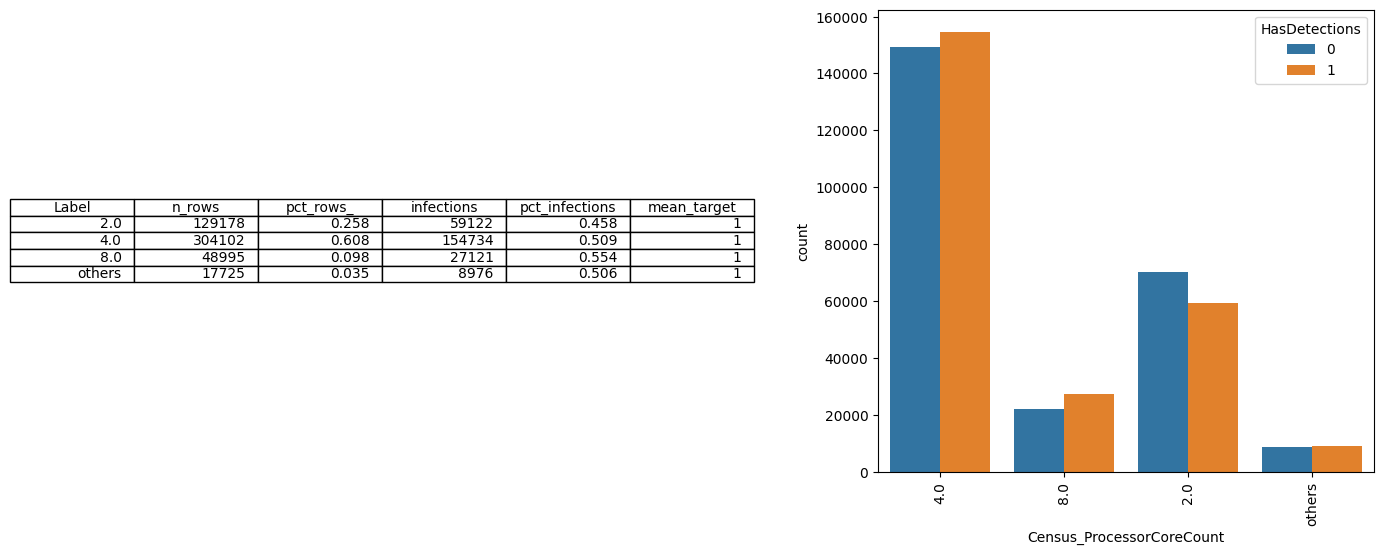

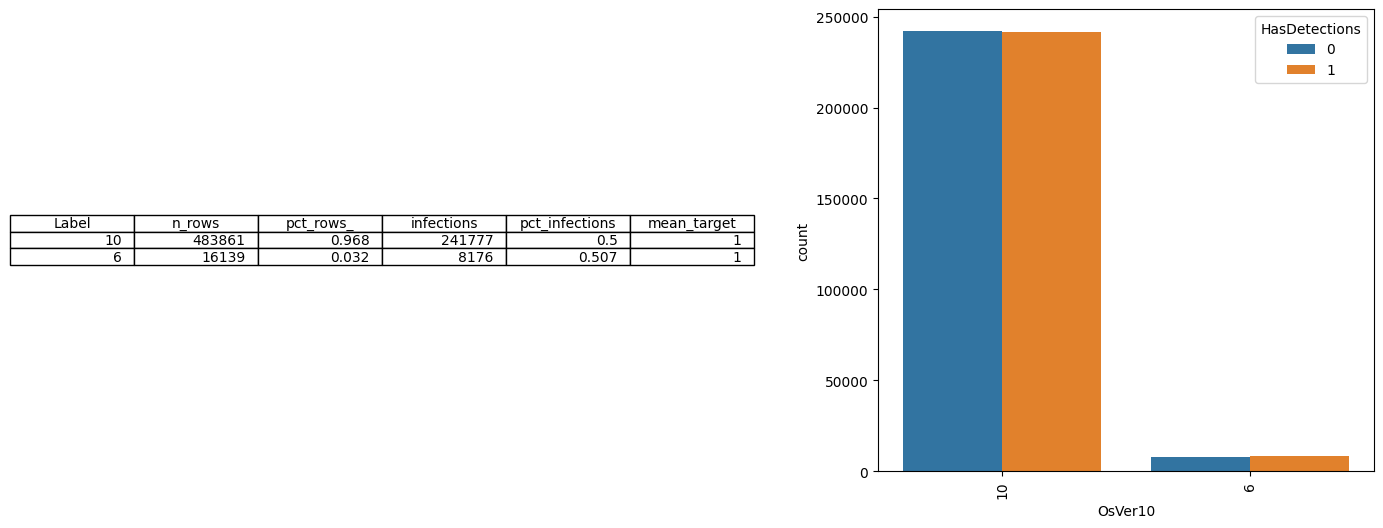

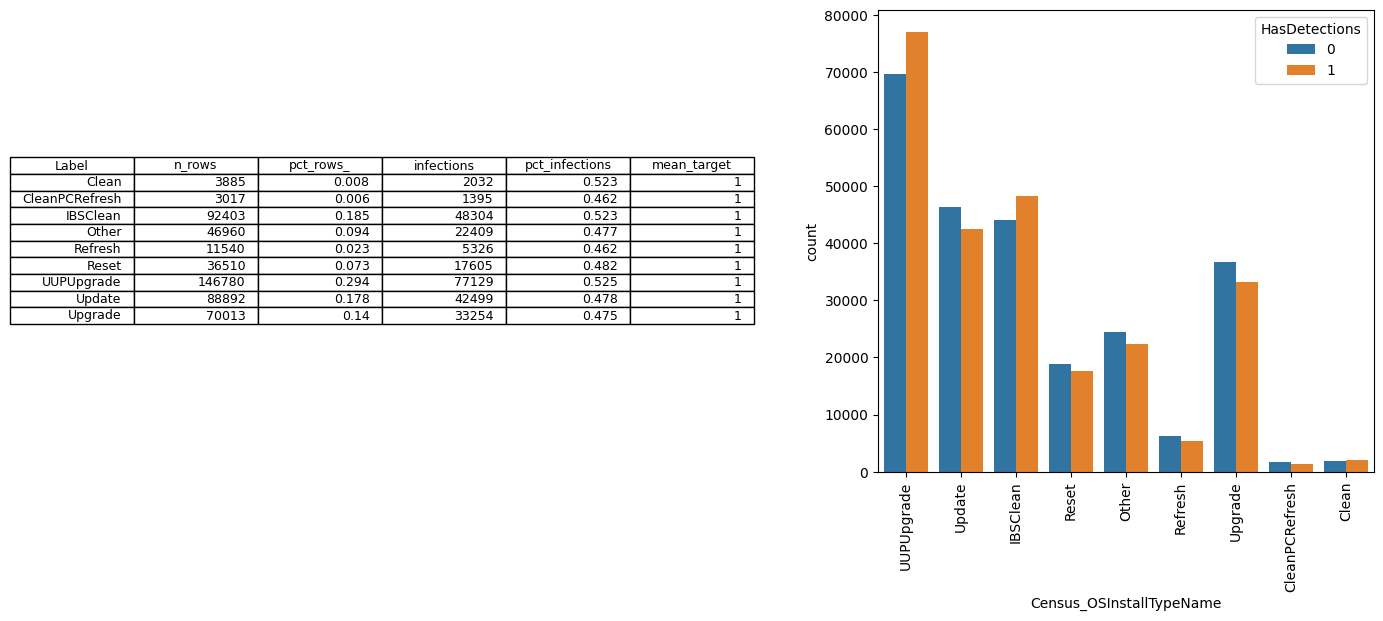

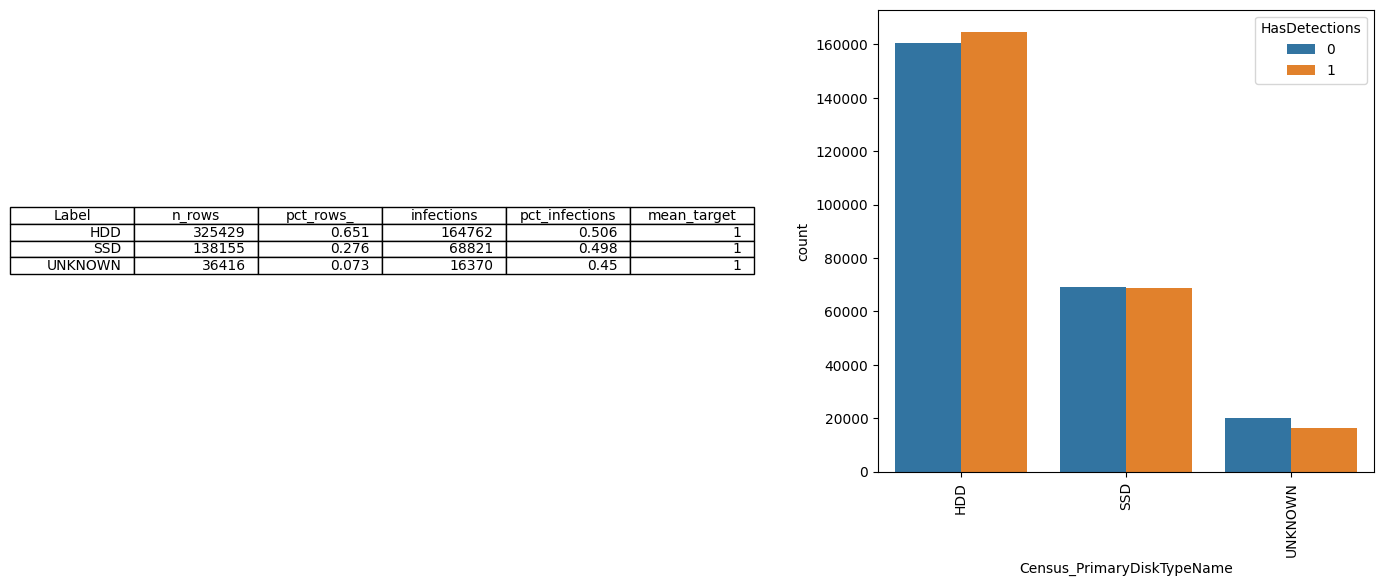

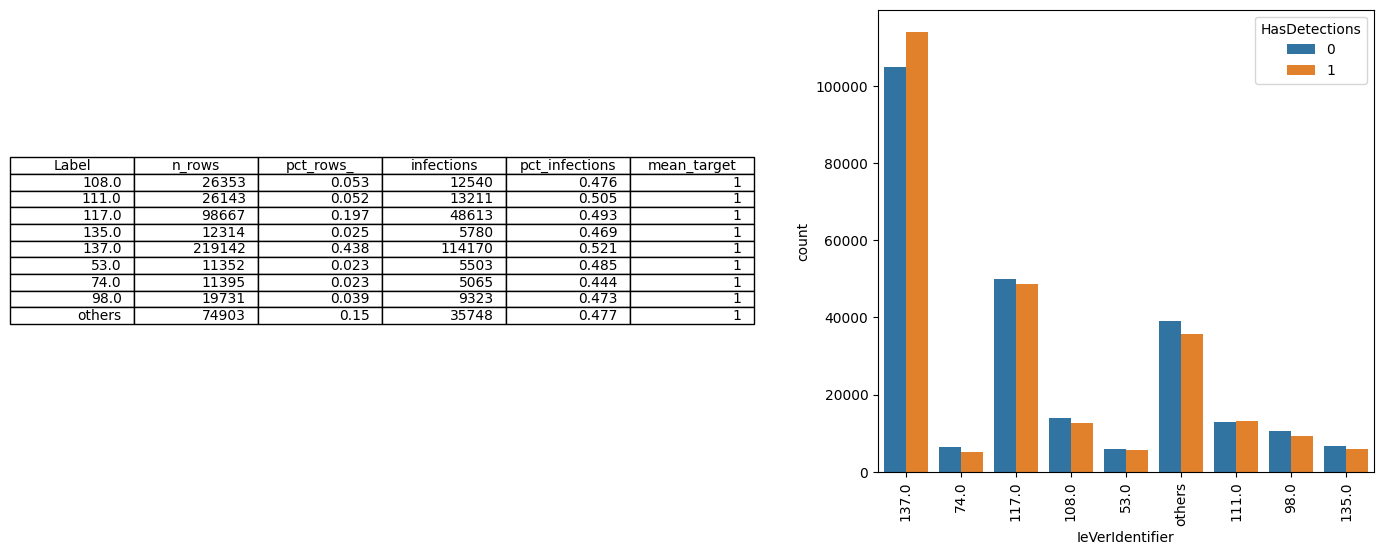

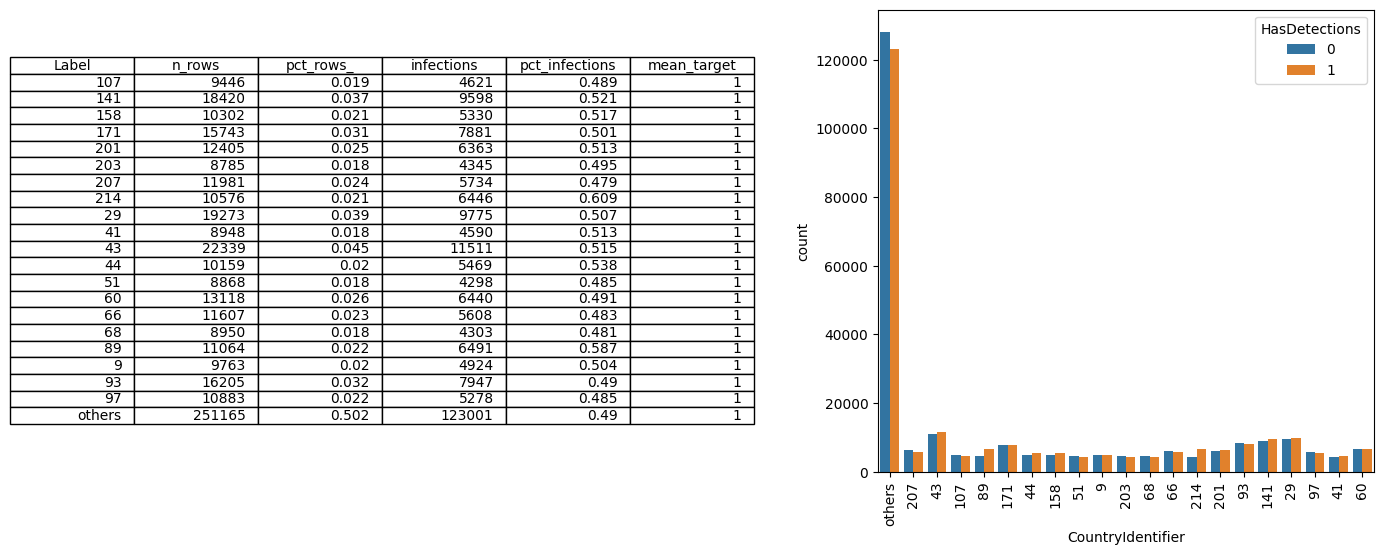

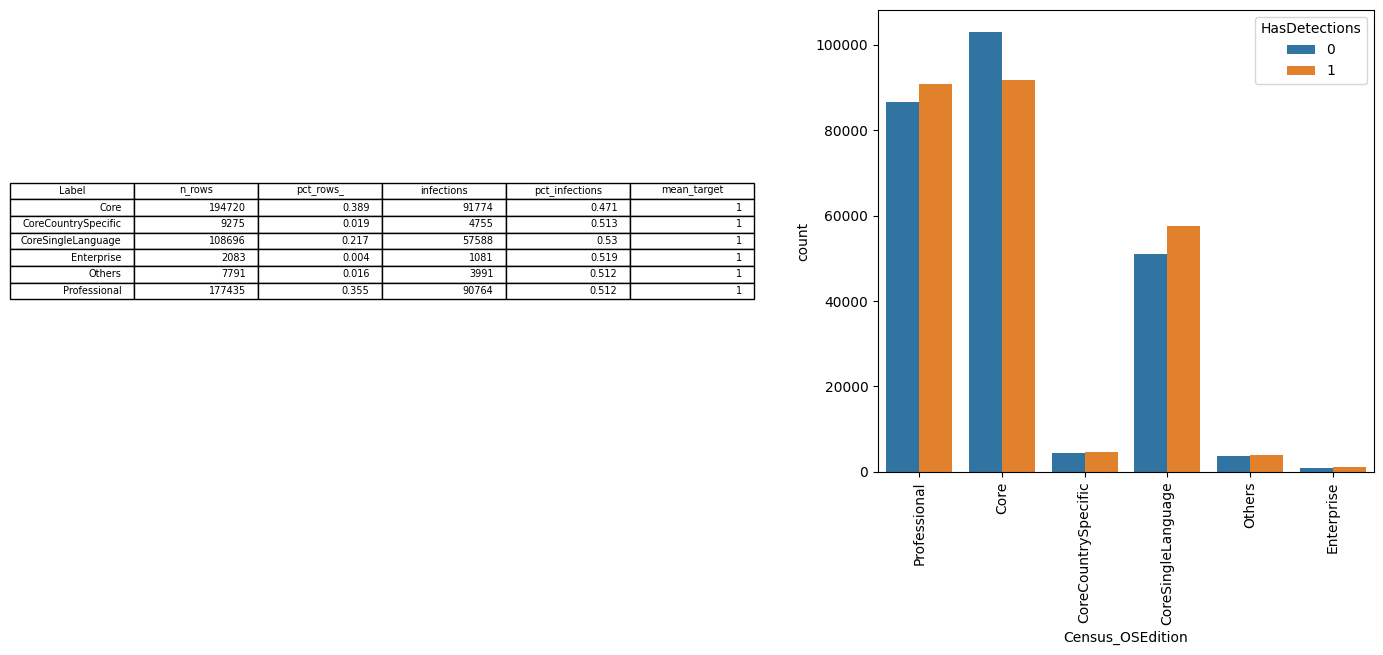

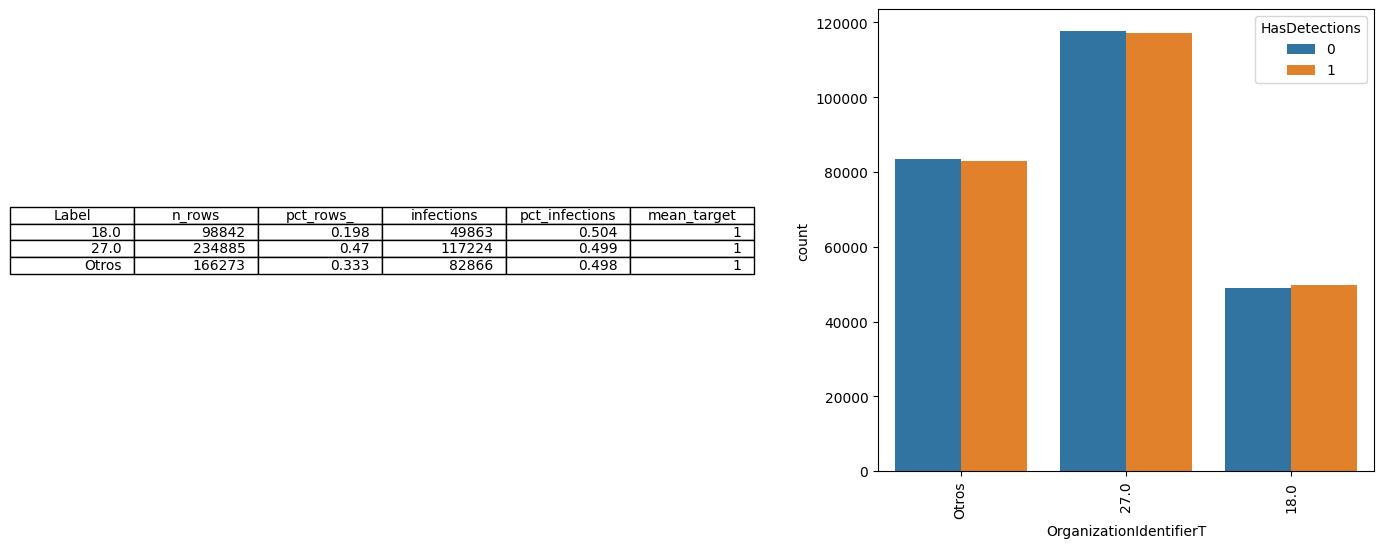

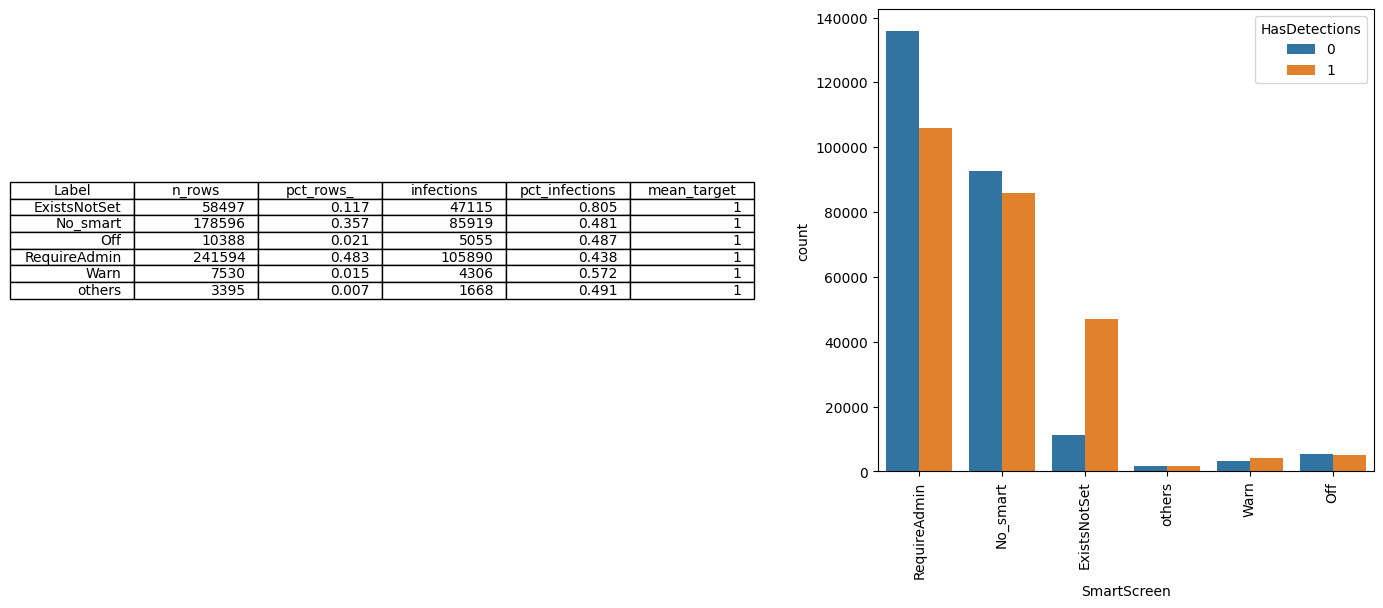

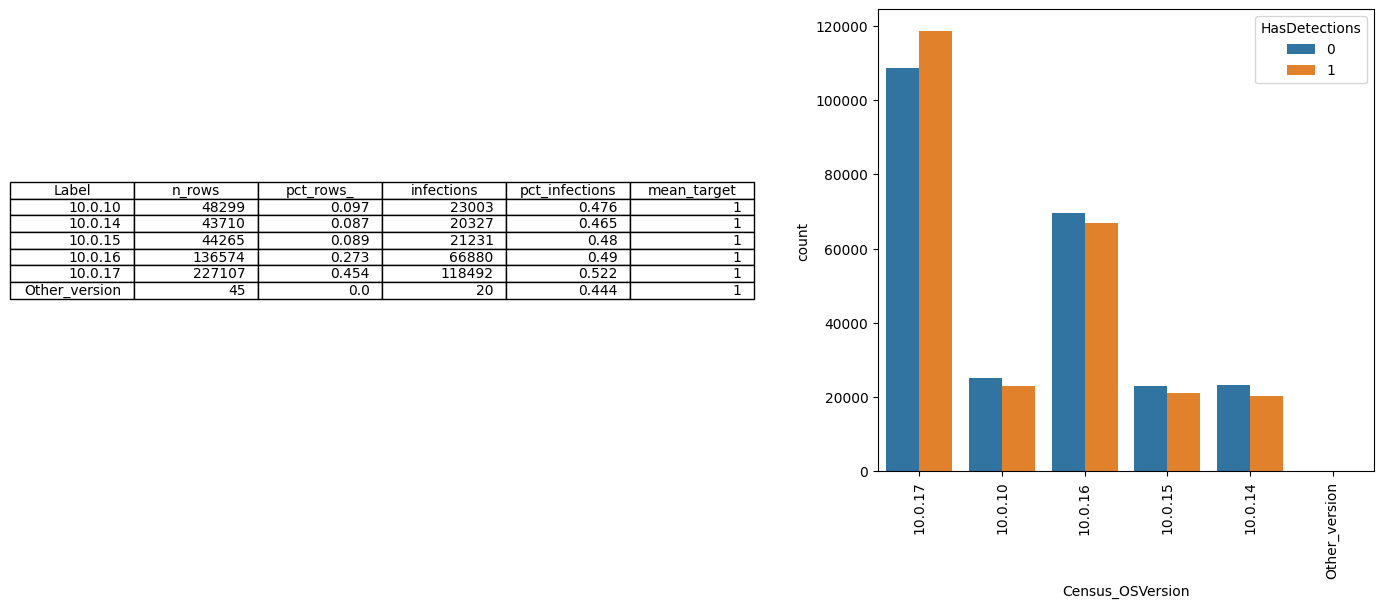

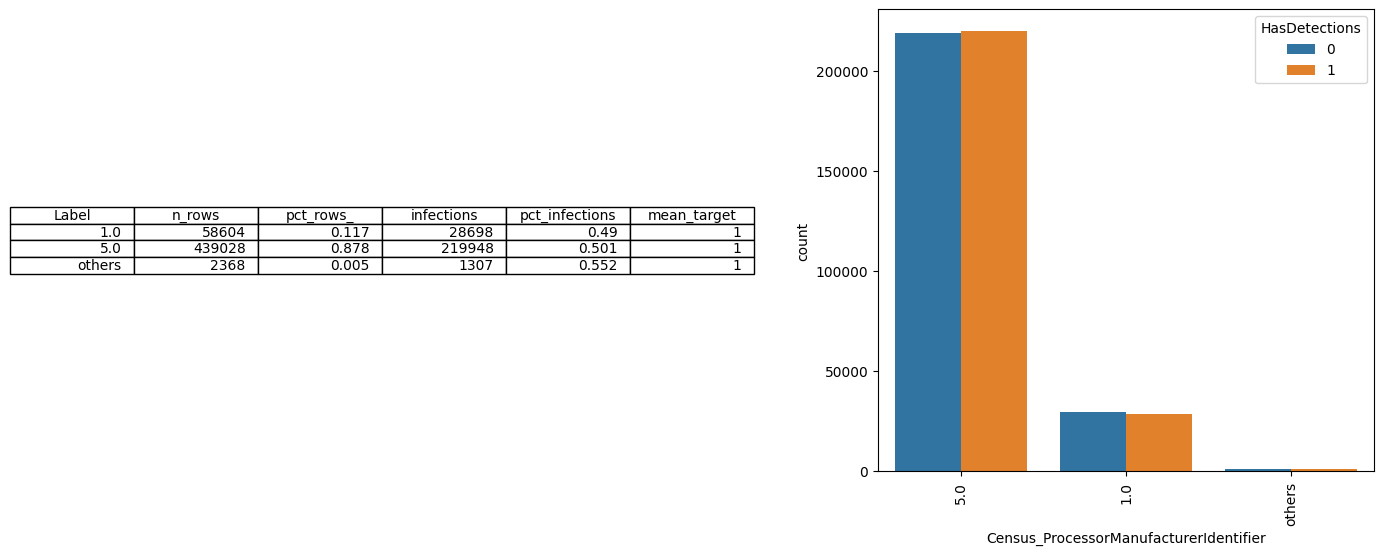

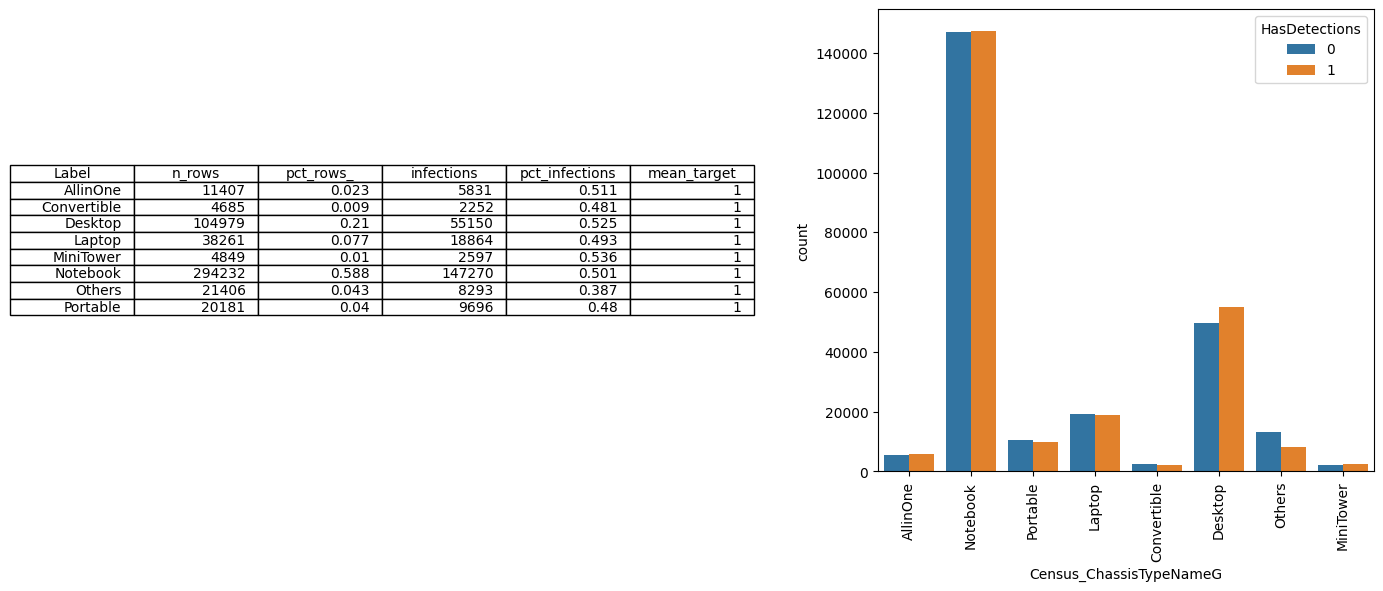

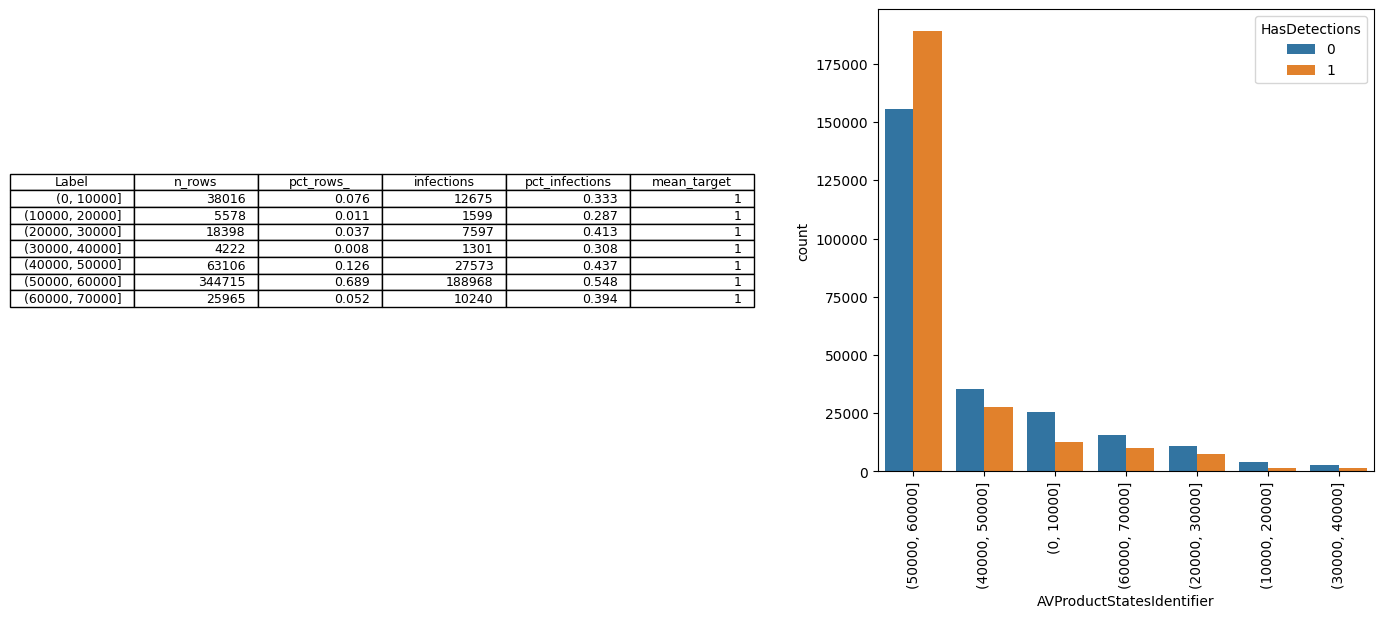

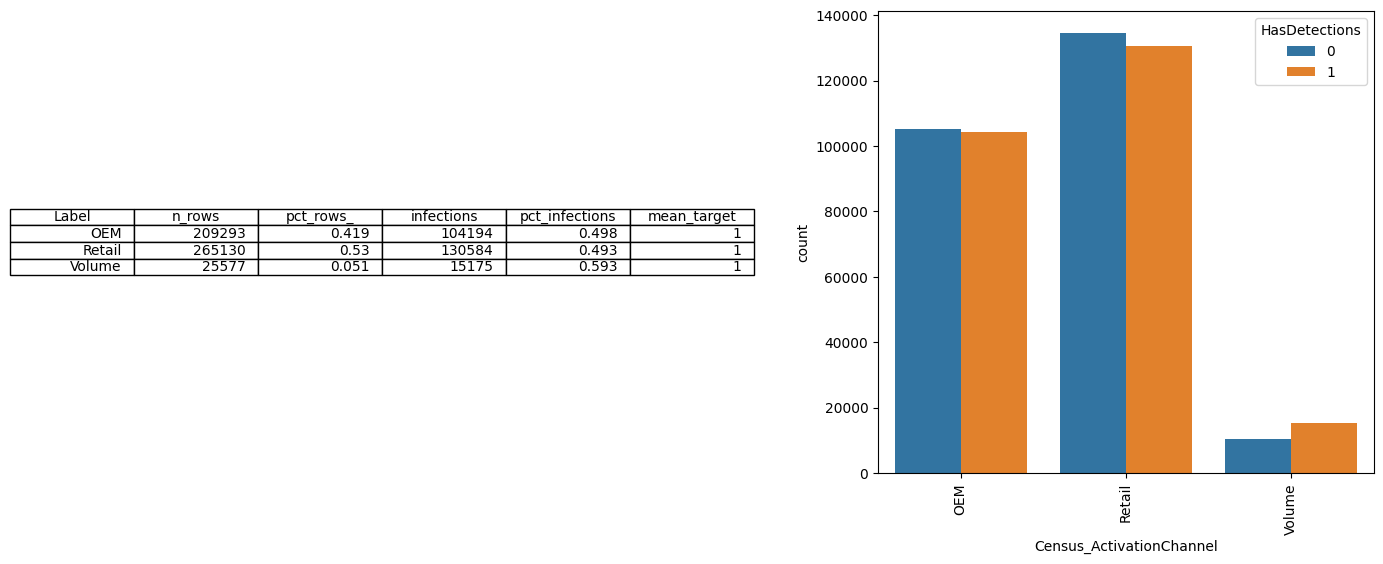

In [ ]:
for columns in columnas_OHE:
    output_table = explore_cat_values(MMP_clean, columns, TARGET)
    output_table['Label'] = output_table.index
    output_table = output_table[['Label'] + [col for col in output_table.columns if col != 'Label']]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

    ax1.axis('off')
    table = ax1.table(cellText=output_table.values, colLabels=output_table.columns, loc='center')
    table.auto_set_font_size(True)
    table.set_fontsize(10)

    table.scale(1.5, 1)

    ax2.set_xticks(range(len(output_table)))
    ax2.set_xticklabels(output_table.index, rotation=90)
    sns.countplot(data=MMP_clean, x=columns, hue=TARGET, ax=ax2)


    plt.subplots_adjust(wspace=0.5)  # Ajustar el espacio entre las subtramas

    plt.show()

In [ ]:
# En general se observa leve influencia de estas variables sobre el Target. Las siguientes variables no muestran nada influencia sobre el target: OsVer10, OrganizationIdentifierT, Census_ProcessorManufacturerIdentifier

2. Las columnas que se trataran con LabelEncoder, OrdinalEncoder y FrecuencyEncoder se analizaran después de la transformación.

### Variables booleanas

In [ ]:
columnas = ['Columna1', 'Columna2', 'Columna3']
columna_a_eliminar = 'Columna2'

columnas.remove(columna_a_eliminar)

In [ ]:
columnas_booleanas.remove('HasDetections')

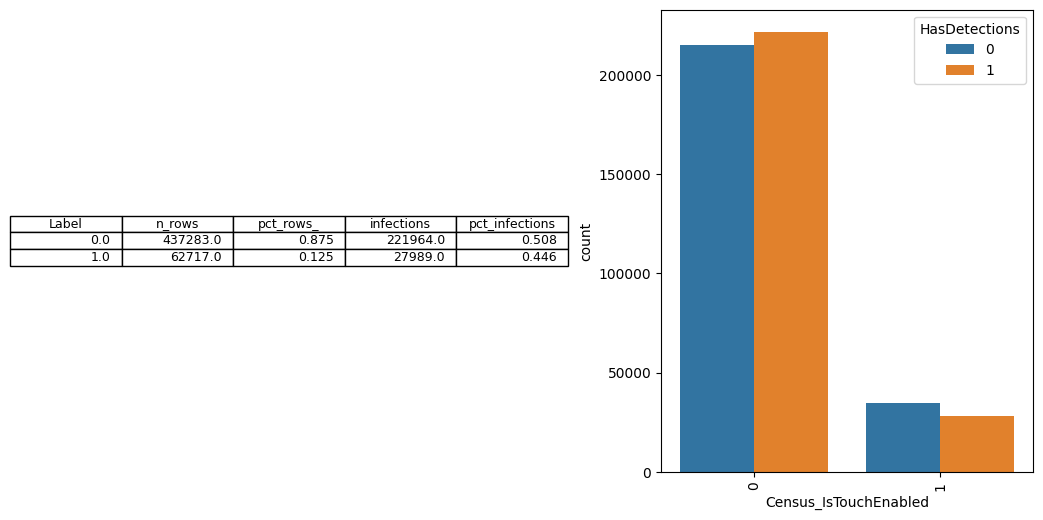

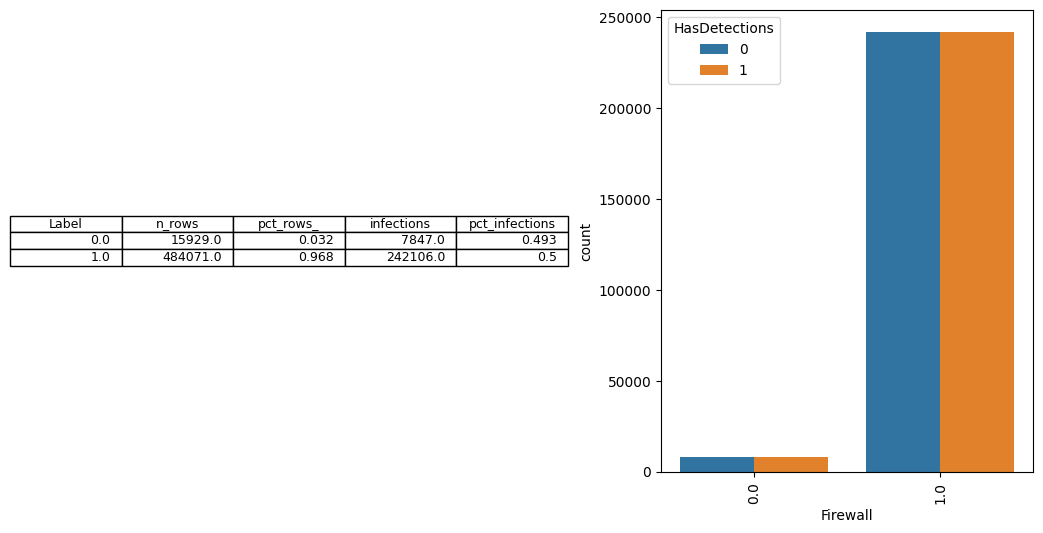

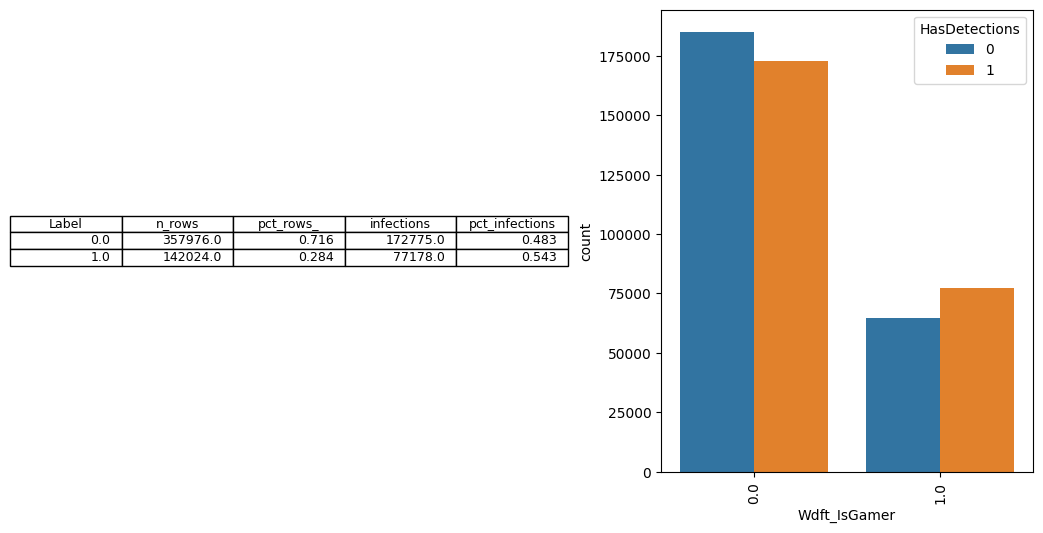

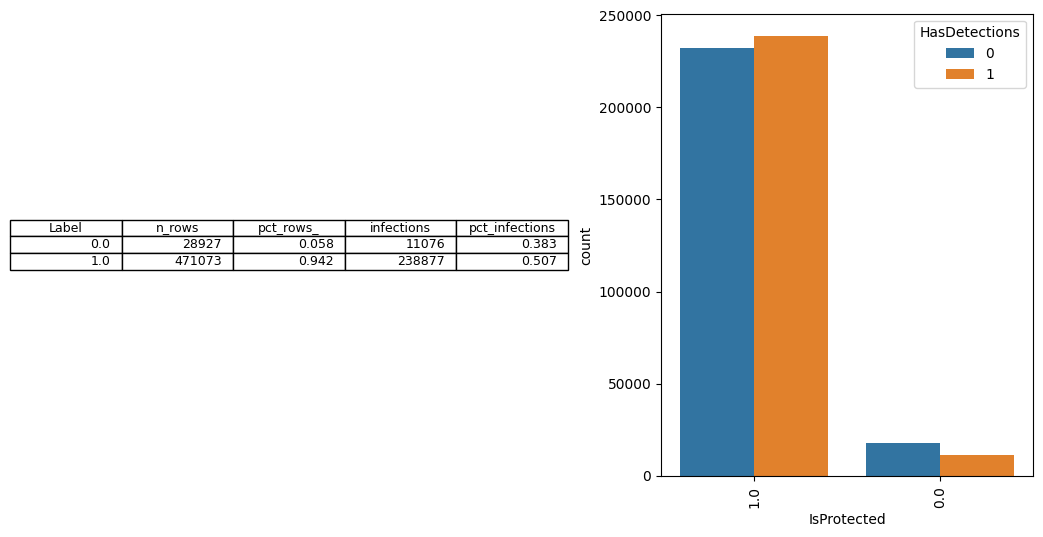

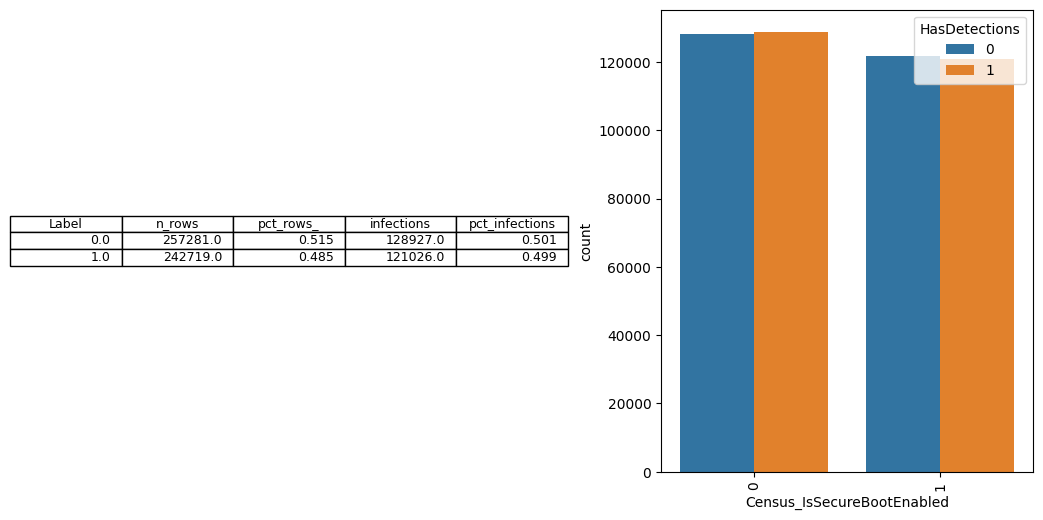

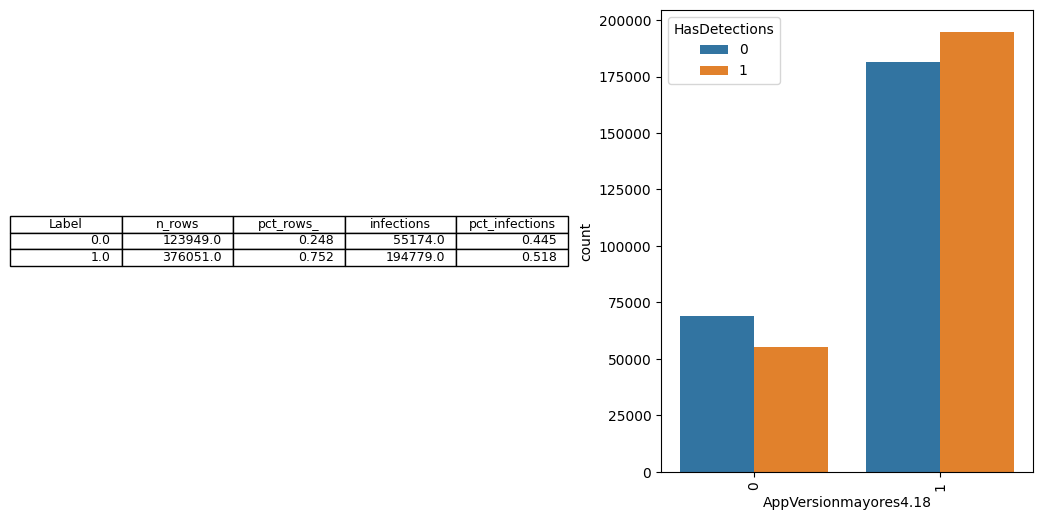

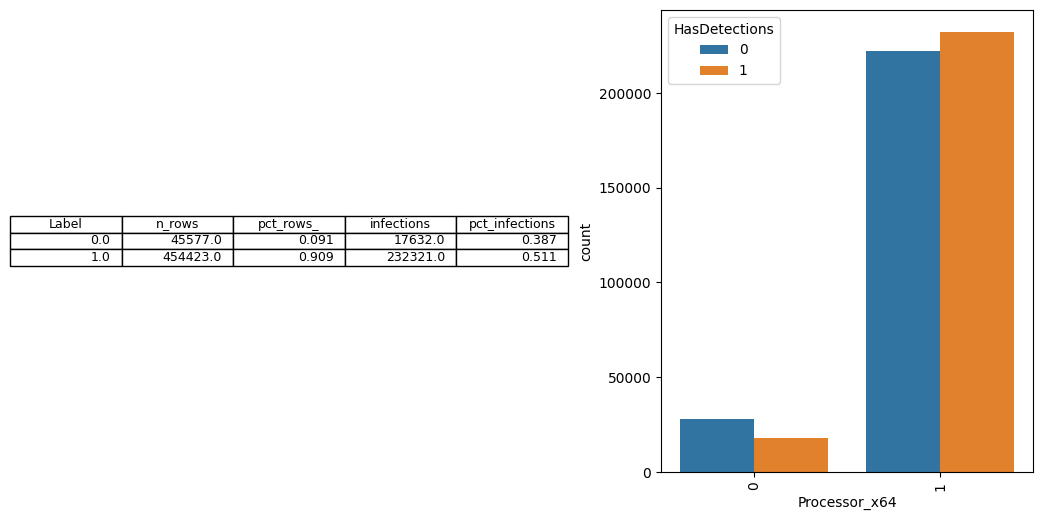

In [ ]:
for columns in columnas_booleanas:
    output_table = explore_cat_values(MMP_clean, columns, TARGET)
    output_table['Label'] = output_table.index
    output_table = output_table[['Label'] + [col for col in output_table.columns if col != 'Label']]
    output_table = output_table.drop('mean_target', axis=1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    ax1.axis('off')
    table = ax1.table(cellText=output_table.values, colLabels=output_table.columns, loc='center')
    table.auto_set_font_size(True)
    table.set_fontsize(10)

    table.scale(1.5, 1)

    ax2.set_xticks(range(len(output_table)))
    ax2.set_xticklabels(output_table.index, rotation=90)
    sns.countplot(data=MMP_clean, x=columns, hue=TARGET, ax=ax2)


    plt.subplots_adjust(wspace=0.5)  # Ajustar el espacio entre las subtramas

    plt.show()

In [ ]:
# La variable Census_IsSecureBootEnabled no muestra influencia sobre el Target.

### Variables numéricas

In [ ]:
columnas_MinMaxS

{'Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Census_InternalBatteryNumberOfCharges',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM'}

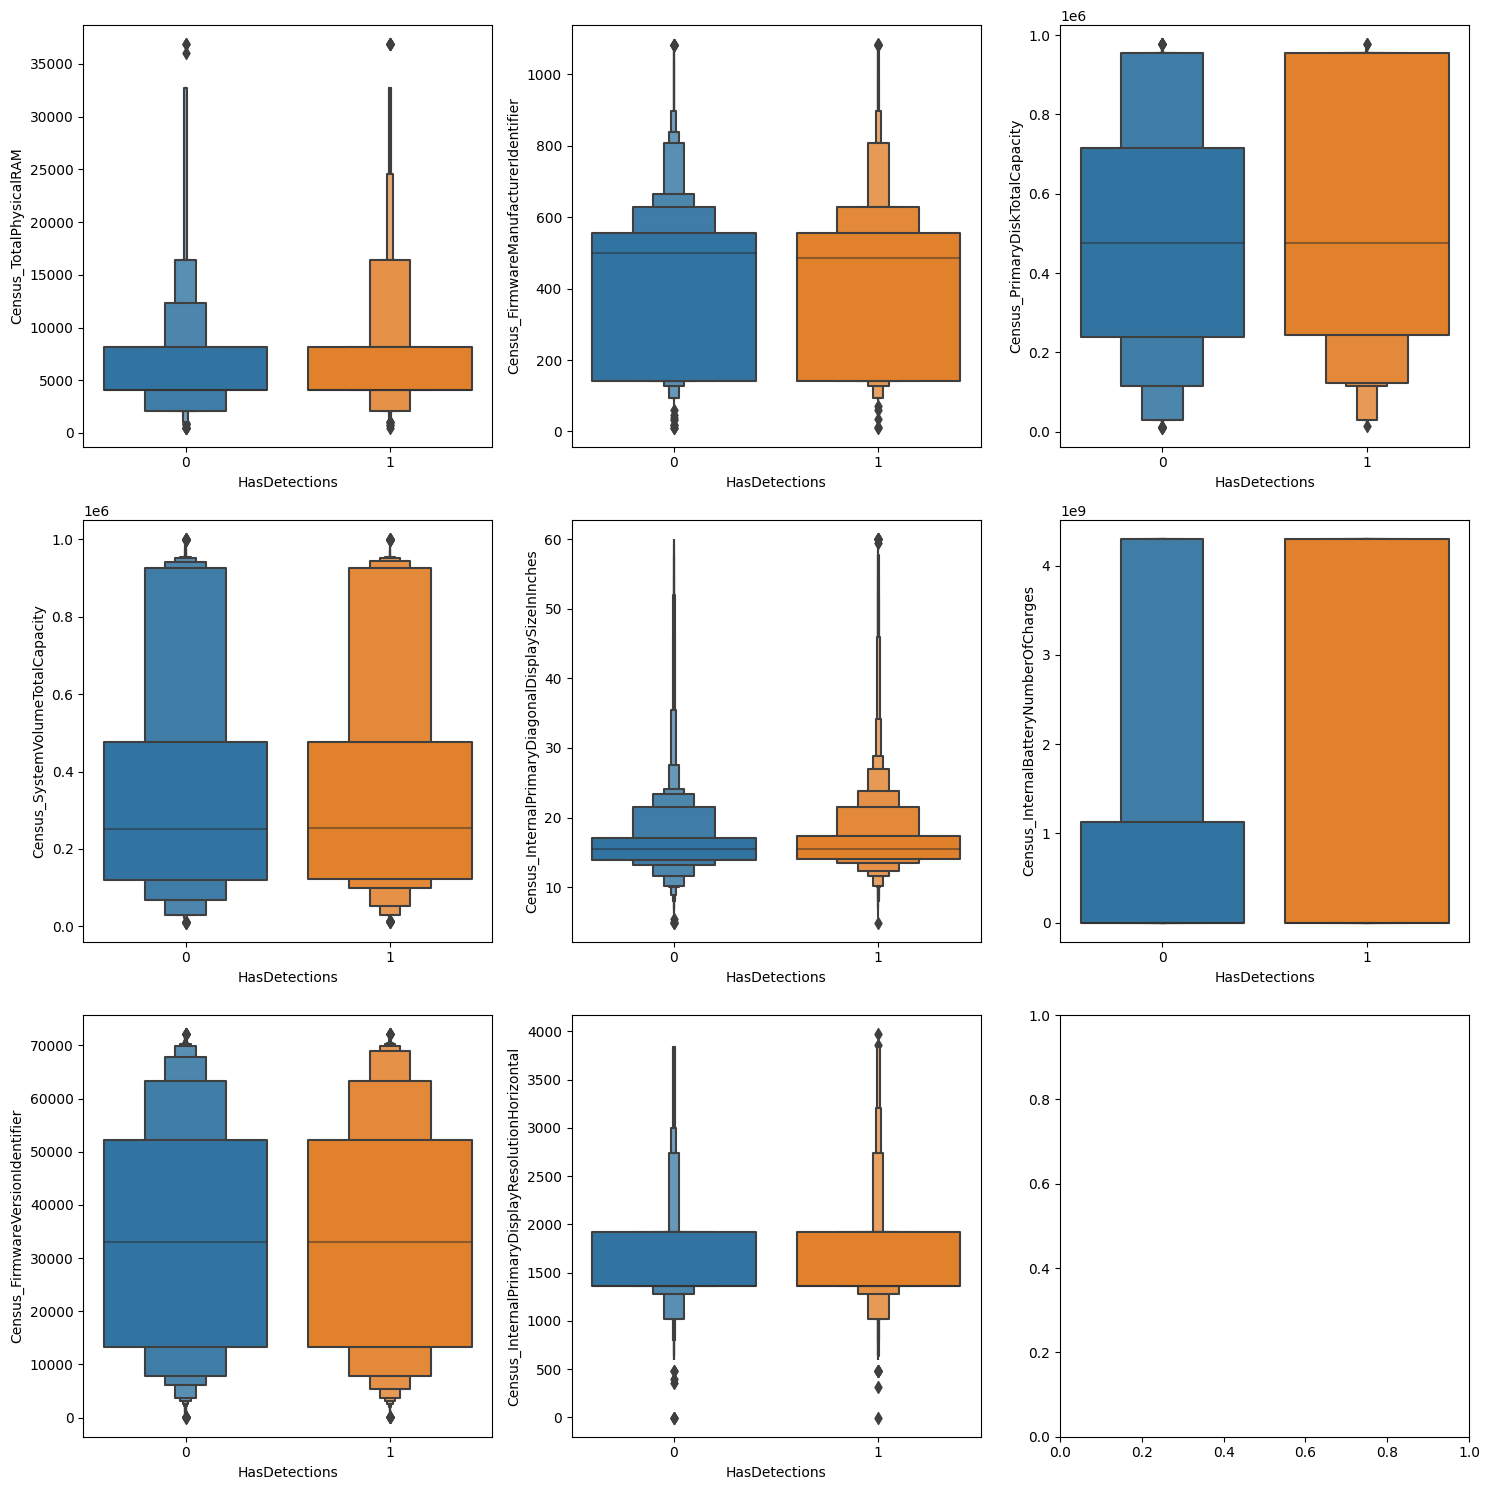

In [ ]:
num_columns = len(columnas_MinMaxS)
num_plots_per_row = 3
num_rows = (num_columns - 1) // num_plots_per_row + 1

fig, axes = plt.subplots(num_rows, num_plots_per_row, figsize=(15, 5*num_rows))

for i, column in enumerate(columnas_MinMaxS):
    row = i // num_plots_per_row
    col = i % num_plots_per_row

    sns.boxenplot(data=MMP_clean, x=TARGET, y=column, ax=axes[row, col])

plt.tight_layout()
plt.show()


In [ ]:
# Atributos que SÍ muestran influencia sobre el target: Census_PrimaryDiskTotalCapacity, Census_InternalBatteryNumberOfCharges

In [ ]:
df_numericas = MMP_clean[['Census_FirmwareManufacturerIdentifier',
 'Census_FirmwareVersionIdentifier',
 'Census_InternalBatteryNumberOfCharges',
 'Census_InternalPrimaryDiagonalDisplaySizeInInches',
 'Census_InternalPrimaryDisplayResolutionHorizontal',
 'Census_PrimaryDiskTotalCapacity',
 'Census_SystemVolumeTotalCapacity',
 'Census_TotalPhysicalRAM', 'HasDetections']]
corr = df_numericas.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# La variable Census_SystemVolumeTotalCapacity parece ser redundante con Census_PrimaryDiskTotalCapacity (> .7).

In [ ]:
MMP['Census_PrimaryDiskTotalCapacity'].describe()

count    4.970240e+05
mean     5.140433e+05
std      3.704468e+05
min      1.024000e+04
25%      2.393720e+05
50%      4.769400e+05
75%      9.538690e+05
max      4.768767e+07
Name: Census_PrimaryDiskTotalCapacity, dtype: float64

In [ ]:
MMP['Census_SystemVolumeTotalCapacity'].describe()

count    4.970240e+05
mean     3.780546e+05
std      3.384722e+05
min      9.689000e+03
25%      1.207750e+05
50%      2.494500e+05
75%      4.759810e+05
max      4.768710e+07
Name: Census_SystemVolumeTotalCapacity, dtype: float64

In [ ]:
# Eliminamos Census_SystemVolumeTotalCapacity por mostrar menos correlacion con el target despues de la transformacion

MMP_clean = MMP_clean.drop('Census_SystemVolumeTotalCapacity', axis=1)

In [ ]:
columnas_MinMaxS.remove('Census_SystemVolumeTotalCapacity')

In [ ]:
MMP_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 38 columns):
 #   Column                                             Non-Null Count   Dtype  
---  ------                                             --------------   -----  
 0   AVProductsInstalled                                500000 non-null  object 
 1   LocaleEnglishNameIdentifier                        500000 non-null  object 
 2   Platform                                           500000 non-null  object 
 3   IsProtected                                        500000 non-null  object 
 4   SmartScreen                                        500000 non-null  object 
 5   Firewall                                           500000 non-null  float64
 6   Census_ProcessorCoreCount                          500000 non-null  object 
 7   Census_ProcessorManufacturerIdentifier             500000 non-null  object 
 8   Census_PrimaryDiskTotalCapacity                    500000 non-null  float6

In [ ]:
MMP_prep = MMP_clean.copy()

In [ ]:
columns_list = set(columnas_OrdEnc) | set(columnas_FEnc) | set(columnas_MinMaxS)| set(columnas_OHE) | set(columnas_booleanas)
len(columns_list)

37

In [ ]:
columnas_faltantes = list(set(MMP_prep.columns) - columns_list)
columnas_faltantes

['HasDetections']

In [ ]:
#MMP_prep.to_pickle("/content/drive/MyDrive/CAPSTONE/TRABAJO GUILLEM/MMP500_CLEAN_PICKLE")

## Transformaciones

In [ ]:
# Se va a impurtar las transformaciones
#columnas_OrdEnc
#columnas_MinMaxS
#columnas_OHE
#columnas_FEnc

### 1. Frequency Encoding

In [ ]:
columnas_FEnc

{'Census_OSInstallLanguageIdentifier',
 'Census_OSUILocaleIdentifier',
 'LocaleEnglishNameIdentifier',
 'Platform'}

In [ ]:
for column in columnas_FEnc:
  df_column = pd.DataFrame(MMP_prep[column].value_counts(dropna = False))
  df_column.columns = [column + '_count']
  df_column[column] = df_column.index
  MMP_prep = MMP_prep.merge(df_column, on = column)
  MMP_prep.drop(column, axis = 1, inplace = True)

In [ ]:
MMP_prep[['LocaleEnglishNameIdentifier_count',
       'Census_OSInstallLanguageIdentifier_count',
       'Census_OSUILocaleIdentifier_count', 'Platform_count']]

LocaleEnglishNameIdentifier_count  \
0                                    6270   
1                                    6270   
2                                    6270   
3                                    6270   
4                                    6270   
...                                   ...   
499995                              20988   
499996                                 31   
499997                               8994   
499998                               4776   
499999                               3030   

        Census_OSInstallLanguageIdentifier_count  \
0                                           5956   
1                                           5956   
2                                           5956   
3                                           5956   
4                                           5956   
...                                          ...   
499995                                     10600   
499996                                      9512   
499997                                     11221   
499998                                     11221   
499999                                      2807   

        Census_OSUILocaleIdentifier_count  Platform_count  
0                                    5993          483048  
1                                    5993          483048  
2                                    5993          483048  
3                                    5993          483048  
4                                    5993          483048  
...                                   ...             ...  
499995                                  1          483048  
499996                                  1          483048  
499997                                  2          483048  
499998                                  2          483048  
499999                                  1          483048  

[500000 rows x 4 columns]

In [ ]:
MMP_prep['LocaleEnglishNameIdentifier_count'].value_counts().head(39)

117818    117818
25187      25187
23007      23007
22894      22894
20988      20988
19225      19225
19027      19027
18427      18427
11889      11889
10843      10843
10035      10035
9700        9700
9526        9526
8994        8994
8676        8676
7782        7782
7686        7686
7680        7680
6809        6809
6270        6270
5873        5873
5157        5157
5110        5110
5044        5044
4953        4953
4776        4776
4638        4638
4494        4494
4107        4107
4064        4064
3315        3315
3072        3072
3030        3030
2932        2932
2811        2811
2526        2526
2515        2515
2387        2387
2375        2375
Name: LocaleEnglishNameIdentifier_count, dtype: int64

In [ ]:
MMP_prep['Census_OSInstallLanguageIdentifier_count'].value_counts()

178405    178405
58013      58013
28766      28766
27669      27669
24191      24191
22635      22635
20268      20268
18520      18520
14085      14085
11497      11497
11221      11221
10600      10600
9512        9512
8127        8127
7502        7502
5956        5956
4775        4775
4695        4695
4516        4516
4067        4067
3332        3332
2881        2881
2807        2807
2311        2311
1996        1996
1793        1793
1652        1652
1213        1213
1119        1119
1096        1096
846          846
837          837
713          713
584          584
581          581
413          413
246          246
197          197
185          185
178          178
Name: Census_OSInstallLanguageIdentifier_count, dtype: int64

In [ ]:
df_FEnc = MMP_prep[['LocaleEnglishNameIdentifier_count',
       'Census_OSInstallLanguageIdentifier_count',
       'Census_OSUILocaleIdentifier_count', 'Platform_count']]
corr = df_FEnc.corr()
corr.style.background_gradient(cmap='coolwarm')

In [ ]:
# Creamos una nueva lista de columnas para eliminar.'Census_OSInstallLanguageIdentifier' por ser reduntante (corr > 0.98) con 'Census_OSUILocaleIdentifier' y estar peor distribuida

columnas_eliminar_new = ['Census_OSInstallLanguageIdentifier_count']

### 2. OHE



In [ ]:
columnas_OHE

{'AVProductStatesIdentifier',
 'Census_ActivationChannel',
 'Census_ChassisTypeNameG',
 'Census_OSEdition',
 'Census_OSInstallTypeName',
 'Census_OSVersion',
 'Census_OSWUAutoUpdateOptionsName',
 'Census_PrimaryDiskTypeName',
 'Census_ProcessorCoreCount',
 'Census_ProcessorManufacturerIdentifier',
 'CountryIdentifier',
 'EngineVersion',
 'IeVerIdentifier',
 'IsProtected',
 'OrganizationIdentifierT',
 'OsVer10',
 'SmartScreen'}

In [ ]:
lista_OHE = ["AVProductStatesIdentifier","Census_ActivationChannel","Census_ChassisTypeNameG","Census_OSEdition","Census_OSVersion",
             "Census_OSWUAutoUpdateOptionsName","Census_PrimaryDiskTypeName","Census_ProcessorCoreCount",
             "Census_ProcessorManufacturerIdentifier","CountryIdentifier","EngineVersion","IeVerIdentifier","OrganizationIdentifierT",
             "OsVer10","SmartScreen", "Census_OSInstallTypeName"]

In [ ]:
print('SmartScreen' in MMP_prep.columns)


True


In [ ]:
MMP_prep['SmartScreen'].value_counts()

RequireAdmin    241594
No_smart        178596
ExistsNotSet     58497
Off              10388
Warn              7530
others            3395
Name: SmartScreen, dtype: int64

In [ ]:
# a VER SI SOLUCIONAIS EL ERROR

for column in MMP_prep[lista_OHE]:
  OHE_df = pd.DataFrame(MMP_prep[column])
  OHE_df = pd.get_dummies(OHE_df)
  MMP_prep = pd.concat([MMP_prep, OHE_df], axis=1)
  MMP_prep.drop(column, axis=1, inplace=True)

In [ ]:
MMP_prep.columns

Index(['AVProductsInstalled', 'IsProtected', 'Firewall',
       'Census_PrimaryDiskTotalCapacity', 'Census_TotalPhysicalRAM',
       'Census_InternalPrimaryDiagonalDisplaySizeInInches',
       'Census_InternalPrimaryDisplayResolutionHorizontal',
       'Census_InternalBatteryNumberOfCharges',
       'Census_FirmwareManufacturerIdentifier',
       'Census_FirmwareVersionIdentifier',
       ...
       'SmartScreen_others', 'Census_OSInstallTypeName_Clean',
       'Census_OSInstallTypeName_CleanPCRefresh',
       'Census_OSInstallTypeName_IBSClean', 'Census_OSInstallTypeName_Other',
       'Census_OSInstallTypeName_Refresh', 'Census_OSInstallTypeName_Reset',
       'Census_OSInstallTypeName_UUPUpgrade',
       'Census_OSInstallTypeName_Update', 'Census_OSInstallTypeName_Upgrade'],
      dtype='object', length=124)

###ORDINAL ENCODER

In [ ]:
encoder = OrdinalEncoder()

for columna in columnas_OrdEnc:
    MMP_prep[columna] = MMP_prep[columna].sort_values()
    MMP_prep[[columna+'_ord']] = encoder.fit_transform(MMP_prep[[columna]])
    MMP_prep.drop(columna, axis=1, inplace=True)

## Analizar correlacion de variables

In [ ]:
MMP_prep.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Columns: 124 entries, IsProtected to AVProductsInstalled_ord
dtypes: float64(12), int64(9), object(1), uint8(102)
memory usage: 136.4+ MB


In [ ]:
MMP_prep.head()

IsProtected  Firewall  Census_PrimaryDiskTotalCapacity  \
0         1.0       1.0                         953869.0   
1         1.0       1.0                         228936.0   
2         1.0       1.0                         238475.0   
3         1.0       1.0                         114473.0   
4         1.0       1.0                         152627.0   

   Census_TotalPhysicalRAM  Census_InternalPrimaryDiagonalDisplaySizeInInches  \
0                   8192.0                                               23.0   
1                   8192.0                                               15.5   
2                  16384.0                                               24.0   
3                   4096.0                                               15.5   
4                   2048.0                                               13.3   

   Census_InternalPrimaryDisplayResolutionHorizontal  \
0                                             1920.0   
1                                             1920.0   
2                                             1920.0   
3                                             1366.0   
4                                             1024.0   

   Census_InternalBatteryNumberOfCharges  \
0                           4.294967e+09   
1                           5.770000e+02   
2                           4.294967e+09   
3                           0.000000e+00   
4                           0.000000e+00   

   Census_FirmwareManufacturerIdentifier  Census_FirmwareVersionIdentifier  \
0                                  355.0                           19951.0   
1                                  142.0                           48473.0   
2                                  142.0                            9348.0   
3                                  807.0                            3436.0   
4                                  798.0                           63396.0   

   Census_IsSecureBootEnabled  ...  Census_OSInstallTypeName_IBSClean  \
0                           0  ...                                  0   
1                           1  ...                                  1   
2                           0  ...                                  0   
3                           0  ...                                  0   
4                           0  ...                                  1   

   Census_OSInstallTypeName_Other  Census_OSInstallTypeName_Refresh  \
0                               0                                 0   
1                               0                                 0   
2                               0                                 0   
3                               0                                 0   
4                               0                                 0   

   Census_OSInstallTypeName_Reset  Census_OSInstallTypeName_UUPUpgrade  \
0                               0                                    1   
1                               0                                    0   
2                               0                                    0   
3                               0                                    1   
4                               0                                    0   

   Census_OSInstallTypeName_Update  Census_OSInstallTypeName_Upgrade  \
0                                0                                 0   
1                                0                                 0   
2                                1                                 0   
3                                0                                 0   
4                                0                                 0   

   Census_OSBuildRevision_ord  AvSigVersion_ord  AVProductsInstalled_ord  
0                        12.0              10.0                      0.0  
1                        23.0              10.0                      0.0  
2                        13.0              10.0                      0.0  
3                        30.0          

In [ ]:
MMP_prep['HasDetections'].mean()

0.499906

In [ ]:
corr = MMP_prep.corr()
corr.style.background_gradient(cmap='coolwarm')

<ipython-input-526-58368c0eefc8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = MMP_prep.corr()


In [ ]:
#Como tenemos muchas columnas, es muy complicado de leer las correlaciones. De la siguiente manera obtenemos solo las correlaciones positivas que nos interesan.


corr = MMP_prep.corr()

correlated_values = corr[(corr > 0.1) & (corr < 1.0)].stack().dropna()

correlated_values_sorted = correlated_values.sort_values(ascending=False)

print(correlated_values_sorted)


<ipython-input-527-dd83086008c6>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = MMP_prep.corr()


Census_OSInstallLanguageIdentifier_count  Census_OSUILocaleIdentifier_count           0.979812
Census_OSUILocaleIdentifier_count         Census_OSInstallLanguageIdentifier_count    0.979812
Platform_count                            OsVer10_10                                  0.974048
OsVer10_10                                Platform_count                              0.974048
Census_OSVersion_10.0.17                  IeVerIdentifier_137.0                       0.954411
                                                                                        ...   
Census_OSEdition_Core                     CountryIdentifier_60                        0.100393
Census_OSVersion_10.0.14                  Census_OSInstallTypeName_Other              0.100388
Census_OSInstallTypeName_Other            Census_OSVersion_10.0.14                    0.100388
Census_ActivationChannel_OEM              Census_ChassisTypeNameG_Convertible         0.100020
Census_ChassisTypeNameG_Convertible       Census_A

In [ ]:
#Como tenemos muchas columnas, es muy complicado de leer las correlaciones. De la siguiente manera obtenemos solo las correlaciones positivas que nos interesan.


corr = MMP_prep.corr()

correlated_values = corr[(corr < -0.1) & (corr < 1.0)].stack().dropna()

correlated_values_sorted = correlated_values.sort_values(ascending=False)

print(correlated_values_sorted)

<ipython-input-528-68e113467500>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = MMP_prep.corr()


Census_OSEdition_Core                       Census_OSEdition_Others                      -0.100480
Census_OSEdition_Others                     Census_OSEdition_Core                        -0.100480
IeVerIdentifier_98.0                        IeVerIdentifier_117.0                        -0.100500
IeVerIdentifier_117.0                       IeVerIdentifier_98.0                         -0.100500
Census_OSVersion_10.0.10                    Census_ActivationChannel_OEM                 -0.100763
                                                                                            ...   
OsVer10_6                                   Platform_count                               -0.974048
Census_ProcessorManufacturerIdentifier_1.0  Census_ProcessorManufacturerIdentifier_5.0   -0.977756
Census_ProcessorManufacturerIdentifier_5.0  Census_ProcessorManufacturerIdentifier_1.0   -0.977756
OsVer10_6                                   OsVer10_10                                   -1.000000
OsVer10_10

In [ ]:
#Con estos valores, decidimos eliminar "Platform_count" y "Census_OSInstallLanguageIdentifier_count", ya que tienen una correlacion muy alta.
#En el caso de las demás variables, las dejaremos para ver como se comporta el modelo con ellas.

In [ ]:
columnas_eliminar_new.append("Platform_count")

In [ ]:
columnas_eliminar_new

['Census_OSInstallLanguageIdentifier_count', 'Platform_count']

In [ ]:
MMP_prep = MMP_prep.drop(columnas_eliminar_new, axis=1)

#MODELLING



In [ ]:
MMP_modelling = MMP_prep.copy()

In [ ]:
from sklearn import model_selection #train/test/value
from sklearn import metrics #evaluation

##Train/test/Split

In [ ]:
MMP_modelling.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 500000 entries, 0 to 499999
Columns: 122 entries, IsProtected to AVProductsInstalled_ord
dtypes: float64(12), int64(7), object(1), uint8(102)
memory usage: 128.7+ MB


In [ ]:
#Para hacer la partición del modelo, al no tener ninguna referencia de fecha, vamos a hacerlo mediante el número de filas. Dejando 400.000 filas para train y 100.000 para test.

# Seleccionar las primeras 400,000 filas para entrenamiento (train)
train_df = MMP_modelling.iloc[:400000]

# Seleccionar las últimas 100,000 filas para prueba (test)
test_df = MMP_modelling.iloc[-100000:]

In [ ]:
# Verificar los tamaños de los conjuntos de entrenamiento y prueba
print("Tamaño del conjunto de entrenamiento:", train_df.shape)
print("Tamaño del conjunto de prueba:", test_df.shape)

Tamaño del conjunto de entrenamiento: (400000, 122)
Tamaño del conjunto de prueba: (100000, 122)


In [ ]:
#Ahora vamos a asignar a cada conjunto, su valor x e y.

train_df_X = train_df.drop(TARGET, axis=1)
train_df_y = train_df[[TARGET]]

test_df_X = test_df.drop(TARGET, axis=1)
test_df_y = test_df[[TARGET]]


###Random Holdout

In [ ]:
#Como tenemos una muestra muy grande, podremos hacer un test size bajo con 0.20

In [ ]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
                                        train_df_X, # X
                                        train_df_y, # y
                                        test_size = 0.20, # tamaño del split aleatorio
                                        random_state = 42
                                     )

###Definicion del modelo

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
dt = DecisionTreeClassifier(
                        # criterion='gini',
                        # splitter='best',
                        max_depth=4, # Importante, regulará el sobreajuste
                        # min_samples_split=2,
                        min_samples_leaf=5000,
                        # min_weight_fraction_leaf=0.0,
                        # max_features=None,
                        random_state=42,
                        # max_leaf_nodes=None,
                        # min_impurity_decrease=0.0,
                        # min_impurity_split=None,
                        # class_weight=None,
                        # presort=False,
                )

In [ ]:
dt.fit(
    X=X_train,
    y=y_train,
    # sample_weight=None,
    # check_input=True,
    # X_idx_sorted=None
)

DecisionTreeClassifier(max_depth=4, min_samples_leaf=5000, random_state=42)

In [ ]:
##Para comprobar que nuestra partición está bien hecho y está siendo random, hacemos una pequeña comprabacion de los DF.

X_train.describe().T.head()


count           mean  \
Firewall                                           320000.0       0.967078   
Census_PrimaryDiskTotalCapacity                    320000.0  494880.646461   
Census_TotalPhysicalRAM                            320000.0    6050.542211   
Census_InternalPrimaryDiagonalDisplaySizeInInches  320000.0      16.393168   
Census_InternalPrimaryDisplayResolutionHorizontal  320000.0    1551.576591   

                                                             std      min  \
Firewall                                                0.178432      0.0   
Census_PrimaryDiskTotalCapacity                    309096.587364  10471.0   
Census_TotalPhysicalRAM                              4252.007710    512.0   
Census_InternalPrimaryDiagonalDisplaySizeInInches       4.551120      4.9   
Census_InternalPrimaryDisplayResolutionHorizontal     365.625543     -1.0   

                                                        25%       50%  \
Firewall                                                1.0       1.0   
Census_PrimaryDiskTotalCapacity                    244198.0  476940.0   
Census_TotalPhysicalRAM                              4096.0    4096.0   
Census_InternalPrimaryDiagonalDisplaySizeInInches      13.9      15.5   
Census_InternalPrimaryDisplayResolutionHorizontal    1366.0    1366.0   

                                                        75%       max  
Firewall                                                1.0       1.0  
Census_PrimaryDiskTotalCapacity                    953344.0  976776.0  
Census_TotalPhysicalRAM                              8192.0   36864.0  
Census_InternalPrimaryDiagonalDisplaySizeInInches      17.2      60.0  
Census_InternalPrimaryDisplayResolutionHorizontal    1920.0    3968.0

In [ ]:
X_test.describe().T.head()


count           mean  \
Firewall                                           80000.0       0.967400   
Census_PrimaryDiskTotalCapacity                    80000.0  496397.538944   
Census_TotalPhysicalRAM                            80000.0    6045.470566   
Census_InternalPrimaryDiagonalDisplaySizeInInches  80000.0      16.418006   
Census_InternalPrimaryDisplayResolutionHorizontal  80000.0    1549.851835   

                                                             std      min  \
Firewall                                                0.177588      0.0   
Census_PrimaryDiskTotalCapacity                    309306.736915  10240.0   
Census_TotalPhysicalRAM                              4223.176022    512.0   
Census_InternalPrimaryDiagonalDisplaySizeInInches       4.620862      5.0   
Census_InternalPrimaryDisplayResolutionHorizontal     364.759671    480.0   

                                                        25%       50%  \
Firewall                                                1.0       1.0   
Census_PrimaryDiskTotalCapacity                    244198.0  476940.0   
Census_TotalPhysicalRAM                              4096.0    4096.0   
Census_InternalPrimaryDiagonalDisplaySizeInInches      13.9      15.5   
Census_InternalPrimaryDisplayResolutionHorizontal    1366.0    1366.0   

                                                        75%       max  
Firewall                                                1.0       1.0  
Census_PrimaryDiskTotalCapacity                    953869.0  976768.0  
Census_TotalPhysicalRAM                              8192.0   36864.0  
Census_InternalPrimaryDiagonalDisplaySizeInInches      17.2      60.0  
Census_InternalPrimaryDisplayResolutionHorizontal    1920.0    3860.0

In [ ]:
dot_data = export_graphviz(
                        decision_tree = dt,
                        out_file=None,
                        # max_depth=None,
                        feature_names=X_test.columns,
                        class_names=['Infectec', 'No Infected'],
                        # label='all',
                        filled=True,
                        # leaves_parallel=False,
                        impurity=True,
                        # node_ids=False,
                        proportion=True,
                        rotate=True,
                        rounded=True,
                        # special_characters=False,
                        precision=4,
                        )

In [ ]:
import pydotplus
graph2 = pydotplus.graph_from_dot_data(dot_data)

In [ ]:
graph2.write_png("tree.png")

True

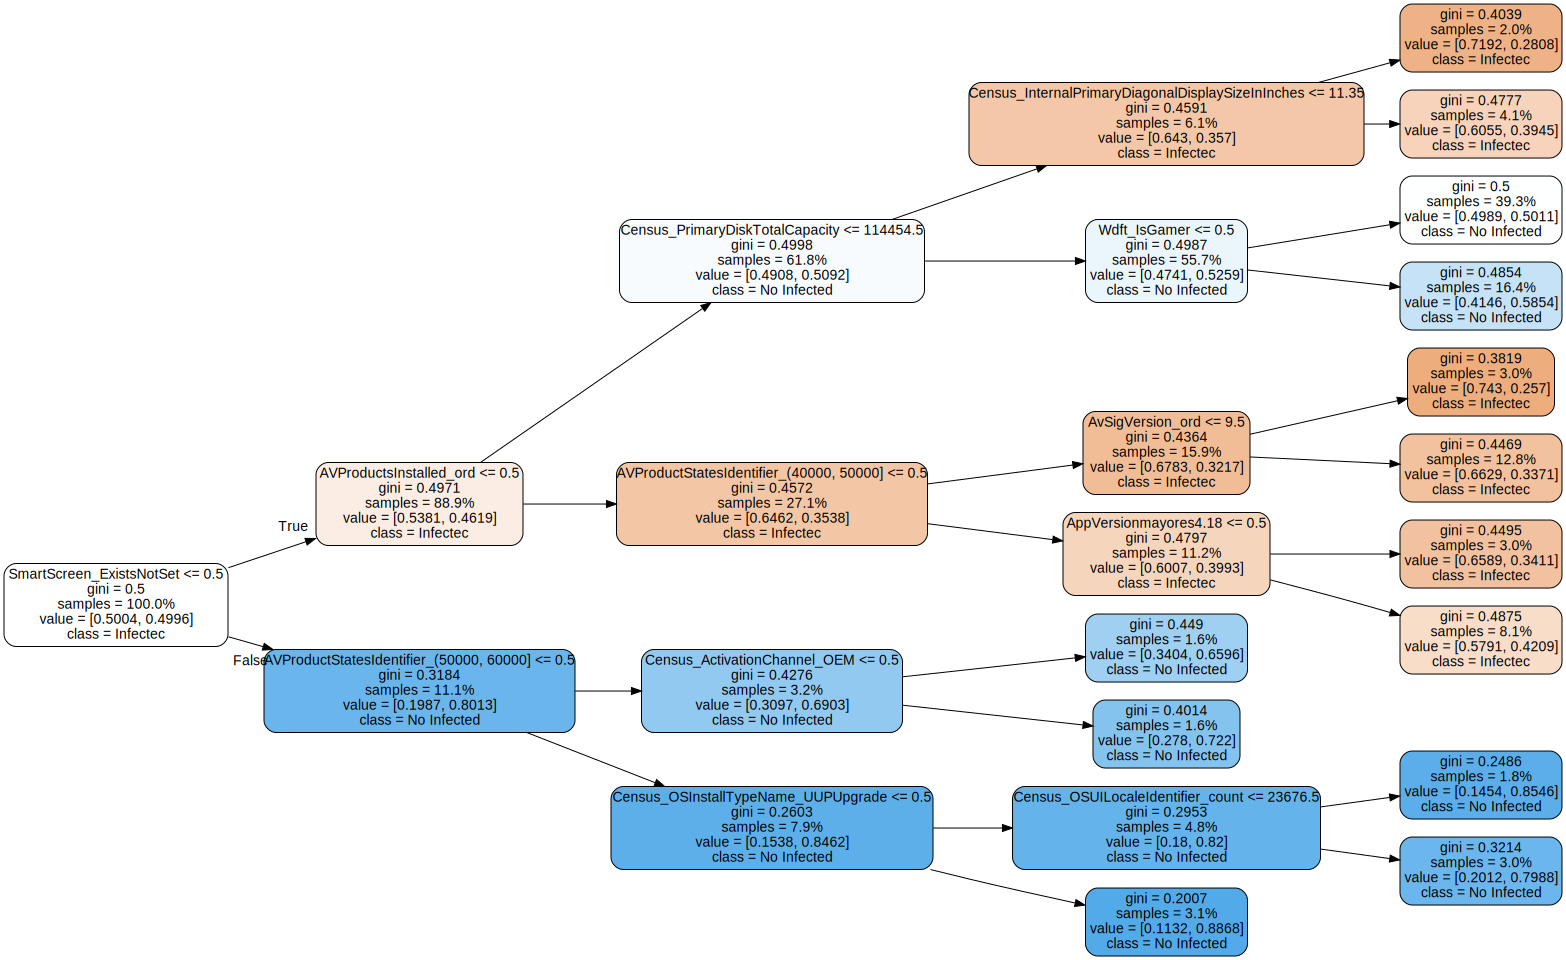

In [ ]:
graphviz.Source(dot_data, format = 'png')

In [ ]:
#medicion usando el modelo, esto nos da el accuracy

dt.score(X_test, y_test)

0.5975625

##Evaluacion del modelo

In [ ]:
#predicciones
y_test_pred = pd.DataFrame(dt.predict(X_test), index=y_test.index, columns=[TARGET])

In [ ]:
results_df = y_test.join(y_test_pred, lsuffix='_y_test', rsuffix='_y_test_pred', how='inner')

results_df.head(10)




HasDetections_y_test  HasDetections_y_test_pred
23218                      0                          1
20731                      1                          1
39555                      1                          1
147506                     1                          1
314215                     1                          0
190913                     1                          0
296715                     0                          1
141482                     1                          0
49119                      0                          1
208005                     0                          0

In [ ]:
#Tiene pinta de que hay muchos falsos positivos.

In [ ]:
results_df['Success'] = (results_df["HasDetections_y_test"] == results_df['HasDetections_y_test_pred']).astype(int)

In [ ]:
#Accuracy
results_df["Success"].mean()

0.5975625

### Confusion matrix

In [ ]:
##Comprobamos que hay muchos falsos positivos.
confusion_matrix = pd.crosstab(results_df['HasDetections_y_test'], results_df['HasDetections_y_test_pred'])

confusion_matrix

HasDetections_y_test_pred      0      1
HasDetections_y_test                   
0                          16998  22690
1                           9505  30807

In [ ]:
TP = confusion_matrix.iloc[1,1]
TN = confusion_matrix.iloc[0,0]
FP = confusion_matrix.iloc[0,1]
FN = confusion_matrix.iloc[1,0]

In [ ]:
FP

22690

In [ ]:
FN

9505

In [ ]:
accuracy = (TP + TN) / (TP + TN + FP + FN)
accuracy

0.5975625

### Accuracy

In [ ]:
#Finalmente usamos este modelo, que es el más cómo de sacar el accuracy, para saber que lo anterior lo habíamos hecho bien.

dt.score(X_test, y_test)

0.5975625

###Probabilidades

In [ ]:
#Es interesante mirar como nuestro modelo falla en las predicciones y si son muy graves.

y_score = pd.DataFrame(dt.predict_proba(X_test)[:,1], index=y_test.index, columns=[TARGET])

In [ ]:
results_df = results_df.join(y_score)

In [ ]:
results_df.head(10)

#No vemos errores muy graves, puede venir influenciado por tener una muestra casi 50/50. Vemos que cuando el modelo predices que es muy probable que haya infección, la hay, y viceversa.
#Exiten problemas en las predicciones que rozan el 0.50y vemos un par de datos con 0.33 que también se equivoca.

HasDetections_y_test  HasDetections_y_test_pred  Success  \
23218                      0                          1        0   
20731                      1                          1        1   
39555                      1                          1        1   
147506                     1                          1        1   
314215                     1                          0        0   
190913                     1                          0        0   
296715                     0                          1        0   
141482                     1                          0        0   
49119                      0                          1        0   
208005                     0                          0        1   

        HasDetections  
23218        0.501066  
20731        0.585355  
39555        0.501066  
147506       0.501066  
314215       0.420885  
190913       0.280835  
296715       0.501066  
141482       0.420885  
49119        0.501066  
208005       0.337084

In [ ]:
results_df[results_df["HasDetections"] < 0.30].head(10)

#Vemos como por debajo de 0.30, acierta con bastante probabilidad (aquí en 9 de 10)


HasDetections_y_test  HasDetections_y_test_pred  Success  \
190913                     1                          0        0   
381071                     1                          0        0   
314420                     0                          0        1   
279827                     0                          0        1   
249364                     1                          0        0   
356888                     0                          0        1   
378962                     0                          0        1   
344673                     1                          0        0   
210597                     0                          0        1   
48772                      1                          0        0   

        HasDetections  
190913       0.280835  
381071       0.280835  
314420       0.257011  
279827       0.257011  
249364       0.280835  
356888       0.257011  
378962       0.257011  
344673       0.257011  
210597       0.280835  
48772        0.257011

In [ ]:
results_df[results_df["HasDetections"] > 0.80].head(10)

#Vemos como por encima de 0.80, acierta con bastante probabilidad (aquí en 8 de 10)

HasDetections_y_test  HasDetections_y_test_pred  Success  \
257076                     1                          1        1   
10817                      1                          1        1   
290452                     1                          1        1   
246477                     1                          1        1   
265501                     1                          1        1   
363274                     1                          1        1   
236832                     1                          1        1   
321266                     1                          1        1   
132620                     1                          1        1   
324297                     0                          1        0   

        HasDetections  
257076       0.886819  
10817        0.886819  
290452       0.886819  
246477       0.886819  
265501       0.886819  
363274       0.854570  
236832       0.886819  
321266       0.886819  
132620       0.886819  
324297       0.854570

###F1 Score


In [ ]:
Precision = TP / (TP+FP)
Recall = TP / (TP+FN)

In [ ]:
f1_score = 2 /(1/Precision + 1/Recall)

In [ ]:
f1_score

0.6568026521975503

In [ ]:
# Predecimos un 57% de las muestras positivas. Es un valor no excesivamente alto
Precision

0.575864067143952

In [ ]:
#La mayoría de los TP son clasificados bien, en este caso la Recall es buena.
Recall

0.7642141297876562

In [ ]:
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_test_pred)
print("F1 score:", f1)

F1 score: 0.6568026521975503


### ROC curve y AUC


In [ ]:
#AUC
metrics.roc_auc_score(results_df['HasDetections_y_test'], results_df['HasDetections'])

0.6491851751760577

In [ ]:
#ROC Curve

fpr, tpr, _ = metrics.roc_curve(results_df['HasDetections_y_test'], results_df['HasDetections'])

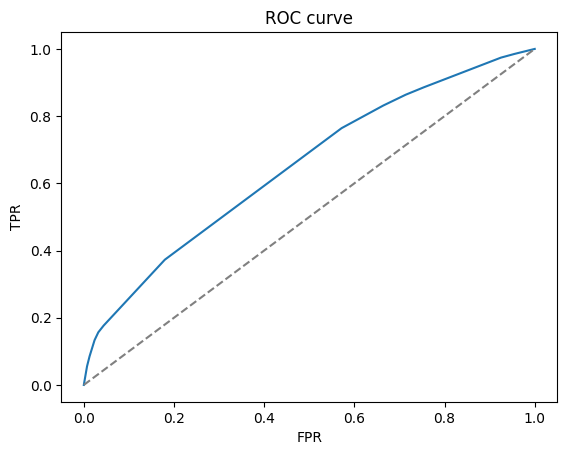

In [ ]:
plt.clf()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('ROC curve')
plt.show()

###K-Fold

In [ ]:
kf = model_selection.KFold(n_splits=10, random_state=42, shuffle=True)

In [ ]:
scores_list = []
for train_index, test_index in kf.split(train_df):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = train_df_X.iloc[train_index], train_df_X.iloc[test_index]
    y_train, y_test = train_df_y.iloc[train_index], train_df_y.iloc[test_index]
    dt = DecisionTreeClassifier(max_depth=8, random_state=42)
    dt.fit(X_train, y_train)
    _score = dt.score(X_test, y_test)
    scores_list.append(_score)
    #print(_scores)
scores_list

[0.6134,
 0.619675,
 0.616025,
 0.617875,
 0.616575,
 0.61755,
 0.61875,
 0.614025,
 0.6154,
 0.61515]

### random forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Crear una instancia del clasificador Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Realizar predicciones
y_pred = rf_model.predict(X_test)


<ipython-input-588-2cb2cdffbcc5>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)


In [ ]:
from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.60875


###Gradient boosting

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

gb = GradientBoostingClassifier(n_estimators=50, max_depth=5, min_samples_split=500, random_state=42)
gb.fit(X_train, np.ravel(y_train))

GradientBoostingClassifier(max_depth=5, min_samples_split=500, n_estimators=50,
                           random_state=42)

In [ ]:
y_score = pd.DataFrame(gb.predict_proba(X_test)[:,1], index=y_test.index, columns=['HasDetections'])

In [ ]:
results_df = y_test.join(y_score, lsuffix='_y_test', rsuffix='_y_score')

results_df


HasDetections_y_test  HasDetections_y_score
5                          0               0.331458
15                         0               0.325513
18                         1               0.454562
36                         0               0.483887
37                         1               0.461145
...                      ...                    ...
399975                     0               0.468960
399977                     1               0.820714
399989                     0               0.431831
399992                     0               0.498160
399994                     0               0.586197

[40000 rows x 2 columns]

In [ ]:
print(metrics.roc_auc_score(results_df['HasDetections_y_test'], results_df['HasDetections_y_score']))

0.6789069573730127


###Control del Overfitting

In [ ]:
#Observamos como la profundidad más adecuada para nuestro modelo es sobre 10.

for i in range(1, 20):
    dt = DecisionTreeClassifier(max_depth=i, random_state=42)
    dt.fit(X_train, y_train)
    train_accuracy = dt.score(X_train, y_train)
    test_accuracy = dt.score(X_test, y_test)
    print('Profundidad del árbol: {}. Train: {} - Test: {}'.format(i, train_accuracy, test_accuracy))

Profundidad del árbol: 1. Train: 0.5666416666666667 - Test: 0.5658
Profundidad del árbol: 2. Train: 0.5794583333333333 - Test: 0.573925
Profundidad del árbol: 3. Train: 0.5970722222222222 - Test: 0.59125
Profundidad del árbol: 4. Train: 0.5970722222222222 - Test: 0.59125
Profundidad del árbol: 5. Train: 0.6054777777777778 - Test: 0.600275
Profundidad del árbol: 6. Train: 0.6116527777777778 - Test: 0.6059
Profundidad del árbol: 7. Train: 0.61665 - Test: 0.6108
Profundidad del árbol: 8. Train: 0.6214916666666667 - Test: 0.61515
Profundidad del árbol: 9. Train: 0.6234722222222222 - Test: 0.614725
Profundidad del árbol: 10. Train: 0.6279888888888889 - Test: 0.614675
Profundidad del árbol: 11. Train: 0.6333472222222222 - Test: 0.617775
Profundidad del árbol: 12. Train: 0.6390444444444444 - Test: 0.6161
Profundidad del árbol: 13. Train: 0.6461777777777777 - Test: 0.614225
Profundidad del árbol: 14. Train: 0.6548694444444444 - Test: 0.611325
Profundidad del árbol: 15. Train: 0.664941666666666

## Comparacion de modelos

In [ ]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

RANDOM_STATE = 42
n_estimators = 50
max_depth = 5

models = [
    ('DecisionTree', DecisionTreeClassifier(max_depth=max_depth, random_state=42)),
    ('RandomForest', RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_STATE)),
    ('GradientBoosting', GradientBoostingClassifier(n_estimators=n_estimators, max_depth=max_depth, random_state=RANDOM_STATE))
]

ROC AUC Score for DecisionTree: 0.6510880068631892
ROC AUC Score for RandomForest: 0.6600992502355846
ROC AUC Score for GradientBoosting: 0.6790305032782467


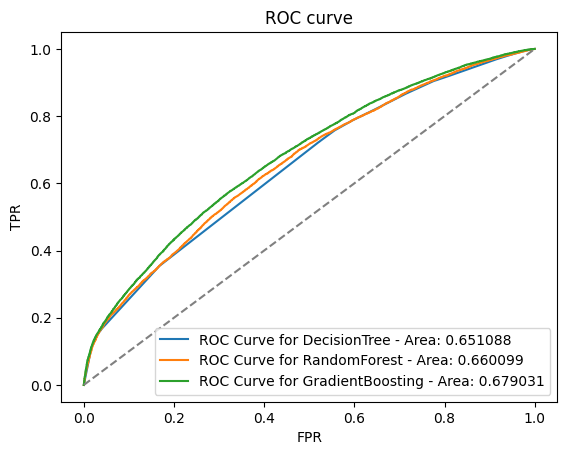

In [ ]:
plt.clf()
for model in models:
    model_name = model[0]
    model_instance = model[1]
    model_instance.fit(X_train, np.ravel(y_train))
    predictions = model_instance.predict_proba(X_test)[:,1]
    auc_score = metrics.roc_auc_score(y_test, predictions)
    print('ROC AUC Score for {}: {}'.format(model_name, auc_score))
    fpr, tpr, _ = metrics.roc_curve(y_test, predictions)
    plt.plot(fpr, tpr, label='ROC Curve for {} - Area: {:2f}'.format(model_name, auc_score))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.legend(loc="lower right")
plt.title('ROC curve')
plt.show()

------------------------------------------------------------------------------